In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from pandas.api.types import CategoricalDtype
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory
from sklearn import model_selection, ensemble, metrics, linear_model
import matplotlib.pyplot as plt
from sklearn.preprocessing import *
import os
base_dir = '../data'
print(os.listdir(base_dir))


# Any results you write to the current directory are saved as output.https://www.kaggle.com/wanermiranda/linear-regression-ml-tp1?scriptVersionId=5240484

['test.pkl', 'diamonds.csv', 'train.pkl']


In [2]:
df_diamonds = pd.read_csv('%s/diamonds.csv'%(base_dir), index_col='Unnamed: 0')
df_diamonds.head(10)

,carat,cut,color,clarity,depth,table,price,x,y,z
1,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
2,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
3,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
4,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
5,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75
6,0.24,Very Good,J,VVS2,62.8,57.0,336,3.94,3.96,2.48
7,0.24,Very Good,I,VVS1,62.3,57.0,336,3.95,3.98,2.47
8,0.26,Very Good,H,SI1,61.9,55.0,337,4.07,4.11,2.53
9,0.22,Fair,E,VS2,65.1,61.0,337,3.87,3.78,2.49
10,0.23,Very Good,H,VS1,59.4,61.0,338,4.00,4.05,2.39


## Numeric Features 
* Carat: weight of the diamond
* depth: depth %  The height of a diamond, measured from the culet to the table, divided by its average girdle diameter
* table: table % The width of the diamond's table expressed as a percentage of its average diameter
* price: the price of the diamond
* xlength: mm
* ywidth: mm
* zdepth: mm

In [3]:
df_diamonds.describe()

,carat,depth,table,price,x,y,z
count,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000
mean,0.797940,61.749405,57.457184,3932.799722,5.731157,5.734526,3.538734
std,0.474011,1.432621,2.234491,3989.439738,1.121761,1.142135,0.705699
min,0.200000,43.000000,43.000000,326.000000,0.000000,0.000000,0.000000
25%,0.400000,61.000000,56.000000,950.000000,4.710000,4.720000,2.910000
50%,0.700000,61.800000,57.000000,2401.000000,5.700000,5.710000,3.530000
75%,1.040000,62.500000,59.000000,5324.250000,6.540000,6.540000,4.040000
max,5.010000,79.000000,95.000000,18823.000000,10.740000,58.900000,31.800000


## cut 
Describe cut quality of the diamond. Quality in increasing order Fair, Good, Very Good, Premium, Ideal

In [4]:
cuts_ordered = ['Fair',
                'Good',
                'Very Good',
                'Premium',
                'Ideal']
df_diamonds['cut'] = df_diamonds['cut'].astype(CategoricalDtype(cuts_ordered, ordered=True))
print(df_diamonds['cut'].unique())
df_diamonds['cut'].describe()

[Ideal, Premium, Good, Very Good, Fair]
Categories (5, object): [Fair < Good < Very Good < Premium < Ideal]


count     53940
unique        5
top       Ideal
freq      21551
Name: cut, dtype: object

## color
mColor of the diamond, with D being the best and J the worst

In [5]:
colors_ordered = [  'J',
                    'I',
                    'H',
                    'G',
                    'F',
                    'E',
                    'D']
df_diamonds['color'] = df_diamonds['color'].astype(CategoricalDtype(colors_ordered, ordered=True))
print(df_diamonds['color'].unique())
df_diamonds['color'].describe()

[E, I, J, H, F, G, D]
Categories (7, object): [J < I < H < G < F < E < D]


count     53940
unique        7
top           G
freq      11292
Name: color, dtype: object

## clarity
How obvious inclusions are within the diamond:(in order from best to worst, FL = flawless, I3= level 3 inclusions) FL,IF, VVS1, VVS2, VS1, VS2, SI1, SI2, I1, I2, I3

In [6]:
clarity_codes = {'I3',
'I2',
'I1',
'SI2',
'SI1',
'VS2',
'VS1',
'VVS2',
'VVS1',
'IF',
'FL'}
df_diamonds['clarity'] = df_diamonds['clarity'].astype(CategoricalDtype(clarity_codes, ordered=True))
print(df_diamonds['clarity'].unique())
df_diamonds['clarity'].describe()

[SI2, SI1, VS1, VS2, VVS2, VVS1, I1, IF]
Categories (8, object): [VS1 < VS2 < SI2 < I1 < SI1 < VVS1 < VVS2 < IF]


count     53940
unique        8
top         SI1
freq      13065
Name: clarity, dtype: object

## Cleaning the Data
There are some zero dimensions for the diamonds, since that must be noise or mistype, we are cleaning it.


In [7]:
df_diamonds = df_diamonds.drop(df_diamonds.loc[df_diamonds.x <= 0].index)
df_diamonds = df_diamonds.drop(df_diamonds.loc[df_diamonds.y <= 0].index)
df_diamonds = df_diamonds.drop(df_diamonds.loc[df_diamonds.z <= 0].index)

## Handcraft features
Since the measures for the diamond follow a 3d shape, we are considering here some handcraft features. 
Volume for the diamond = reflecting its size and weight. 
Ratio between the X, Y and Z.


In [8]:
df_diamonds['volume'] = df_diamonds['x'] * df_diamonds['y'] * df_diamonds['z']
df_diamonds['ratio'] = df_diamonds['x'] / df_diamonds['y']
df_diamonds['ratio'] = df_diamonds['x'] / df_diamonds['z']
df_diamonds.head(10)

,carat,cut,color,clarity,depth,table,price,x,y,z,volume,ratio
1,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43,38.202030,1.625514
2,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31,34.505856,1.683983
3,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31,38.076885,1.753247
4,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63,46.724580,1.596958
5,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75,51.917250,1.578182
6,0.24,Very Good,J,VVS2,62.8,57.0,336,3.94,3.96,2.48,38.693952,1.588710
7,0.24,Very Good,I,VVS1,62.3,57.0,336,3.95,3.98,2.47,38.830870,1.599190
8,0.26,Very Good,H,SI1,61.9,55.0,337,4.07,4.11,2.53,42.321081,1.608696
9,0.22,Fair,E,VS2,65.1,61.0,337,3.87,3.78,2.49,36.425214,1.554217
10,0.23,Very Good,H,VS1,59.4,61.0,338,4.00,4.05,2.39,38.718000,1.673640


In [9]:
train, test_reserved = model_selection.train_test_split(df_diamonds, test_size=0.2, random_state=42)
test_reserved.to_csv('test.csv')
train.to_csv('train.csv')
# test_reserved = pd.read_csv('test.csv', index_col='Unnamed: 0')
# train = pd.read_csv('train.csv', index_col='Unnamed: 0')
df_diamonds = train

# Distribution Overview
The prices seems to follow a power law curve, as show bellow in the graph. 

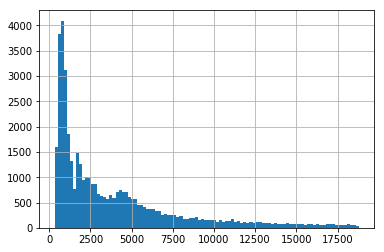

In [10]:
df_diamonds['price'].hist(bins=100)

In [11]:
df_diamonds['price'].describe()

count    43136.000000
mean      3926.531459
std       3983.079043
min        326.000000
25%        950.750000
50%       2398.000000
75%       5330.000000
max      18806.000000
Name: price, dtype: float64

## SGD Regression For Fun


In [12]:
cat_columns = df_diamonds.select_dtypes(['category']).columns.values
df_diamonds[cat_columns] = df_diamonds[cat_columns].apply(lambda x: x.cat.codes)



## Normalizing the Data
Using the robust scaller **to not only use the mean normalization**, but also to be less vulnerable to outliers.

In [13]:
X  = df_diamonds.copy()
y = X.pop('price')
scaler = RobustScaler()
scaler.fit(X)
X = scaler.transform(X)


## Regression
Since there is no negative values in the prices we are using here the log(price) to maintain this domain during the regression train. 
We are also using a 5 cross fold validation to do the grid search. 

A validation set was extracted from the data as a simulation for the test set.


In [14]:
from sklearn.model_selection import *

X_train, X_val, y_train, y_val = model_selection.train_test_split(X, y, test_size=0.1, random_state=42)


In [25]:

    
params = {
    'learning_rate':['invscaling', 'optimal'],
    'eta0': [0.1, 0.05, 0.01], 
    'max_iter':[20000]
}

scoring = {
    'NEG_MSE': 'neg_mean_squared_error',
    'NEG_MAE': 'neg_mean_absolute_error',
    'VARIANCE': 'r2'
}

best_params = {'eta0': [0.01], 'learning_rate': ['invscaling'], 'max_iter': [10000]}
best_params_ = {'eta0': 0.01, 'learning_rate': 'invscaling', 'max_iter': 10000}

## Removing the penalty because it could lead to throubles
## when implementing the regression
regr = linear_model.SGDRegressor(eta0 = 0.01, learning_rate = 'invscaling', max_iter = 10000, verbose=True) 

# regr_ = GridSearchCV(regr_, best_params, cv=2,
#                        scoring=scoring, refit='VARIANCE',
#                     n_jobs=-1,
#                    verbose=True
#                    )

#regr = GridSearchCV(linear_model.SGDRegressor(),params,cv=3, scoring=scoring, refit='VARIANCE', n_jobs=-1, verbose=True)

regr.fit(X_train, np.log(y_train))
# results = regr.cv_results_


-- Epoch 1
Norm: 0.83, NNZs: 11, Bias: 7.661306, T: 38822, Avg. loss: 0.178088
Total training time: 0.01 seconds.
-- Epoch 2
Norm: 1.16, NNZs: 11, Bias: 7.704965, T: 77644, Avg. loss: 0.041951
Total training time: 0.02 seconds.
-- Epoch 3
Norm: 1.30, NNZs: 11, Bias: 7.741149, T: 116466, Avg. loss: 0.032814
Total training time: 0.04 seconds.
-- Epoch 4
Norm: 1.41, NNZs: 11, Bias: 7.764372, T: 155288, Avg. loss: 0.026652
Total training time: 0.05 seconds.
-- Epoch 5
Norm: 1.46, NNZs: 11, Bias: 7.770366, T: 194110, Avg. loss: 0.025899
Total training time: 0.06 seconds.
-- Epoch 6
Norm: 1.51, NNZs: 11, Bias: 7.780702, T: 232932, Avg. loss: 0.025624
Total training time: 0.07 seconds.
-- Epoch 7
Norm: 1.53, NNZs: 11, Bias: 7.777792, T: 271754, Avg. loss: 0.025514
Total training time: 0.08 seconds.
-- Epoch 8
Norm: 1.55, NNZs: 11, Bias: 7.787622, T: 310576, Avg. loss: 0.025461
Total training time: 0.09 seconds.
-- Epoch 9
Norm: 1.56, NNZs: 11, Bias: 7.787760, T: 349398, Avg. loss: 0.025592
To

Norm: 1.63, NNZs: 11, Bias: 7.791264, T: 2834006, Avg. loss: 0.025237
Total training time: 0.82 seconds.
-- Epoch 74
Norm: 1.63, NNZs: 11, Bias: 7.794094, T: 2872828, Avg. loss: 0.025240
Total training time: 0.84 seconds.
-- Epoch 75
Norm: 1.63, NNZs: 11, Bias: 7.794434, T: 2911650, Avg. loss: 0.025240
Total training time: 0.85 seconds.
-- Epoch 76
Norm: 1.63, NNZs: 11, Bias: 7.792224, T: 2950472, Avg. loss: 0.025243
Total training time: 0.86 seconds.
-- Epoch 77
Norm: 1.63, NNZs: 11, Bias: 7.791766, T: 2989294, Avg. loss: 0.025240
Total training time: 0.87 seconds.
-- Epoch 78
Norm: 1.63, NNZs: 11, Bias: 7.790929, T: 3028116, Avg. loss: 0.025234
Total training time: 0.88 seconds.
-- Epoch 79
Norm: 1.63, NNZs: 11, Bias: 7.791599, T: 3066938, Avg. loss: 0.025217
Total training time: 0.89 seconds.
-- Epoch 80
Norm: 1.63, NNZs: 11, Bias: 7.793177, T: 3105760, Avg. loss: 0.025227
Total training time: 0.90 seconds.
-- Epoch 81
Norm: 1.63, NNZs: 11, Bias: 7.790906, T: 3144582, Avg. loss: 0.0

Norm: 1.67, NNZs: 11, Bias: 7.787127, T: 5629190, Avg. loss: 0.025163
Total training time: 1.65 seconds.
-- Epoch 146
Norm: 1.68, NNZs: 11, Bias: 7.791798, T: 5668012, Avg. loss: 0.025159
Total training time: 1.67 seconds.
-- Epoch 147
Norm: 1.68, NNZs: 11, Bias: 7.790739, T: 5706834, Avg. loss: 0.025156
Total training time: 1.68 seconds.
-- Epoch 148
Norm: 1.68, NNZs: 11, Bias: 7.791595, T: 5745656, Avg. loss: 0.025161
Total training time: 1.69 seconds.
-- Epoch 149
Norm: 1.68, NNZs: 11, Bias: 7.792816, T: 5784478, Avg. loss: 0.025160
Total training time: 1.70 seconds.
-- Epoch 150
Norm: 1.68, NNZs: 11, Bias: 7.793166, T: 5823300, Avg. loss: 0.025162
Total training time: 1.72 seconds.
-- Epoch 151
Norm: 1.68, NNZs: 11, Bias: 7.791975, T: 5862122, Avg. loss: 0.025160
Total training time: 1.73 seconds.
-- Epoch 152
Norm: 1.68, NNZs: 11, Bias: 7.789994, T: 5900944, Avg. loss: 0.025163
Total training time: 1.74 seconds.
-- Epoch 153
Norm: 1.68, NNZs: 11, Bias: 7.795975, T: 5939766, Avg. l

Norm: 1.73, NNZs: 11, Bias: 7.792105, T: 9045526, Avg. loss: 0.025120
Total training time: 2.68 seconds.
-- Epoch 234
Norm: 1.73, NNZs: 11, Bias: 7.791662, T: 9084348, Avg. loss: 0.025113
Total training time: 2.70 seconds.
-- Epoch 235
Norm: 1.73, NNZs: 11, Bias: 7.791423, T: 9123170, Avg. loss: 0.025117
Total training time: 2.71 seconds.
-- Epoch 236
Norm: 1.73, NNZs: 11, Bias: 7.793821, T: 9161992, Avg. loss: 0.025117
Total training time: 2.72 seconds.
-- Epoch 237
Norm: 1.73, NNZs: 11, Bias: 7.794345, T: 9200814, Avg. loss: 0.025111
Total training time: 2.73 seconds.
-- Epoch 238
Norm: 1.73, NNZs: 11, Bias: 7.793885, T: 9239636, Avg. loss: 0.025114
Total training time: 2.74 seconds.
-- Epoch 239
Norm: 1.73, NNZs: 11, Bias: 7.794451, T: 9278458, Avg. loss: 0.025120
Total training time: 2.75 seconds.
-- Epoch 240
Norm: 1.73, NNZs: 11, Bias: 7.792930, T: 9317280, Avg. loss: 0.025111
Total training time: 2.76 seconds.
-- Epoch 241
Norm: 1.73, NNZs: 11, Bias: 7.791458, T: 9356102, Avg. l

Norm: 1.76, NNZs: 11, Bias: 7.793092, T: 11840710, Avg. loss: 0.025092
Total training time: 3.52 seconds.
-- Epoch 306
Norm: 1.76, NNZs: 11, Bias: 7.795539, T: 11879532, Avg. loss: 0.025087
Total training time: 3.53 seconds.
-- Epoch 307
Norm: 1.76, NNZs: 11, Bias: 7.794564, T: 11918354, Avg. loss: 0.025093
Total training time: 3.54 seconds.
-- Epoch 308
Norm: 1.76, NNZs: 11, Bias: 7.792589, T: 11957176, Avg. loss: 0.025096
Total training time: 3.55 seconds.
-- Epoch 309
Norm: 1.76, NNZs: 11, Bias: 7.792008, T: 11995998, Avg. loss: 0.025099
Total training time: 3.56 seconds.
-- Epoch 310
Norm: 1.76, NNZs: 11, Bias: 7.791020, T: 12034820, Avg. loss: 0.025092
Total training time: 3.57 seconds.
-- Epoch 311
Norm: 1.76, NNZs: 11, Bias: 7.791706, T: 12073642, Avg. loss: 0.025099
Total training time: 3.58 seconds.
-- Epoch 312
Norm: 1.77, NNZs: 11, Bias: 7.792048, T: 12112464, Avg. loss: 0.025094
Total training time: 3.59 seconds.
-- Epoch 313
Norm: 1.77, NNZs: 11, Bias: 7.793792, T: 1215128

Norm: 1.79, NNZs: 11, Bias: 7.792847, T: 14752360, Avg. loss: 0.025083
Total training time: 4.33 seconds.
-- Epoch 381
Norm: 1.79, NNZs: 11, Bias: 7.789211, T: 14791182, Avg. loss: 0.025079
Total training time: 4.35 seconds.
-- Epoch 382
Norm: 1.79, NNZs: 11, Bias: 7.792955, T: 14830004, Avg. loss: 0.025077
Total training time: 4.36 seconds.
-- Epoch 383
Norm: 1.79, NNZs: 11, Bias: 7.792284, T: 14868826, Avg. loss: 0.025080
Total training time: 4.37 seconds.
-- Epoch 384
Norm: 1.79, NNZs: 11, Bias: 7.793210, T: 14907648, Avg. loss: 0.025086
Total training time: 4.38 seconds.
-- Epoch 385
Norm: 1.79, NNZs: 11, Bias: 7.791079, T: 14946470, Avg. loss: 0.025085
Total training time: 4.39 seconds.
-- Epoch 386
Norm: 1.79, NNZs: 11, Bias: 7.793675, T: 14985292, Avg. loss: 0.025082
Total training time: 4.40 seconds.
-- Epoch 387
Norm: 1.79, NNZs: 11, Bias: 7.794519, T: 15024114, Avg. loss: 0.025077
Total training time: 4.42 seconds.
-- Epoch 388
Norm: 1.79, NNZs: 11, Bias: 7.794039, T: 1506293

Norm: 1.81, NNZs: 11, Bias: 7.792608, T: 17508722, Avg. loss: 0.025073
Total training time: 5.14 seconds.
-- Epoch 452
Norm: 1.81, NNZs: 11, Bias: 7.793561, T: 17547544, Avg. loss: 0.025072
Total training time: 5.15 seconds.
-- Epoch 453
Norm: 1.81, NNZs: 11, Bias: 7.792573, T: 17586366, Avg. loss: 0.025077
Total training time: 5.17 seconds.
-- Epoch 454
Norm: 1.81, NNZs: 11, Bias: 7.794599, T: 17625188, Avg. loss: 0.025066
Total training time: 5.18 seconds.
-- Epoch 455
Norm: 1.81, NNZs: 11, Bias: 7.795096, T: 17664010, Avg. loss: 0.025072
Total training time: 5.19 seconds.
-- Epoch 456
Norm: 1.81, NNZs: 11, Bias: 7.792904, T: 17702832, Avg. loss: 0.025074
Total training time: 5.20 seconds.
-- Epoch 457
Norm: 1.81, NNZs: 11, Bias: 7.793832, T: 17741654, Avg. loss: 0.025068
Total training time: 5.21 seconds.
-- Epoch 458
Norm: 1.81, NNZs: 11, Bias: 7.793440, T: 17780476, Avg. loss: 0.025079
Total training time: 5.22 seconds.
-- Epoch 459
Norm: 1.81, NNZs: 11, Bias: 7.794224, T: 1781929

Norm: 1.83, NNZs: 11, Bias: 7.795268, T: 20381550, Avg. loss: 0.025069
Total training time: 5.97 seconds.
-- Epoch 526
Norm: 1.83, NNZs: 11, Bias: 7.794179, T: 20420372, Avg. loss: 0.025069
Total training time: 5.99 seconds.
-- Epoch 527
Norm: 1.83, NNZs: 11, Bias: 7.792407, T: 20459194, Avg. loss: 0.025064
Total training time: 6.00 seconds.
-- Epoch 528
Norm: 1.83, NNZs: 11, Bias: 7.791425, T: 20498016, Avg. loss: 0.025060
Total training time: 6.01 seconds.
-- Epoch 529
Norm: 1.83, NNZs: 11, Bias: 7.795158, T: 20536838, Avg. loss: 0.025065
Total training time: 6.02 seconds.
-- Epoch 530
Norm: 1.83, NNZs: 11, Bias: 7.795084, T: 20575660, Avg. loss: 0.025060
Total training time: 6.03 seconds.
-- Epoch 531
Norm: 1.83, NNZs: 11, Bias: 7.795579, T: 20614482, Avg. loss: 0.025068
Total training time: 6.04 seconds.
-- Epoch 532
Norm: 1.83, NNZs: 11, Bias: 7.794563, T: 20653304, Avg. loss: 0.025065
Total training time: 6.05 seconds.
-- Epoch 533
Norm: 1.83, NNZs: 11, Bias: 7.793282, T: 2069212

Norm: 1.84, NNZs: 11, Bias: 7.792673, T: 23215556, Avg. loss: 0.025059
Total training time: 6.80 seconds.
-- Epoch 599
Norm: 1.84, NNZs: 11, Bias: 7.792712, T: 23254378, Avg. loss: 0.025060
Total training time: 6.81 seconds.
-- Epoch 600
Norm: 1.84, NNZs: 11, Bias: 7.792453, T: 23293200, Avg. loss: 0.025057
Total training time: 6.82 seconds.
-- Epoch 601
Norm: 1.84, NNZs: 11, Bias: 7.797783, T: 23332022, Avg. loss: 0.025055
Total training time: 6.83 seconds.
-- Epoch 602
Norm: 1.84, NNZs: 11, Bias: 7.796228, T: 23370844, Avg. loss: 0.025063
Total training time: 6.84 seconds.
-- Epoch 603
Norm: 1.84, NNZs: 11, Bias: 7.793428, T: 23409666, Avg. loss: 0.025060
Total training time: 6.85 seconds.
-- Epoch 604
Norm: 1.84, NNZs: 11, Bias: 7.795181, T: 23448488, Avg. loss: 0.025056
Total training time: 6.86 seconds.
-- Epoch 605
Norm: 1.84, NNZs: 11, Bias: 7.795166, T: 23487310, Avg. loss: 0.025059
Total training time: 6.88 seconds.
-- Epoch 606
Norm: 1.84, NNZs: 11, Bias: 7.793645, T: 2352613

Norm: 1.85, NNZs: 11, Bias: 7.793471, T: 26166028, Avg. loss: 0.025054
Total training time: 7.62 seconds.
-- Epoch 675
Norm: 1.86, NNZs: 11, Bias: 7.793608, T: 26204850, Avg. loss: 0.025050
Total training time: 7.63 seconds.
-- Epoch 676
Norm: 1.85, NNZs: 11, Bias: 7.795955, T: 26243672, Avg. loss: 0.025054
Total training time: 7.64 seconds.
-- Epoch 677
Norm: 1.85, NNZs: 11, Bias: 7.793578, T: 26282494, Avg. loss: 0.025056
Total training time: 7.65 seconds.
-- Epoch 678
Norm: 1.85, NNZs: 11, Bias: 7.793438, T: 26321316, Avg. loss: 0.025056
Total training time: 7.66 seconds.
-- Epoch 679
Norm: 1.86, NNZs: 11, Bias: 7.793810, T: 26360138, Avg. loss: 0.025050
Total training time: 7.67 seconds.
-- Epoch 680
Norm: 1.85, NNZs: 11, Bias: 7.792973, T: 26398960, Avg. loss: 0.025057
Total training time: 7.68 seconds.
-- Epoch 681
Norm: 1.86, NNZs: 11, Bias: 7.795142, T: 26437782, Avg. loss: 0.025055
Total training time: 7.69 seconds.
-- Epoch 682
Norm: 1.85, NNZs: 11, Bias: 7.795272, T: 2647660

Norm: 1.86, NNZs: 11, Bias: 7.792042, T: 29038856, Avg. loss: 0.025047
Total training time: 8.44 seconds.
-- Epoch 749
Norm: 1.86, NNZs: 11, Bias: 7.794199, T: 29077678, Avg. loss: 0.025053
Total training time: 8.45 seconds.
-- Epoch 750
Norm: 1.86, NNZs: 11, Bias: 7.795671, T: 29116500, Avg. loss: 0.025055
Total training time: 8.47 seconds.
-- Epoch 751
Norm: 1.86, NNZs: 11, Bias: 7.794363, T: 29155322, Avg. loss: 0.025051
Total training time: 8.48 seconds.
-- Epoch 752
Norm: 1.86, NNZs: 11, Bias: 7.795218, T: 29194144, Avg. loss: 0.025047
Total training time: 8.49 seconds.
-- Epoch 753
Norm: 1.86, NNZs: 11, Bias: 7.792926, T: 29232966, Avg. loss: 0.025055
Total training time: 8.50 seconds.
-- Epoch 754
Norm: 1.86, NNZs: 11, Bias: 7.797067, T: 29271788, Avg. loss: 0.025051
Total training time: 8.52 seconds.
-- Epoch 755
Norm: 1.86, NNZs: 11, Bias: 7.794724, T: 29310610, Avg. loss: 0.025049
Total training time: 8.53 seconds.
-- Epoch 756
Norm: 1.86, NNZs: 11, Bias: 7.792558, T: 2934943

Norm: 1.87, NNZs: 11, Bias: 7.796383, T: 31989328, Avg. loss: 0.025047
Total training time: 9.29 seconds.
-- Epoch 825
Norm: 1.87, NNZs: 11, Bias: 7.793558, T: 32028150, Avg. loss: 0.025048
Total training time: 9.30 seconds.
-- Epoch 826
Norm: 1.87, NNZs: 11, Bias: 7.793548, T: 32066972, Avg. loss: 0.025053
Total training time: 9.31 seconds.
-- Epoch 827
Norm: 1.87, NNZs: 11, Bias: 7.793143, T: 32105794, Avg. loss: 0.025056
Total training time: 9.32 seconds.
-- Epoch 828
Norm: 1.87, NNZs: 11, Bias: 7.794702, T: 32144616, Avg. loss: 0.025050
Total training time: 9.33 seconds.
-- Epoch 829
Norm: 1.87, NNZs: 11, Bias: 7.794797, T: 32183438, Avg. loss: 0.025052
Total training time: 9.34 seconds.
-- Epoch 830
Norm: 1.87, NNZs: 11, Bias: 7.793690, T: 32222260, Avg. loss: 0.025054
Total training time: 9.35 seconds.
-- Epoch 831
Norm: 1.87, NNZs: 11, Bias: 7.792684, T: 32261082, Avg. loss: 0.025047
Total training time: 9.36 seconds.
-- Epoch 832
Norm: 1.87, NNZs: 11, Bias: 7.794468, T: 3229990

Norm: 1.88, NNZs: 11, Bias: 7.793618, T: 34900978, Avg. loss: 0.025050
Total training time: 10.11 seconds.
-- Epoch 900
Norm: 1.88, NNZs: 11, Bias: 7.794334, T: 34939800, Avg. loss: 0.025047
Total training time: 10.12 seconds.
-- Epoch 901
Norm: 1.88, NNZs: 11, Bias: 7.793110, T: 34978622, Avg. loss: 0.025047
Total training time: 10.14 seconds.
-- Epoch 902
Norm: 1.88, NNZs: 11, Bias: 7.793858, T: 35017444, Avg. loss: 0.025051
Total training time: 10.15 seconds.
-- Epoch 903
Norm: 1.88, NNZs: 11, Bias: 7.796085, T: 35056266, Avg. loss: 0.025046
Total training time: 10.16 seconds.
-- Epoch 904
Norm: 1.88, NNZs: 11, Bias: 7.792403, T: 35095088, Avg. loss: 0.025049
Total training time: 10.17 seconds.
-- Epoch 905
Norm: 1.88, NNZs: 11, Bias: 7.793768, T: 35133910, Avg. loss: 0.025051
Total training time: 10.18 seconds.
-- Epoch 906
Norm: 1.88, NNZs: 11, Bias: 7.797344, T: 35172732, Avg. loss: 0.025047
Total training time: 10.19 seconds.
-- Epoch 907
Norm: 1.88, NNZs: 11, Bias: 7.794357, T:

Norm: 1.88, NNZs: 11, Bias: 7.794732, T: 37812628, Avg. loss: 0.025043
Total training time: 10.94 seconds.
-- Epoch 975
Norm: 1.88, NNZs: 11, Bias: 7.794438, T: 37851450, Avg. loss: 0.025050
Total training time: 10.95 seconds.
-- Epoch 976
Norm: 1.88, NNZs: 11, Bias: 7.793509, T: 37890272, Avg. loss: 0.025046
Total training time: 10.96 seconds.
-- Epoch 977
Norm: 1.88, NNZs: 11, Bias: 7.794933, T: 37929094, Avg. loss: 0.025049
Total training time: 10.97 seconds.
-- Epoch 978
Norm: 1.88, NNZs: 11, Bias: 7.793425, T: 37967916, Avg. loss: 0.025048
Total training time: 10.98 seconds.
-- Epoch 979
Norm: 1.88, NNZs: 11, Bias: 7.794212, T: 38006738, Avg. loss: 0.025045
Total training time: 10.99 seconds.
-- Epoch 980
Norm: 1.88, NNZs: 11, Bias: 7.793339, T: 38045560, Avg. loss: 0.025044
Total training time: 11.01 seconds.
-- Epoch 981
Norm: 1.88, NNZs: 11, Bias: 7.793442, T: 38084382, Avg. loss: 0.025049
Total training time: 11.02 seconds.
-- Epoch 982
Norm: 1.88, NNZs: 11, Bias: 7.794224, T:

Norm: 1.88, NNZs: 11, Bias: 7.794433, T: 40763100, Avg. loss: 0.025044
Total training time: 11.77 seconds.
-- Epoch 1051
Norm: 1.89, NNZs: 11, Bias: 7.795367, T: 40801922, Avg. loss: 0.025048
Total training time: 11.78 seconds.
-- Epoch 1052
Norm: 1.89, NNZs: 11, Bias: 7.792743, T: 40840744, Avg. loss: 0.025045
Total training time: 11.79 seconds.
-- Epoch 1053
Norm: 1.88, NNZs: 11, Bias: 7.792877, T: 40879566, Avg. loss: 0.025042
Total training time: 11.81 seconds.
-- Epoch 1054
Norm: 1.88, NNZs: 11, Bias: 7.796278, T: 40918388, Avg. loss: 0.025044
Total training time: 11.82 seconds.
-- Epoch 1055
Norm: 1.89, NNZs: 11, Bias: 7.795962, T: 40957210, Avg. loss: 0.025044
Total training time: 11.83 seconds.
-- Epoch 1056
Norm: 1.88, NNZs: 11, Bias: 7.795668, T: 40996032, Avg. loss: 0.025050
Total training time: 11.84 seconds.
-- Epoch 1057
Norm: 1.88, NNZs: 11, Bias: 7.795472, T: 41034854, Avg. loss: 0.025046
Total training time: 11.85 seconds.
-- Epoch 1058
Norm: 1.89, NNZs: 11, Bias: 7.79

Norm: 1.89, NNZs: 11, Bias: 7.793599, T: 43635928, Avg. loss: 0.025048
Total training time: 12.60 seconds.
-- Epoch 1125
Norm: 1.89, NNZs: 11, Bias: 7.795736, T: 43674750, Avg. loss: 0.025045
Total training time: 12.61 seconds.
-- Epoch 1126
Norm: 1.89, NNZs: 11, Bias: 7.791881, T: 43713572, Avg. loss: 0.025041
Total training time: 12.62 seconds.
-- Epoch 1127
Norm: 1.89, NNZs: 11, Bias: 7.793133, T: 43752394, Avg. loss: 0.025047
Total training time: 12.63 seconds.
-- Epoch 1128
Norm: 1.89, NNZs: 11, Bias: 7.793816, T: 43791216, Avg. loss: 0.025043
Total training time: 12.64 seconds.
-- Epoch 1129
Norm: 1.89, NNZs: 11, Bias: 7.793323, T: 43830038, Avg. loss: 0.025046
Total training time: 12.65 seconds.
-- Epoch 1130
Norm: 1.89, NNZs: 11, Bias: 7.795235, T: 43868860, Avg. loss: 0.025044
Total training time: 12.66 seconds.
-- Epoch 1131
Norm: 1.89, NNZs: 11, Bias: 7.794271, T: 43907682, Avg. loss: 0.025045
Total training time: 12.67 seconds.
-- Epoch 1132
Norm: 1.89, NNZs: 11, Bias: 7.79

Norm: 1.89, NNZs: 11, Bias: 7.794428, T: 46702866, Avg. loss: 0.025041
Total training time: 13.42 seconds.
-- Epoch 1204
Norm: 1.89, NNZs: 11, Bias: 7.794537, T: 46741688, Avg. loss: 0.025045
Total training time: 13.43 seconds.
-- Epoch 1205
Norm: 1.89, NNZs: 11, Bias: 7.791781, T: 46780510, Avg. loss: 0.025036
Total training time: 13.44 seconds.
-- Epoch 1206
Norm: 1.89, NNZs: 11, Bias: 7.792773, T: 46819332, Avg. loss: 0.025045
Total training time: 13.45 seconds.
-- Epoch 1207
Norm: 1.89, NNZs: 11, Bias: 7.795838, T: 46858154, Avg. loss: 0.025044
Total training time: 13.46 seconds.
-- Epoch 1208
Norm: 1.89, NNZs: 11, Bias: 7.793362, T: 46896976, Avg. loss: 0.025043
Total training time: 13.47 seconds.
-- Epoch 1209
Norm: 1.89, NNZs: 11, Bias: 7.794295, T: 46935798, Avg. loss: 0.025044
Total training time: 13.48 seconds.
-- Epoch 1210
Norm: 1.89, NNZs: 11, Bias: 7.794325, T: 46974620, Avg. loss: 0.025044
Total training time: 13.49 seconds.
-- Epoch 1211
Norm: 1.89, NNZs: 11, Bias: 7.79

Norm: 1.89, NNZs: 11, Bias: 7.795600, T: 49653338, Avg. loss: 0.025037
Total training time: 14.24 seconds.
-- Epoch 1280
Norm: 1.89, NNZs: 11, Bias: 7.793200, T: 49692160, Avg. loss: 0.025040
Total training time: 14.25 seconds.
-- Epoch 1281
Norm: 1.89, NNZs: 11, Bias: 7.793658, T: 49730982, Avg. loss: 0.025040
Total training time: 14.26 seconds.
-- Epoch 1282
Norm: 1.89, NNZs: 11, Bias: 7.792720, T: 49769804, Avg. loss: 0.025044
Total training time: 14.27 seconds.
-- Epoch 1283
Norm: 1.89, NNZs: 11, Bias: 7.793980, T: 49808626, Avg. loss: 0.025042
Total training time: 14.29 seconds.
-- Epoch 1284
Norm: 1.89, NNZs: 11, Bias: 7.791694, T: 49847448, Avg. loss: 0.025042
Total training time: 14.30 seconds.
-- Epoch 1285
Norm: 1.89, NNZs: 11, Bias: 7.793849, T: 49886270, Avg. loss: 0.025046
Total training time: 14.31 seconds.
-- Epoch 1286
Norm: 1.89, NNZs: 11, Bias: 7.797036, T: 49925092, Avg. loss: 0.025041
Total training time: 14.32 seconds.
-- Epoch 1287
Norm: 1.89, NNZs: 11, Bias: 7.79

Norm: 1.90, NNZs: 11, Bias: 7.796309, T: 52448522, Avg. loss: 0.025035
Total training time: 15.06 seconds.
-- Epoch 1352
Norm: 1.89, NNZs: 11, Bias: 7.792835, T: 52487344, Avg. loss: 0.025040
Total training time: 15.07 seconds.
-- Epoch 1353
Norm: 1.89, NNZs: 11, Bias: 7.793495, T: 52526166, Avg. loss: 0.025043
Total training time: 15.08 seconds.
-- Epoch 1354
Norm: 1.89, NNZs: 11, Bias: 7.792151, T: 52564988, Avg. loss: 0.025045
Total training time: 15.10 seconds.
-- Epoch 1355
Norm: 1.90, NNZs: 11, Bias: 7.793822, T: 52603810, Avg. loss: 0.025038
Total training time: 15.11 seconds.
-- Epoch 1356
Norm: 1.90, NNZs: 11, Bias: 7.793879, T: 52642632, Avg. loss: 0.025045
Total training time: 15.12 seconds.
-- Epoch 1357
Norm: 1.90, NNZs: 11, Bias: 7.793803, T: 52681454, Avg. loss: 0.025044
Total training time: 15.13 seconds.
-- Epoch 1358
Norm: 1.89, NNZs: 11, Bias: 7.792976, T: 52720276, Avg. loss: 0.025042
Total training time: 15.14 seconds.
-- Epoch 1359
Norm: 1.90, NNZs: 11, Bias: 7.79

Norm: 1.90, NNZs: 11, Bias: 7.792987, T: 55398994, Avg. loss: 0.025044
Total training time: 15.89 seconds.
-- Epoch 1428
Norm: 1.90, NNZs: 11, Bias: 7.795248, T: 55437816, Avg. loss: 0.025040
Total training time: 15.90 seconds.
-- Epoch 1429
Norm: 1.90, NNZs: 11, Bias: 7.792904, T: 55476638, Avg. loss: 0.025043
Total training time: 15.91 seconds.
-- Epoch 1430
Norm: 1.90, NNZs: 11, Bias: 7.792614, T: 55515460, Avg. loss: 0.025042
Total training time: 15.92 seconds.
-- Epoch 1431
Norm: 1.90, NNZs: 11, Bias: 7.792049, T: 55554282, Avg. loss: 0.025041
Total training time: 15.93 seconds.
-- Epoch 1432
Norm: 1.90, NNZs: 11, Bias: 7.794153, T: 55593104, Avg. loss: 0.025044
Total training time: 15.94 seconds.
-- Epoch 1433
Norm: 1.90, NNZs: 11, Bias: 7.794219, T: 55631926, Avg. loss: 0.025045
Total training time: 15.96 seconds.
-- Epoch 1434
Norm: 1.90, NNZs: 11, Bias: 7.795042, T: 55670748, Avg. loss: 0.025041
Total training time: 15.97 seconds.
-- Epoch 1435
Norm: 1.90, NNZs: 11, Bias: 7.79

Norm: 1.90, NNZs: 11, Bias: 7.795061, T: 58310644, Avg. loss: 0.025043
Total training time: 16.72 seconds.
-- Epoch 1503
Norm: 1.90, NNZs: 11, Bias: 7.795736, T: 58349466, Avg. loss: 0.025043
Total training time: 16.73 seconds.
-- Epoch 1504
Norm: 1.90, NNZs: 11, Bias: 7.793312, T: 58388288, Avg. loss: 0.025042
Total training time: 16.74 seconds.
-- Epoch 1505
Norm: 1.90, NNZs: 11, Bias: 7.793892, T: 58427110, Avg. loss: 0.025042
Total training time: 16.75 seconds.
-- Epoch 1506
Norm: 1.90, NNZs: 11, Bias: 7.795369, T: 58465932, Avg. loss: 0.025040
Total training time: 16.76 seconds.
-- Epoch 1507
Norm: 1.90, NNZs: 11, Bias: 7.793811, T: 58504754, Avg. loss: 0.025040
Total training time: 16.77 seconds.
-- Epoch 1508
Norm: 1.90, NNZs: 11, Bias: 7.795149, T: 58543576, Avg. loss: 0.025040
Total training time: 16.78 seconds.
-- Epoch 1509
Norm: 1.90, NNZs: 11, Bias: 7.793792, T: 58582398, Avg. loss: 0.025043
Total training time: 16.79 seconds.
-- Epoch 1510
Norm: 1.90, NNZs: 11, Bias: 7.79

Norm: 1.90, NNZs: 11, Bias: 7.794667, T: 61416404, Avg. loss: 0.025045
Total training time: 17.54 seconds.
-- Epoch 1583
Norm: 1.90, NNZs: 11, Bias: 7.798129, T: 61455226, Avg. loss: 0.025037
Total training time: 17.55 seconds.
-- Epoch 1584
Norm: 1.90, NNZs: 11, Bias: 7.795777, T: 61494048, Avg. loss: 0.025038
Total training time: 17.56 seconds.
-- Epoch 1585
Norm: 1.90, NNZs: 11, Bias: 7.795960, T: 61532870, Avg. loss: 0.025045
Total training time: 17.57 seconds.
-- Epoch 1586
Norm: 1.90, NNZs: 11, Bias: 7.794693, T: 61571692, Avg. loss: 0.025037
Total training time: 17.58 seconds.
-- Epoch 1587
Norm: 1.90, NNZs: 11, Bias: 7.795298, T: 61610514, Avg. loss: 0.025044
Total training time: 17.59 seconds.
-- Epoch 1588
Norm: 1.90, NNZs: 11, Bias: 7.794741, T: 61649336, Avg. loss: 0.025044
Total training time: 17.60 seconds.
-- Epoch 1589
Norm: 1.90, NNZs: 11, Bias: 7.795468, T: 61688158, Avg. loss: 0.025041
Total training time: 17.61 seconds.
-- Epoch 1590
Norm: 1.90, NNZs: 11, Bias: 7.79

Norm: 1.90, NNZs: 11, Bias: 7.794174, T: 64405698, Avg. loss: 0.025041
Total training time: 18.37 seconds.
-- Epoch 1660
Norm: 1.90, NNZs: 11, Bias: 7.795594, T: 64444520, Avg. loss: 0.025035
Total training time: 18.38 seconds.
-- Epoch 1661
Norm: 1.90, NNZs: 11, Bias: 7.794439, T: 64483342, Avg. loss: 0.025044
Total training time: 18.39 seconds.
-- Epoch 1662
Norm: 1.90, NNZs: 11, Bias: 7.794458, T: 64522164, Avg. loss: 0.025040
Total training time: 18.40 seconds.
-- Epoch 1663
Norm: 1.90, NNZs: 11, Bias: 7.792461, T: 64560986, Avg. loss: 0.025040
Total training time: 18.41 seconds.
-- Epoch 1664
Norm: 1.90, NNZs: 11, Bias: 7.794679, T: 64599808, Avg. loss: 0.025042
Total training time: 18.42 seconds.
-- Epoch 1665
Norm: 1.90, NNZs: 11, Bias: 7.794290, T: 64638630, Avg. loss: 0.025042
Total training time: 18.44 seconds.
-- Epoch 1666
Norm: 1.90, NNZs: 11, Bias: 7.792539, T: 64677452, Avg. loss: 0.025038
Total training time: 18.45 seconds.
-- Epoch 1667
Norm: 1.90, NNZs: 11, Bias: 7.79

Norm: 1.90, NNZs: 11, Bias: 7.795218, T: 67317348, Avg. loss: 0.025044
Total training time: 19.19 seconds.
-- Epoch 1735
Norm: 1.90, NNZs: 11, Bias: 7.793268, T: 67356170, Avg. loss: 0.025032
Total training time: 19.20 seconds.
-- Epoch 1736
Norm: 1.90, NNZs: 11, Bias: 7.794075, T: 67394992, Avg. loss: 0.025039
Total training time: 19.21 seconds.
-- Epoch 1737
Norm: 1.90, NNZs: 11, Bias: 7.794742, T: 67433814, Avg. loss: 0.025039
Total training time: 19.22 seconds.
-- Epoch 1738
Norm: 1.90, NNZs: 11, Bias: 7.795496, T: 67472636, Avg. loss: 0.025043
Total training time: 19.23 seconds.
-- Epoch 1739
Norm: 1.90, NNZs: 11, Bias: 7.794786, T: 67511458, Avg. loss: 0.025042
Total training time: 19.24 seconds.
-- Epoch 1740
Norm: 1.90, NNZs: 11, Bias: 7.794304, T: 67550280, Avg. loss: 0.025040
Total training time: 19.26 seconds.
-- Epoch 1741
Norm: 1.90, NNZs: 11, Bias: 7.792874, T: 67589102, Avg. loss: 0.025039
Total training time: 19.27 seconds.
-- Epoch 1742
Norm: 1.90, NNZs: 11, Bias: 7.79

Norm: 1.90, NNZs: 11, Bias: 7.794480, T: 70112532, Avg. loss: 0.025035
Total training time: 20.02 seconds.
-- Epoch 1807
Norm: 1.90, NNZs: 11, Bias: 7.794534, T: 70151354, Avg. loss: 0.025040
Total training time: 20.03 seconds.
-- Epoch 1808
Norm: 1.90, NNZs: 11, Bias: 7.794702, T: 70190176, Avg. loss: 0.025042
Total training time: 20.04 seconds.
-- Epoch 1809
Norm: 1.90, NNZs: 11, Bias: 7.794802, T: 70228998, Avg. loss: 0.025038
Total training time: 20.05 seconds.
-- Epoch 1810
Norm: 1.90, NNZs: 11, Bias: 7.795459, T: 70267820, Avg. loss: 0.025043
Total training time: 20.06 seconds.
-- Epoch 1811
Norm: 1.90, NNZs: 11, Bias: 7.795675, T: 70306642, Avg. loss: 0.025041
Total training time: 20.07 seconds.
-- Epoch 1812
Norm: 1.90, NNZs: 11, Bias: 7.792167, T: 70345464, Avg. loss: 0.025038
Total training time: 20.08 seconds.
-- Epoch 1813
Norm: 1.90, NNZs: 11, Bias: 7.795225, T: 70384286, Avg. loss: 0.025035
Total training time: 20.09 seconds.
-- Epoch 1814
Norm: 1.90, NNZs: 11, Bias: 7.79

Norm: 1.90, NNZs: 11, Bias: 7.795442, T: 73024182, Avg. loss: 0.025038
Total training time: 20.83 seconds.
-- Epoch 1882
Norm: 1.90, NNZs: 11, Bias: 7.795286, T: 73063004, Avg. loss: 0.025040
Total training time: 20.84 seconds.
-- Epoch 1883
Norm: 1.90, NNZs: 11, Bias: 7.793873, T: 73101826, Avg. loss: 0.025036
Total training time: 20.85 seconds.
-- Epoch 1884
Norm: 1.90, NNZs: 11, Bias: 7.794689, T: 73140648, Avg. loss: 0.025040
Total training time: 20.87 seconds.
-- Epoch 1885
Norm: 1.90, NNZs: 11, Bias: 7.793537, T: 73179470, Avg. loss: 0.025038
Total training time: 20.88 seconds.
-- Epoch 1886
Norm: 1.90, NNZs: 11, Bias: 7.793683, T: 73218292, Avg. loss: 0.025041
Total training time: 20.89 seconds.
-- Epoch 1887
Norm: 1.90, NNZs: 11, Bias: 7.794230, T: 73257114, Avg. loss: 0.025043
Total training time: 20.90 seconds.
-- Epoch 1888
Norm: 1.90, NNZs: 11, Bias: 7.796435, T: 73295936, Avg. loss: 0.025036
Total training time: 20.91 seconds.
-- Epoch 1889
Norm: 1.90, NNZs: 11, Bias: 7.79

Norm: 1.90, NNZs: 11, Bias: 7.794439, T: 75974654, Avg. loss: 0.025033
Total training time: 21.65 seconds.
-- Epoch 1958
Norm: 1.90, NNZs: 11, Bias: 7.795558, T: 76013476, Avg. loss: 0.025044
Total training time: 21.66 seconds.
-- Epoch 1959
Norm: 1.90, NNZs: 11, Bias: 7.794758, T: 76052298, Avg. loss: 0.025038
Total training time: 21.67 seconds.
-- Epoch 1960
Norm: 1.90, NNZs: 11, Bias: 7.795076, T: 76091120, Avg. loss: 0.025038
Total training time: 21.68 seconds.
-- Epoch 1961
Norm: 1.90, NNZs: 11, Bias: 7.793933, T: 76129942, Avg. loss: 0.025039
Total training time: 21.69 seconds.
-- Epoch 1962
Norm: 1.90, NNZs: 11, Bias: 7.795310, T: 76168764, Avg. loss: 0.025037
Total training time: 21.70 seconds.
-- Epoch 1963
Norm: 1.90, NNZs: 11, Bias: 7.795319, T: 76207586, Avg. loss: 0.025039
Total training time: 21.71 seconds.
-- Epoch 1964
Norm: 1.90, NNZs: 11, Bias: 7.797188, T: 76246408, Avg. loss: 0.025032
Total training time: 21.72 seconds.
-- Epoch 1965
Norm: 1.90, NNZs: 11, Bias: 7.79

Norm: 1.90, NNZs: 11, Bias: 7.794497, T: 78925126, Avg. loss: 0.025044
Total training time: 22.47 seconds.
-- Epoch 2034
Norm: 1.90, NNZs: 11, Bias: 7.795090, T: 78963948, Avg. loss: 0.025038
Total training time: 22.48 seconds.
-- Epoch 2035
Norm: 1.90, NNZs: 11, Bias: 7.793948, T: 79002770, Avg. loss: 0.025039
Total training time: 22.49 seconds.
-- Epoch 2036
Norm: 1.90, NNZs: 11, Bias: 7.794895, T: 79041592, Avg. loss: 0.025041
Total training time: 22.50 seconds.
-- Epoch 2037
Norm: 1.90, NNZs: 11, Bias: 7.796506, T: 79080414, Avg. loss: 0.025039
Total training time: 22.52 seconds.
-- Epoch 2038
Norm: 1.90, NNZs: 11, Bias: 7.795121, T: 79119236, Avg. loss: 0.025034
Total training time: 22.53 seconds.
-- Epoch 2039
Norm: 1.90, NNZs: 11, Bias: 7.794138, T: 79158058, Avg. loss: 0.025035
Total training time: 22.54 seconds.
-- Epoch 2040
Norm: 1.90, NNZs: 11, Bias: 7.794838, T: 79196880, Avg. loss: 0.025042
Total training time: 22.55 seconds.
-- Epoch 2041
Norm: 1.90, NNZs: 11, Bias: 7.79

Norm: 1.90, NNZs: 11, Bias: 7.794568, T: 81875598, Avg. loss: 0.025044
Total training time: 23.29 seconds.
-- Epoch 2110
Norm: 1.90, NNZs: 11, Bias: 7.794240, T: 81914420, Avg. loss: 0.025042
Total training time: 23.30 seconds.
-- Epoch 2111
Norm: 1.90, NNZs: 11, Bias: 7.795603, T: 81953242, Avg. loss: 0.025040
Total training time: 23.31 seconds.
-- Epoch 2112
Norm: 1.90, NNZs: 11, Bias: 7.793420, T: 81992064, Avg. loss: 0.025038
Total training time: 23.32 seconds.
-- Epoch 2113
Norm: 1.90, NNZs: 11, Bias: 7.793745, T: 82030886, Avg. loss: 0.025042
Total training time: 23.33 seconds.
-- Epoch 2114
Norm: 1.90, NNZs: 11, Bias: 7.792941, T: 82069708, Avg. loss: 0.025035
Total training time: 23.34 seconds.
-- Epoch 2115
Norm: 1.90, NNZs: 11, Bias: 7.793159, T: 82108530, Avg. loss: 0.025040
Total training time: 23.36 seconds.
-- Epoch 2116
Norm: 1.90, NNZs: 11, Bias: 7.794472, T: 82147352, Avg. loss: 0.025041
Total training time: 23.37 seconds.
-- Epoch 2117
Norm: 1.90, NNZs: 11, Bias: 7.79

Norm: 1.90, NNZs: 11, Bias: 7.794364, T: 84826070, Avg. loss: 0.025041
Total training time: 24.12 seconds.
-- Epoch 2186
Norm: 1.90, NNZs: 11, Bias: 7.794713, T: 84864892, Avg. loss: 0.025037
Total training time: 24.13 seconds.
-- Epoch 2187
Norm: 1.90, NNZs: 11, Bias: 7.794984, T: 84903714, Avg. loss: 0.025040
Total training time: 24.14 seconds.
-- Epoch 2188
Norm: 1.90, NNZs: 11, Bias: 7.793843, T: 84942536, Avg. loss: 0.025039
Total training time: 24.15 seconds.
-- Epoch 2189
Norm: 1.90, NNZs: 11, Bias: 7.795241, T: 84981358, Avg. loss: 0.025039
Total training time: 24.16 seconds.
-- Epoch 2190
Norm: 1.90, NNZs: 11, Bias: 7.792927, T: 85020180, Avg. loss: 0.025032
Total training time: 24.17 seconds.
-- Epoch 2191
Norm: 1.90, NNZs: 11, Bias: 7.795267, T: 85059002, Avg. loss: 0.025038
Total training time: 24.19 seconds.
-- Epoch 2192
Norm: 1.90, NNZs: 11, Bias: 7.794995, T: 85097824, Avg. loss: 0.025036
Total training time: 24.20 seconds.
-- Epoch 2193
Norm: 1.90, NNZs: 11, Bias: 7.79

Norm: 1.90, NNZs: 11, Bias: 7.793122, T: 87737720, Avg. loss: 0.025035
Total training time: 24.93 seconds.
-- Epoch 2261
Norm: 1.90, NNZs: 11, Bias: 7.796426, T: 87776542, Avg. loss: 0.025040
Total training time: 24.95 seconds.
-- Epoch 2262
Norm: 1.90, NNZs: 11, Bias: 7.793830, T: 87815364, Avg. loss: 0.025039
Total training time: 24.96 seconds.
-- Epoch 2263
Norm: 1.91, NNZs: 11, Bias: 7.792660, T: 87854186, Avg. loss: 0.025037
Total training time: 24.97 seconds.
-- Epoch 2264
Norm: 1.90, NNZs: 11, Bias: 7.792698, T: 87893008, Avg. loss: 0.025037
Total training time: 24.98 seconds.
-- Epoch 2265
Norm: 1.90, NNZs: 11, Bias: 7.793945, T: 87931830, Avg. loss: 0.025039
Total training time: 24.99 seconds.
-- Epoch 2266
Norm: 1.90, NNZs: 11, Bias: 7.793428, T: 87970652, Avg. loss: 0.025030
Total training time: 25.00 seconds.
-- Epoch 2267
Norm: 1.90, NNZs: 11, Bias: 7.794435, T: 88009474, Avg. loss: 0.025036
Total training time: 25.01 seconds.
-- Epoch 2268
Norm: 1.90, NNZs: 11, Bias: 7.79

Norm: 1.90, NNZs: 11, Bias: 7.794313, T: 90727014, Avg. loss: 0.025039
Total training time: 25.75 seconds.
-- Epoch 2338
Norm: 1.91, NNZs: 11, Bias: 7.794131, T: 90765836, Avg. loss: 0.025032
Total training time: 25.76 seconds.
-- Epoch 2339
Norm: 1.90, NNZs: 11, Bias: 7.793984, T: 90804658, Avg. loss: 0.025040
Total training time: 25.78 seconds.
-- Epoch 2340
Norm: 1.91, NNZs: 11, Bias: 7.792342, T: 90843480, Avg. loss: 0.025036
Total training time: 25.79 seconds.
-- Epoch 2341
Norm: 1.91, NNZs: 11, Bias: 7.795648, T: 90882302, Avg. loss: 0.025042
Total training time: 25.80 seconds.
-- Epoch 2342
Norm: 1.90, NNZs: 11, Bias: 7.795517, T: 90921124, Avg. loss: 0.025036
Total training time: 25.81 seconds.
-- Epoch 2343
Norm: 1.91, NNZs: 11, Bias: 7.794873, T: 90959946, Avg. loss: 0.025035
Total training time: 25.82 seconds.
-- Epoch 2344
Norm: 1.91, NNZs: 11, Bias: 7.794315, T: 90998768, Avg. loss: 0.025035
Total training time: 25.83 seconds.
-- Epoch 2345
Norm: 1.90, NNZs: 11, Bias: 7.79

Norm: 1.91, NNZs: 11, Bias: 7.795175, T: 93638664, Avg. loss: 0.025037
Total training time: 26.57 seconds.
-- Epoch 2413
Norm: 1.91, NNZs: 11, Bias: 7.793593, T: 93677486, Avg. loss: 0.025039
Total training time: 26.58 seconds.
-- Epoch 2414
Norm: 1.90, NNZs: 11, Bias: 7.794897, T: 93716308, Avg. loss: 0.025035
Total training time: 26.60 seconds.
-- Epoch 2415
Norm: 1.91, NNZs: 11, Bias: 7.796354, T: 93755130, Avg. loss: 0.025035
Total training time: 26.61 seconds.
-- Epoch 2416
Norm: 1.90, NNZs: 11, Bias: 7.794472, T: 93793952, Avg. loss: 0.025041
Total training time: 26.62 seconds.
-- Epoch 2417
Norm: 1.90, NNZs: 11, Bias: 7.793226, T: 93832774, Avg. loss: 0.025037
Total training time: 26.63 seconds.
-- Epoch 2418
Norm: 1.91, NNZs: 11, Bias: 7.796329, T: 93871596, Avg. loss: 0.025039
Total training time: 26.64 seconds.
-- Epoch 2419
Norm: 1.91, NNZs: 11, Bias: 7.794282, T: 93910418, Avg. loss: 0.025040
Total training time: 26.65 seconds.
-- Epoch 2420
Norm: 1.91, NNZs: 11, Bias: 7.79

Norm: 1.91, NNZs: 11, Bias: 7.793843, T: 96589136, Avg. loss: 0.025034
Total training time: 27.39 seconds.
-- Epoch 2489
Norm: 1.90, NNZs: 11, Bias: 7.794633, T: 96627958, Avg. loss: 0.025039
Total training time: 27.40 seconds.
-- Epoch 2490
Norm: 1.91, NNZs: 11, Bias: 7.792777, T: 96666780, Avg. loss: 0.025039
Total training time: 27.41 seconds.
-- Epoch 2491
Norm: 1.91, NNZs: 11, Bias: 7.793159, T: 96705602, Avg. loss: 0.025040
Total training time: 27.42 seconds.
-- Epoch 2492
Norm: 1.91, NNZs: 11, Bias: 7.794492, T: 96744424, Avg. loss: 0.025039
Total training time: 27.43 seconds.
-- Epoch 2493
Norm: 1.91, NNZs: 11, Bias: 7.796534, T: 96783246, Avg. loss: 0.025032
Total training time: 27.44 seconds.
-- Epoch 2494
Norm: 1.91, NNZs: 11, Bias: 7.795402, T: 96822068, Avg. loss: 0.025037
Total training time: 27.45 seconds.
-- Epoch 2495
Norm: 1.91, NNZs: 11, Bias: 7.795260, T: 96860890, Avg. loss: 0.025041
Total training time: 27.46 seconds.
-- Epoch 2496
Norm: 1.91, NNZs: 11, Bias: 7.79

Norm: 1.91, NNZs: 11, Bias: 7.795689, T: 99578430, Avg. loss: 0.025037
Total training time: 28.22 seconds.
-- Epoch 2566
Norm: 1.91, NNZs: 11, Bias: 7.793122, T: 99617252, Avg. loss: 0.025038
Total training time: 28.23 seconds.
-- Epoch 2567
Norm: 1.91, NNZs: 11, Bias: 7.794276, T: 99656074, Avg. loss: 0.025039
Total training time: 28.24 seconds.
-- Epoch 2568
Norm: 1.91, NNZs: 11, Bias: 7.795872, T: 99694896, Avg. loss: 0.025037
Total training time: 28.25 seconds.
-- Epoch 2569
Norm: 1.91, NNZs: 11, Bias: 7.795286, T: 99733718, Avg. loss: 0.025036
Total training time: 28.26 seconds.
-- Epoch 2570
Norm: 1.91, NNZs: 11, Bias: 7.793417, T: 99772540, Avg. loss: 0.025040
Total training time: 28.27 seconds.
-- Epoch 2571
Norm: 1.91, NNZs: 11, Bias: 7.794244, T: 99811362, Avg. loss: 0.025039
Total training time: 28.28 seconds.
-- Epoch 2572
Norm: 1.91, NNZs: 11, Bias: 7.793472, T: 99850184, Avg. loss: 0.025034
Total training time: 28.29 seconds.
-- Epoch 2573
Norm: 1.91, NNZs: 11, Bias: 7.79

Norm: 1.91, NNZs: 11, Bias: 7.794026, T: 102451258, Avg. loss: 0.025031
Total training time: 29.04 seconds.
-- Epoch 2640
Norm: 1.91, NNZs: 11, Bias: 7.796188, T: 102490080, Avg. loss: 0.025040
Total training time: 29.05 seconds.
-- Epoch 2641
Norm: 1.91, NNZs: 11, Bias: 7.796012, T: 102528902, Avg. loss: 0.025037
Total training time: 29.06 seconds.
-- Epoch 2642
Norm: 1.91, NNZs: 11, Bias: 7.793804, T: 102567724, Avg. loss: 0.025039
Total training time: 29.07 seconds.
-- Epoch 2643
Norm: 1.91, NNZs: 11, Bias: 7.795243, T: 102606546, Avg. loss: 0.025038
Total training time: 29.08 seconds.
-- Epoch 2644
Norm: 1.91, NNZs: 11, Bias: 7.794065, T: 102645368, Avg. loss: 0.025038
Total training time: 29.09 seconds.
-- Epoch 2645
Norm: 1.91, NNZs: 11, Bias: 7.793669, T: 102684190, Avg. loss: 0.025038
Total training time: 29.10 seconds.
-- Epoch 2646
Norm: 1.91, NNZs: 11, Bias: 7.795316, T: 102723012, Avg. loss: 0.025038
Total training time: 29.11 seconds.
-- Epoch 2647
Norm: 1.91, NNZs: 11, Bi

Norm: 1.91, NNZs: 11, Bias: 7.794214, T: 105401730, Avg. loss: 0.025037
Total training time: 29.86 seconds.
-- Epoch 2716
Norm: 1.91, NNZs: 11, Bias: 7.794617, T: 105440552, Avg. loss: 0.025039
Total training time: 29.87 seconds.
-- Epoch 2717
Norm: 1.91, NNZs: 11, Bias: 7.796394, T: 105479374, Avg. loss: 0.025038
Total training time: 29.88 seconds.
-- Epoch 2718
Norm: 1.91, NNZs: 11, Bias: 7.793368, T: 105518196, Avg. loss: 0.025040
Total training time: 29.89 seconds.
-- Epoch 2719
Norm: 1.91, NNZs: 11, Bias: 7.795761, T: 105557018, Avg. loss: 0.025036
Total training time: 29.90 seconds.
-- Epoch 2720
Norm: 1.91, NNZs: 11, Bias: 7.794463, T: 105595840, Avg. loss: 0.025037
Total training time: 29.91 seconds.
-- Epoch 2721
Norm: 1.91, NNZs: 11, Bias: 7.795105, T: 105634662, Avg. loss: 0.025038
Total training time: 29.92 seconds.
-- Epoch 2722
Norm: 1.91, NNZs: 11, Bias: 7.795670, T: 105673484, Avg. loss: 0.025036
Total training time: 29.93 seconds.
-- Epoch 2723
Norm: 1.91, NNZs: 11, Bi

Norm: 1.91, NNZs: 11, Bias: 7.794265, T: 108313380, Avg. loss: 0.025039
Total training time: 30.68 seconds.
-- Epoch 2791
Norm: 1.91, NNZs: 11, Bias: 7.793361, T: 108352202, Avg. loss: 0.025040
Total training time: 30.69 seconds.
-- Epoch 2792
Norm: 1.91, NNZs: 11, Bias: 7.794136, T: 108391024, Avg. loss: 0.025040
Total training time: 30.70 seconds.
-- Epoch 2793
Norm: 1.91, NNZs: 11, Bias: 7.795036, T: 108429846, Avg. loss: 0.025033
Total training time: 30.71 seconds.
-- Epoch 2794
Norm: 1.91, NNZs: 11, Bias: 7.795188, T: 108468668, Avg. loss: 0.025042
Total training time: 30.72 seconds.
-- Epoch 2795
Norm: 1.91, NNZs: 11, Bias: 7.795992, T: 108507490, Avg. loss: 0.025037
Total training time: 30.73 seconds.
-- Epoch 2796
Norm: 1.91, NNZs: 11, Bias: 7.794174, T: 108546312, Avg. loss: 0.025039
Total training time: 30.74 seconds.
-- Epoch 2797
Norm: 1.91, NNZs: 11, Bias: 7.795419, T: 108585134, Avg. loss: 0.025038
Total training time: 30.75 seconds.
-- Epoch 2798
Norm: 1.91, NNZs: 11, Bi

Norm: 1.90, NNZs: 11, Bias: 7.793563, T: 111302674, Avg. loss: 0.025036
Total training time: 31.49 seconds.
-- Epoch 2868
Norm: 1.91, NNZs: 11, Bias: 7.793972, T: 111341496, Avg. loss: 0.025041
Total training time: 31.50 seconds.
-- Epoch 2869
Norm: 1.91, NNZs: 11, Bias: 7.792746, T: 111380318, Avg. loss: 0.025035
Total training time: 31.51 seconds.
-- Epoch 2870
Norm: 1.91, NNZs: 11, Bias: 7.793515, T: 111419140, Avg. loss: 0.025036
Total training time: 31.52 seconds.
-- Epoch 2871
Norm: 1.91, NNZs: 11, Bias: 7.792342, T: 111457962, Avg. loss: 0.025039
Total training time: 31.53 seconds.
-- Epoch 2872
Norm: 1.91, NNZs: 11, Bias: 7.795512, T: 111496784, Avg. loss: 0.025037
Total training time: 31.54 seconds.
-- Epoch 2873
Norm: 1.91, NNZs: 11, Bias: 7.794188, T: 111535606, Avg. loss: 0.025034
Total training time: 31.55 seconds.
-- Epoch 2874
Norm: 1.91, NNZs: 11, Bias: 7.795099, T: 111574428, Avg. loss: 0.025038
Total training time: 31.56 seconds.
-- Epoch 2875
Norm: 1.91, NNZs: 11, Bi

Norm: 1.91, NNZs: 11, Bias: 7.796585, T: 114369612, Avg. loss: 0.025037
Total training time: 32.32 seconds.
-- Epoch 2947
Norm: 1.91, NNZs: 11, Bias: 7.794066, T: 114408434, Avg. loss: 0.025035
Total training time: 32.33 seconds.
-- Epoch 2948
Norm: 1.91, NNZs: 11, Bias: 7.795380, T: 114447256, Avg. loss: 0.025036
Total training time: 32.34 seconds.
-- Epoch 2949
Norm: 1.91, NNZs: 11, Bias: 7.796567, T: 114486078, Avg. loss: 0.025036
Total training time: 32.35 seconds.
-- Epoch 2950
Norm: 1.91, NNZs: 11, Bias: 7.792762, T: 114524900, Avg. loss: 0.025034
Total training time: 32.36 seconds.
-- Epoch 2951
Norm: 1.91, NNZs: 11, Bias: 7.795014, T: 114563722, Avg. loss: 0.025039
Total training time: 32.38 seconds.
-- Epoch 2952
Norm: 1.91, NNZs: 11, Bias: 7.793124, T: 114602544, Avg. loss: 0.025037
Total training time: 32.39 seconds.
-- Epoch 2953
Norm: 1.91, NNZs: 11, Bias: 7.795396, T: 114641366, Avg. loss: 0.025037
Total training time: 32.40 seconds.
-- Epoch 2954
Norm: 1.91, NNZs: 11, Bi

Norm: 1.91, NNZs: 11, Bias: 7.795402, T: 117281262, Avg. loss: 0.025040
Total training time: 33.14 seconds.
-- Epoch 3022
Norm: 1.91, NNZs: 11, Bias: 7.793605, T: 117320084, Avg. loss: 0.025037
Total training time: 33.15 seconds.
-- Epoch 3023
Norm: 1.91, NNZs: 11, Bias: 7.793165, T: 117358906, Avg. loss: 0.025038
Total training time: 33.16 seconds.
-- Epoch 3024
Norm: 1.91, NNZs: 11, Bias: 7.795038, T: 117397728, Avg. loss: 0.025039
Total training time: 33.17 seconds.
-- Epoch 3025
Norm: 1.91, NNZs: 11, Bias: 7.795284, T: 117436550, Avg. loss: 0.025038
Total training time: 33.19 seconds.
-- Epoch 3026
Norm: 1.91, NNZs: 11, Bias: 7.795227, T: 117475372, Avg. loss: 0.025037
Total training time: 33.20 seconds.
-- Epoch 3027
Norm: 1.91, NNZs: 11, Bias: 7.792541, T: 117514194, Avg. loss: 0.025035
Total training time: 33.21 seconds.
-- Epoch 3028
Norm: 1.91, NNZs: 11, Bias: 7.793680, T: 117553016, Avg. loss: 0.025032
Total training time: 33.22 seconds.
-- Epoch 3029
Norm: 1.91, NNZs: 11, Bi

Norm: 1.91, NNZs: 11, Bias: 7.796344, T: 120076446, Avg. loss: 0.025035
Total training time: 33.97 seconds.
-- Epoch 3094
Norm: 1.91, NNZs: 11, Bias: 7.793462, T: 120115268, Avg. loss: 0.025037
Total training time: 33.98 seconds.
-- Epoch 3095
Norm: 1.91, NNZs: 11, Bias: 7.795911, T: 120154090, Avg. loss: 0.025038
Total training time: 33.99 seconds.
-- Epoch 3096
Norm: 1.91, NNZs: 11, Bias: 7.795604, T: 120192912, Avg. loss: 0.025039
Total training time: 34.00 seconds.
-- Epoch 3097
Norm: 1.91, NNZs: 11, Bias: 7.794183, T: 120231734, Avg. loss: 0.025036
Total training time: 34.01 seconds.
-- Epoch 3098
Norm: 1.91, NNZs: 11, Bias: 7.795724, T: 120270556, Avg. loss: 0.025037
Total training time: 34.03 seconds.
-- Epoch 3099
Norm: 1.91, NNZs: 11, Bias: 7.793555, T: 120309378, Avg. loss: 0.025030
Total training time: 34.04 seconds.
-- Epoch 3100
Norm: 1.91, NNZs: 11, Bias: 7.794042, T: 120348200, Avg. loss: 0.025038
Total training time: 34.05 seconds.
-- Epoch 3101
Norm: 1.91, NNZs: 11, Bi

Norm: 1.91, NNZs: 11, Bias: 7.794690, T: 122871630, Avg. loss: 0.025040
Total training time: 34.78 seconds.
-- Epoch 3166
Norm: 1.91, NNZs: 11, Bias: 7.796035, T: 122910452, Avg. loss: 0.025037
Total training time: 34.80 seconds.
-- Epoch 3167
Norm: 1.91, NNZs: 11, Bias: 7.794352, T: 122949274, Avg. loss: 0.025040
Total training time: 34.81 seconds.
-- Epoch 3168
Norm: 1.91, NNZs: 11, Bias: 7.794741, T: 122988096, Avg. loss: 0.025039
Total training time: 34.82 seconds.
-- Epoch 3169
Norm: 1.91, NNZs: 11, Bias: 7.793394, T: 123026918, Avg. loss: 0.025036
Total training time: 34.84 seconds.
-- Epoch 3170
Norm: 1.91, NNZs: 11, Bias: 7.795121, T: 123065740, Avg. loss: 0.025038
Total training time: 34.85 seconds.
-- Epoch 3171
Norm: 1.91, NNZs: 11, Bias: 7.795472, T: 123104562, Avg. loss: 0.025037
Total training time: 34.86 seconds.
-- Epoch 3172
Norm: 1.91, NNZs: 11, Bias: 7.792377, T: 123143384, Avg. loss: 0.025034
Total training time: 34.88 seconds.
-- Epoch 3173
Norm: 1.91, NNZs: 11, Bi

Norm: 1.91, NNZs: 11, Bias: 7.793548, T: 125511526, Avg. loss: 0.025038
Total training time: 35.62 seconds.
-- Epoch 3234
Norm: 1.91, NNZs: 11, Bias: 7.795487, T: 125550348, Avg. loss: 0.025032
Total training time: 35.63 seconds.
-- Epoch 3235
Norm: 1.91, NNZs: 11, Bias: 7.794604, T: 125589170, Avg. loss: 0.025040
Total training time: 35.64 seconds.
-- Epoch 3236
Norm: 1.91, NNZs: 11, Bias: 7.793406, T: 125627992, Avg. loss: 0.025039
Total training time: 35.65 seconds.
-- Epoch 3237
Norm: 1.91, NNZs: 11, Bias: 7.793311, T: 125666814, Avg. loss: 0.025037
Total training time: 35.66 seconds.
-- Epoch 3238
Norm: 1.91, NNZs: 11, Bias: 7.795550, T: 125705636, Avg. loss: 0.025035
Total training time: 35.68 seconds.
-- Epoch 3239
Norm: 1.91, NNZs: 11, Bias: 7.795505, T: 125744458, Avg. loss: 0.025040
Total training time: 35.69 seconds.
-- Epoch 3240
Norm: 1.91, NNZs: 11, Bias: 7.793912, T: 125783280, Avg. loss: 0.025039
Total training time: 35.70 seconds.
-- Epoch 3241
Norm: 1.91, NNZs: 11, Bi

Norm: 1.91, NNZs: 11, Bias: 7.794495, T: 128772574, Avg. loss: 0.025036
Total training time: 36.64 seconds.
-- Epoch 3318
Norm: 1.91, NNZs: 11, Bias: 7.795783, T: 128811396, Avg. loss: 0.025037
Total training time: 36.65 seconds.
-- Epoch 3319
Norm: 1.91, NNZs: 11, Bias: 7.795541, T: 128850218, Avg. loss: 0.025037
Total training time: 36.67 seconds.
-- Epoch 3320
Norm: 1.91, NNZs: 11, Bias: 7.794752, T: 128889040, Avg. loss: 0.025032
Total training time: 36.68 seconds.
-- Epoch 3321
Norm: 1.91, NNZs: 11, Bias: 7.794639, T: 128927862, Avg. loss: 0.025038
Total training time: 36.69 seconds.
-- Epoch 3322
Norm: 1.91, NNZs: 11, Bias: 7.794273, T: 128966684, Avg. loss: 0.025034
Total training time: 36.71 seconds.
-- Epoch 3323
Norm: 1.91, NNZs: 11, Bias: 7.793371, T: 129005506, Avg. loss: 0.025035
Total training time: 36.72 seconds.
-- Epoch 3324
Norm: 1.91, NNZs: 11, Bias: 7.793020, T: 129044328, Avg. loss: 0.025039
Total training time: 36.73 seconds.
-- Epoch 3325
Norm: 1.91, NNZs: 11, Bi

Norm: 1.91, NNZs: 11, Bias: 7.795437, T: 131451292, Avg. loss: 0.025034
Total training time: 37.47 seconds.
-- Epoch 3387
Norm: 1.91, NNZs: 11, Bias: 7.792928, T: 131490114, Avg. loss: 0.025037
Total training time: 37.48 seconds.
-- Epoch 3388
Norm: 1.91, NNZs: 11, Bias: 7.793455, T: 131528936, Avg. loss: 0.025034
Total training time: 37.49 seconds.
-- Epoch 3389
Norm: 1.91, NNZs: 11, Bias: 7.794549, T: 131567758, Avg. loss: 0.025040
Total training time: 37.50 seconds.
-- Epoch 3390
Norm: 1.91, NNZs: 11, Bias: 7.793937, T: 131606580, Avg. loss: 0.025035
Total training time: 37.52 seconds.
-- Epoch 3391
Norm: 1.91, NNZs: 11, Bias: 7.792771, T: 131645402, Avg. loss: 0.025038
Total training time: 37.53 seconds.
-- Epoch 3392
Norm: 1.91, NNZs: 11, Bias: 7.794026, T: 131684224, Avg. loss: 0.025039
Total training time: 37.54 seconds.
-- Epoch 3393
Norm: 1.91, NNZs: 11, Bias: 7.795033, T: 131723046, Avg. loss: 0.025036
Total training time: 37.55 seconds.
-- Epoch 3394
Norm: 1.91, NNZs: 11, Bi

Norm: 1.91, NNZs: 11, Bias: 7.794943, T: 134130010, Avg. loss: 0.025035
Total training time: 38.30 seconds.
-- Epoch 3456
Norm: 1.91, NNZs: 11, Bias: 7.793090, T: 134168832, Avg. loss: 0.025033
Total training time: 38.32 seconds.
-- Epoch 3457
Norm: 1.91, NNZs: 11, Bias: 7.795228, T: 134207654, Avg. loss: 0.025037
Total training time: 38.33 seconds.
-- Epoch 3458
Norm: 1.91, NNZs: 11, Bias: 7.794683, T: 134246476, Avg. loss: 0.025039
Total training time: 38.34 seconds.
-- Epoch 3459
Norm: 1.91, NNZs: 11, Bias: 7.794283, T: 134285298, Avg. loss: 0.025039
Total training time: 38.35 seconds.
-- Epoch 3460
Norm: 1.91, NNZs: 11, Bias: 7.794054, T: 134324120, Avg. loss: 0.025038
Total training time: 38.37 seconds.
-- Epoch 3461
Norm: 1.91, NNZs: 11, Bias: 7.794077, T: 134362942, Avg. loss: 0.025039
Total training time: 38.38 seconds.
-- Epoch 3462
Norm: 1.91, NNZs: 11, Bias: 7.793317, T: 134401764, Avg. loss: 0.025035
Total training time: 38.39 seconds.
-- Epoch 3463
Norm: 1.91, NNZs: 11, Bi

Norm: 1.91, NNZs: 11, Bias: 7.794911, T: 137352236, Avg. loss: 0.025035
Total training time: 39.33 seconds.
-- Epoch 3539
Norm: 1.91, NNZs: 11, Bias: 7.793561, T: 137391058, Avg. loss: 0.025038
Total training time: 39.34 seconds.
-- Epoch 3540
Norm: 1.91, NNZs: 11, Bias: 7.794721, T: 137429880, Avg. loss: 0.025036
Total training time: 39.35 seconds.
-- Epoch 3541
Norm: 1.91, NNZs: 11, Bias: 7.794051, T: 137468702, Avg. loss: 0.025039
Total training time: 39.36 seconds.
-- Epoch 3542
Norm: 1.91, NNZs: 11, Bias: 7.793974, T: 137507524, Avg. loss: 0.025036
Total training time: 39.37 seconds.
-- Epoch 3543
Norm: 1.91, NNZs: 11, Bias: 7.794805, T: 137546346, Avg. loss: 0.025035
Total training time: 39.38 seconds.
-- Epoch 3544
Norm: 1.91, NNZs: 11, Bias: 7.793193, T: 137585168, Avg. loss: 0.025037
Total training time: 39.39 seconds.
-- Epoch 3545
Norm: 1.91, NNZs: 11, Bias: 7.793081, T: 137623990, Avg. loss: 0.025035
Total training time: 39.40 seconds.
-- Epoch 3546
Norm: 1.91, NNZs: 11, Bi

Norm: 1.91, NNZs: 11, Bias: 7.795493, T: 140263886, Avg. loss: 0.025036
Total training time: 40.16 seconds.
-- Epoch 3614
Norm: 1.91, NNZs: 11, Bias: 7.794936, T: 140302708, Avg. loss: 0.025034
Total training time: 40.17 seconds.
-- Epoch 3615
Norm: 1.91, NNZs: 11, Bias: 7.796227, T: 140341530, Avg. loss: 0.025037
Total training time: 40.18 seconds.
-- Epoch 3616
Norm: 1.91, NNZs: 11, Bias: 7.794081, T: 140380352, Avg. loss: 0.025036
Total training time: 40.19 seconds.
-- Epoch 3617
Norm: 1.91, NNZs: 11, Bias: 7.795556, T: 140419174, Avg. loss: 0.025038
Total training time: 40.20 seconds.
-- Epoch 3618
Norm: 1.91, NNZs: 11, Bias: 7.794261, T: 140457996, Avg. loss: 0.025037
Total training time: 40.21 seconds.
-- Epoch 3619
Norm: 1.91, NNZs: 11, Bias: 7.793744, T: 140496818, Avg. loss: 0.025036
Total training time: 40.23 seconds.
-- Epoch 3620
Norm: 1.91, NNZs: 11, Bias: 7.796699, T: 140535640, Avg. loss: 0.025036
Total training time: 40.24 seconds.
-- Epoch 3621
Norm: 1.91, NNZs: 11, Bi

Norm: 1.91, NNZs: 11, Bias: 7.795899, T: 142942604, Avg. loss: 0.025036
Total training time: 40.97 seconds.
-- Epoch 3683
Norm: 1.91, NNZs: 11, Bias: 7.794338, T: 142981426, Avg. loss: 0.025039
Total training time: 40.98 seconds.
-- Epoch 3684
Norm: 1.91, NNZs: 11, Bias: 7.795855, T: 143020248, Avg. loss: 0.025037
Total training time: 40.99 seconds.
-- Epoch 3685
Norm: 1.91, NNZs: 11, Bias: 7.793555, T: 143059070, Avg. loss: 0.025034
Total training time: 41.01 seconds.
-- Epoch 3686
Norm: 1.91, NNZs: 11, Bias: 7.793599, T: 143097892, Avg. loss: 0.025039
Total training time: 41.02 seconds.
-- Epoch 3687
Norm: 1.91, NNZs: 11, Bias: 7.796239, T: 143136714, Avg. loss: 0.025038
Total training time: 41.03 seconds.
-- Epoch 3688
Norm: 1.91, NNZs: 11, Bias: 7.794132, T: 143175536, Avg. loss: 0.025038
Total training time: 41.04 seconds.
-- Epoch 3689
Norm: 1.91, NNZs: 11, Bias: 7.793945, T: 143214358, Avg. loss: 0.025035
Total training time: 41.05 seconds.
-- Epoch 3690
Norm: 1.91, NNZs: 11, Bi

Norm: 1.91, NNZs: 11, Bias: 7.792688, T: 145854254, Avg. loss: 0.025036
Total training time: 41.81 seconds.
-- Epoch 3758
Norm: 1.91, NNZs: 11, Bias: 7.793287, T: 145893076, Avg. loss: 0.025036
Total training time: 41.82 seconds.
-- Epoch 3759
Norm: 1.91, NNZs: 11, Bias: 7.795277, T: 145931898, Avg. loss: 0.025034
Total training time: 41.84 seconds.
-- Epoch 3760
Norm: 1.91, NNZs: 11, Bias: 7.793184, T: 145970720, Avg. loss: 0.025038
Total training time: 41.85 seconds.
-- Epoch 3761
Norm: 1.91, NNZs: 11, Bias: 7.794381, T: 146009542, Avg. loss: 0.025035
Total training time: 41.86 seconds.
-- Epoch 3762
Norm: 1.91, NNZs: 11, Bias: 7.795323, T: 146048364, Avg. loss: 0.025036
Total training time: 41.87 seconds.
-- Epoch 3763
Norm: 1.91, NNZs: 11, Bias: 7.794955, T: 146087186, Avg. loss: 0.025036
Total training time: 41.88 seconds.
-- Epoch 3764
Norm: 1.91, NNZs: 11, Bias: 7.794775, T: 146126008, Avg. loss: 0.025038
Total training time: 41.89 seconds.
-- Epoch 3765
Norm: 1.91, NNZs: 11, Bi

Norm: 1.91, NNZs: 11, Bias: 7.793011, T: 148571794, Avg. loss: 0.025037
Total training time: 42.63 seconds.
-- Epoch 3828
Norm: 1.91, NNZs: 11, Bias: 7.793224, T: 148610616, Avg. loss: 0.025038
Total training time: 42.64 seconds.
-- Epoch 3829
Norm: 1.91, NNZs: 11, Bias: 7.795461, T: 148649438, Avg. loss: 0.025037
Total training time: 42.65 seconds.
-- Epoch 3830
Norm: 1.91, NNZs: 11, Bias: 7.794446, T: 148688260, Avg. loss: 0.025039
Total training time: 42.66 seconds.
-- Epoch 3831
Norm: 1.91, NNZs: 11, Bias: 7.796934, T: 148727082, Avg. loss: 0.025030
Total training time: 42.67 seconds.
-- Epoch 3832
Norm: 1.91, NNZs: 11, Bias: 7.795479, T: 148765904, Avg. loss: 0.025037
Total training time: 42.69 seconds.
-- Epoch 3833
Norm: 1.91, NNZs: 11, Bias: 7.795715, T: 148804726, Avg. loss: 0.025036
Total training time: 42.70 seconds.
-- Epoch 3834
Norm: 1.91, NNZs: 11, Bias: 7.794401, T: 148843548, Avg. loss: 0.025039
Total training time: 42.71 seconds.
-- Epoch 3835
Norm: 1.91, NNZs: 11, Bi

Norm: 1.91, NNZs: 11, Bias: 7.793438, T: 151405800, Avg. loss: 0.025039
Total training time: 43.45 seconds.
-- Epoch 3901
Norm: 1.91, NNZs: 11, Bias: 7.794113, T: 151444622, Avg. loss: 0.025031
Total training time: 43.47 seconds.
-- Epoch 3902
Norm: 1.91, NNZs: 11, Bias: 7.793845, T: 151483444, Avg. loss: 0.025038
Total training time: 43.48 seconds.
-- Epoch 3903
Norm: 1.91, NNZs: 11, Bias: 7.796517, T: 151522266, Avg. loss: 0.025033
Total training time: 43.49 seconds.
-- Epoch 3904
Norm: 1.91, NNZs: 11, Bias: 7.794928, T: 151561088, Avg. loss: 0.025036
Total training time: 43.50 seconds.
-- Epoch 3905
Norm: 1.91, NNZs: 11, Bias: 7.793398, T: 151599910, Avg. loss: 0.025031
Total training time: 43.51 seconds.
-- Epoch 3906
Norm: 1.91, NNZs: 11, Bias: 7.793206, T: 151638732, Avg. loss: 0.025039
Total training time: 43.52 seconds.
-- Epoch 3907
Norm: 1.91, NNZs: 11, Bias: 7.793117, T: 151677554, Avg. loss: 0.025038
Total training time: 43.53 seconds.
-- Epoch 3908
Norm: 1.91, NNZs: 11, Bi

Norm: 1.91, NNZs: 11, Bias: 7.794118, T: 154278628, Avg. loss: 0.025037
Total training time: 44.29 seconds.
-- Epoch 3975
Norm: 1.91, NNZs: 11, Bias: 7.792501, T: 154317450, Avg. loss: 0.025033
Total training time: 44.30 seconds.
-- Epoch 3976
Norm: 1.91, NNZs: 11, Bias: 7.794285, T: 154356272, Avg. loss: 0.025037
Total training time: 44.31 seconds.
-- Epoch 3977
Norm: 1.91, NNZs: 11, Bias: 7.796142, T: 154395094, Avg. loss: 0.025037
Total training time: 44.32 seconds.
-- Epoch 3978
Norm: 1.91, NNZs: 11, Bias: 7.795717, T: 154433916, Avg. loss: 0.025038
Total training time: 44.34 seconds.
-- Epoch 3979
Norm: 1.91, NNZs: 11, Bias: 7.793983, T: 154472738, Avg. loss: 0.025036
Total training time: 44.35 seconds.
-- Epoch 3980
Norm: 1.91, NNZs: 11, Bias: 7.795817, T: 154511560, Avg. loss: 0.025038
Total training time: 44.36 seconds.
-- Epoch 3981
Norm: 1.91, NNZs: 11, Bias: 7.794420, T: 154550382, Avg. loss: 0.025037
Total training time: 44.38 seconds.
-- Epoch 3982
Norm: 1.91, NNZs: 11, Bi

Norm: 1.91, NNZs: 11, Bias: 7.796301, T: 157190278, Avg. loss: 0.025037
Total training time: 45.11 seconds.
-- Epoch 4050
Norm: 1.91, NNZs: 11, Bias: 7.792464, T: 157229100, Avg. loss: 0.025031
Total training time: 45.12 seconds.
-- Epoch 4051
Norm: 1.91, NNZs: 11, Bias: 7.794151, T: 157267922, Avg. loss: 0.025039
Total training time: 45.13 seconds.
-- Epoch 4052
Norm: 1.91, NNZs: 11, Bias: 7.795181, T: 157306744, Avg. loss: 0.025036
Total training time: 45.14 seconds.
-- Epoch 4053
Norm: 1.91, NNZs: 11, Bias: 7.794286, T: 157345566, Avg. loss: 0.025037
Total training time: 45.15 seconds.
-- Epoch 4054
Norm: 1.91, NNZs: 11, Bias: 7.793667, T: 157384388, Avg. loss: 0.025037
Total training time: 45.16 seconds.
-- Epoch 4055
Norm: 1.91, NNZs: 11, Bias: 7.792561, T: 157423210, Avg. loss: 0.025035
Total training time: 45.17 seconds.
-- Epoch 4056
Norm: 1.91, NNZs: 11, Bias: 7.793439, T: 157462032, Avg. loss: 0.025037
Total training time: 45.18 seconds.
-- Epoch 4057
Norm: 1.91, NNZs: 11, Bi

Norm: 1.91, NNZs: 11, Bias: 7.795390, T: 160296038, Avg. loss: 0.025033
Total training time: 45.93 seconds.
-- Epoch 4130
Norm: 1.91, NNZs: 11, Bias: 7.795626, T: 160334860, Avg. loss: 0.025039
Total training time: 45.94 seconds.
-- Epoch 4131
Norm: 1.91, NNZs: 11, Bias: 7.795711, T: 160373682, Avg. loss: 0.025038
Total training time: 45.95 seconds.
-- Epoch 4132
Norm: 1.91, NNZs: 11, Bias: 7.793389, T: 160412504, Avg. loss: 0.025032
Total training time: 45.96 seconds.
-- Epoch 4133
Norm: 1.91, NNZs: 11, Bias: 7.794058, T: 160451326, Avg. loss: 0.025033
Total training time: 45.97 seconds.
-- Epoch 4134
Norm: 1.91, NNZs: 11, Bias: 7.795306, T: 160490148, Avg. loss: 0.025037
Total training time: 45.98 seconds.
-- Epoch 4135
Norm: 1.91, NNZs: 11, Bias: 7.796672, T: 160528970, Avg. loss: 0.025033
Total training time: 45.99 seconds.
-- Epoch 4136
Norm: 1.91, NNZs: 11, Bias: 7.795046, T: 160567792, Avg. loss: 0.025033
Total training time: 46.00 seconds.
-- Epoch 4137
Norm: 1.91, NNZs: 11, Bi

Norm: 1.91, NNZs: 11, Bias: 7.794607, T: 163013578, Avg. loss: 0.025032
Total training time: 46.76 seconds.
-- Epoch 4200
Norm: 1.91, NNZs: 11, Bias: 7.794229, T: 163052400, Avg. loss: 0.025032
Total training time: 46.77 seconds.
-- Epoch 4201
Norm: 1.91, NNZs: 11, Bias: 7.793853, T: 163091222, Avg. loss: 0.025033
Total training time: 46.78 seconds.
-- Epoch 4202
Norm: 1.91, NNZs: 11, Bias: 7.794960, T: 163130044, Avg. loss: 0.025039
Total training time: 46.79 seconds.
-- Epoch 4203
Norm: 1.91, NNZs: 11, Bias: 7.794316, T: 163168866, Avg. loss: 0.025037
Total training time: 46.80 seconds.
-- Epoch 4204
Norm: 1.91, NNZs: 11, Bias: 7.794756, T: 163207688, Avg. loss: 0.025038
Total training time: 46.81 seconds.
-- Epoch 4205
Norm: 1.91, NNZs: 11, Bias: 7.795229, T: 163246510, Avg. loss: 0.025036
Total training time: 46.82 seconds.
-- Epoch 4206
Norm: 1.91, NNZs: 11, Bias: 7.793253, T: 163285332, Avg. loss: 0.025035
Total training time: 46.83 seconds.
-- Epoch 4207
Norm: 1.91, NNZs: 11, Bi

Norm: 1.91, NNZs: 11, Bias: 7.793176, T: 165847584, Avg. loss: 0.025035
Total training time: 47.58 seconds.
-- Epoch 4273
Norm: 1.91, NNZs: 11, Bias: 7.794298, T: 165886406, Avg. loss: 0.025035
Total training time: 47.59 seconds.
-- Epoch 4274
Norm: 1.91, NNZs: 11, Bias: 7.795295, T: 165925228, Avg. loss: 0.025037
Total training time: 47.60 seconds.
-- Epoch 4275
Norm: 1.91, NNZs: 11, Bias: 7.794109, T: 165964050, Avg. loss: 0.025031
Total training time: 47.61 seconds.
-- Epoch 4276
Norm: 1.91, NNZs: 11, Bias: 7.793077, T: 166002872, Avg. loss: 0.025036
Total training time: 47.62 seconds.
-- Epoch 4277
Norm: 1.91, NNZs: 11, Bias: 7.793498, T: 166041694, Avg. loss: 0.025037
Total training time: 47.63 seconds.
-- Epoch 4278
Norm: 1.91, NNZs: 11, Bias: 7.793955, T: 166080516, Avg. loss: 0.025036
Total training time: 47.64 seconds.
-- Epoch 4279
Norm: 1.91, NNZs: 11, Bias: 7.793815, T: 166119338, Avg. loss: 0.025035
Total training time: 47.65 seconds.
-- Epoch 4280
Norm: 1.91, NNZs: 11, Bi

Norm: 1.91, NNZs: 11, Bias: 7.793159, T: 168681590, Avg. loss: 0.025037
Total training time: 48.39 seconds.
-- Epoch 4346
Norm: 1.91, NNZs: 11, Bias: 7.793382, T: 168720412, Avg. loss: 0.025036
Total training time: 48.41 seconds.
-- Epoch 4347
Norm: 1.91, NNZs: 11, Bias: 7.794652, T: 168759234, Avg. loss: 0.025037
Total training time: 48.42 seconds.
-- Epoch 4348
Norm: 1.91, NNZs: 11, Bias: 7.793539, T: 168798056, Avg. loss: 0.025037
Total training time: 48.43 seconds.
-- Epoch 4349
Norm: 1.91, NNZs: 11, Bias: 7.794482, T: 168836878, Avg. loss: 0.025039
Total training time: 48.45 seconds.
-- Epoch 4350
Norm: 1.91, NNZs: 11, Bias: 7.793521, T: 168875700, Avg. loss: 0.025035
Total training time: 48.46 seconds.
-- Epoch 4351
Norm: 1.91, NNZs: 11, Bias: 7.793663, T: 168914522, Avg. loss: 0.025036
Total training time: 48.47 seconds.
-- Epoch 4352
Norm: 1.91, NNZs: 11, Bias: 7.792686, T: 168953344, Avg. loss: 0.025035
Total training time: 48.48 seconds.
-- Epoch 4353
Norm: 1.91, NNZs: 11, Bi

Norm: 1.91, NNZs: 11, Bias: 7.793443, T: 171554418, Avg. loss: 0.025036
Total training time: 49.23 seconds.
-- Epoch 4420
Norm: 1.91, NNZs: 11, Bias: 7.794145, T: 171593240, Avg. loss: 0.025037
Total training time: 49.24 seconds.
-- Epoch 4421
Norm: 1.91, NNZs: 11, Bias: 7.793858, T: 171632062, Avg. loss: 0.025033
Total training time: 49.25 seconds.
-- Epoch 4422
Norm: 1.91, NNZs: 11, Bias: 7.793910, T: 171670884, Avg. loss: 0.025038
Total training time: 49.26 seconds.
-- Epoch 4423
Norm: 1.91, NNZs: 11, Bias: 7.793871, T: 171709706, Avg. loss: 0.025035
Total training time: 49.27 seconds.
-- Epoch 4424
Norm: 1.91, NNZs: 11, Bias: 7.795044, T: 171748528, Avg. loss: 0.025038
Total training time: 49.28 seconds.
-- Epoch 4425
Norm: 1.91, NNZs: 11, Bias: 7.794764, T: 171787350, Avg. loss: 0.025035
Total training time: 49.29 seconds.
-- Epoch 4426
Norm: 1.91, NNZs: 11, Bias: 7.793855, T: 171826172, Avg. loss: 0.025034
Total training time: 49.30 seconds.
-- Epoch 4427
Norm: 1.91, NNZs: 11, Bi

Norm: 1.91, NNZs: 11, Bias: 7.794742, T: 174466068, Avg. loss: 0.025033
Total training time: 50.06 seconds.
-- Epoch 4495
Norm: 1.91, NNZs: 11, Bias: 7.793960, T: 174504890, Avg. loss: 0.025036
Total training time: 50.08 seconds.
-- Epoch 4496
Norm: 1.91, NNZs: 11, Bias: 7.795721, T: 174543712, Avg. loss: 0.025038
Total training time: 50.09 seconds.
-- Epoch 4497
Norm: 1.91, NNZs: 11, Bias: 7.793834, T: 174582534, Avg. loss: 0.025036
Total training time: 50.10 seconds.
-- Epoch 4498
Norm: 1.91, NNZs: 11, Bias: 7.794872, T: 174621356, Avg. loss: 0.025035
Total training time: 50.11 seconds.
-- Epoch 4499
Norm: 1.91, NNZs: 11, Bias: 7.794304, T: 174660178, Avg. loss: 0.025038
Total training time: 50.12 seconds.
-- Epoch 4500
Norm: 1.91, NNZs: 11, Bias: 7.793603, T: 174699000, Avg. loss: 0.025037
Total training time: 50.13 seconds.
-- Epoch 4501
Norm: 1.91, NNZs: 11, Bias: 7.793373, T: 174737822, Avg. loss: 0.025034
Total training time: 50.14 seconds.
-- Epoch 4502
Norm: 1.91, NNZs: 11, Bi

Norm: 1.91, NNZs: 11, Bias: 7.794049, T: 177261252, Avg. loss: 0.025039
Total training time: 50.88 seconds.
-- Epoch 4567
Norm: 1.91, NNZs: 11, Bias: 7.795207, T: 177300074, Avg. loss: 0.025037
Total training time: 50.89 seconds.
-- Epoch 4568
Norm: 1.91, NNZs: 11, Bias: 7.794397, T: 177338896, Avg. loss: 0.025037
Total training time: 50.90 seconds.
-- Epoch 4569
Norm: 1.91, NNZs: 11, Bias: 7.794837, T: 177377718, Avg. loss: 0.025036
Total training time: 50.92 seconds.
-- Epoch 4570
Norm: 1.91, NNZs: 11, Bias: 7.794338, T: 177416540, Avg. loss: 0.025036
Total training time: 50.93 seconds.
-- Epoch 4571
Norm: 1.91, NNZs: 11, Bias: 7.795775, T: 177455362, Avg. loss: 0.025033
Total training time: 50.94 seconds.
-- Epoch 4572
Norm: 1.91, NNZs: 11, Bias: 7.792409, T: 177494184, Avg. loss: 0.025036
Total training time: 50.95 seconds.
-- Epoch 4573
Norm: 1.91, NNZs: 11, Bias: 7.794756, T: 177533006, Avg. loss: 0.025038
Total training time: 50.96 seconds.
-- Epoch 4574
Norm: 1.91, NNZs: 11, Bi

Norm: 1.91, NNZs: 11, Bias: 7.795192, T: 180134080, Avg. loss: 0.025036
Total training time: 51.71 seconds.
-- Epoch 4641
Norm: 1.91, NNZs: 11, Bias: 7.794787, T: 180172902, Avg. loss: 0.025036
Total training time: 51.72 seconds.
-- Epoch 4642
Norm: 1.91, NNZs: 11, Bias: 7.794598, T: 180211724, Avg. loss: 0.025036
Total training time: 51.73 seconds.
-- Epoch 4643
Norm: 1.91, NNZs: 11, Bias: 7.793698, T: 180250546, Avg. loss: 0.025037
Total training time: 51.74 seconds.
-- Epoch 4644
Norm: 1.91, NNZs: 11, Bias: 7.794431, T: 180289368, Avg. loss: 0.025033
Total training time: 51.75 seconds.
-- Epoch 4645
Norm: 1.91, NNZs: 11, Bias: 7.792640, T: 180328190, Avg. loss: 0.025037
Total training time: 51.76 seconds.
-- Epoch 4646
Norm: 1.91, NNZs: 11, Bias: 7.795185, T: 180367012, Avg. loss: 0.025035
Total training time: 51.77 seconds.
-- Epoch 4647
Norm: 1.91, NNZs: 11, Bias: 7.795812, T: 180405834, Avg. loss: 0.025037
Total training time: 51.78 seconds.
-- Epoch 4648
Norm: 1.91, NNZs: 11, Bi

Norm: 1.91, NNZs: 11, Bias: 7.796257, T: 183084552, Avg. loss: 0.025033
Total training time: 52.53 seconds.
-- Epoch 4717
Norm: 1.91, NNZs: 11, Bias: 7.794562, T: 183123374, Avg. loss: 0.025039
Total training time: 52.54 seconds.
-- Epoch 4718
Norm: 1.91, NNZs: 11, Bias: 7.795451, T: 183162196, Avg. loss: 0.025036
Total training time: 52.55 seconds.
-- Epoch 4719
Norm: 1.91, NNZs: 11, Bias: 7.793177, T: 183201018, Avg. loss: 0.025037
Total training time: 52.56 seconds.
-- Epoch 4720
Norm: 1.91, NNZs: 11, Bias: 7.794947, T: 183239840, Avg. loss: 0.025034
Total training time: 52.58 seconds.
-- Epoch 4721
Norm: 1.91, NNZs: 11, Bias: 7.795315, T: 183278662, Avg. loss: 0.025035
Total training time: 52.59 seconds.
-- Epoch 4722
Norm: 1.91, NNZs: 11, Bias: 7.795502, T: 183317484, Avg. loss: 0.025034
Total training time: 52.60 seconds.
-- Epoch 4723
Norm: 1.91, NNZs: 11, Bias: 7.796092, T: 183356306, Avg. loss: 0.025037
Total training time: 52.61 seconds.
-- Epoch 4724
Norm: 1.91, NNZs: 11, Bi

Norm: 1.91, NNZs: 11, Bias: 7.794736, T: 186073846, Avg. loss: 0.025034
Total training time: 53.35 seconds.
-- Epoch 4794
Norm: 1.91, NNZs: 11, Bias: 7.793846, T: 186112668, Avg. loss: 0.025037
Total training time: 53.36 seconds.
-- Epoch 4795
Norm: 1.91, NNZs: 11, Bias: 7.795116, T: 186151490, Avg. loss: 0.025036
Total training time: 53.38 seconds.
-- Epoch 4796
Norm: 1.91, NNZs: 11, Bias: 7.795598, T: 186190312, Avg. loss: 0.025032
Total training time: 53.39 seconds.
-- Epoch 4797
Norm: 1.91, NNZs: 11, Bias: 7.793906, T: 186229134, Avg. loss: 0.025035
Total training time: 53.40 seconds.
-- Epoch 4798
Norm: 1.91, NNZs: 11, Bias: 7.792901, T: 186267956, Avg. loss: 0.025032
Total training time: 53.41 seconds.
-- Epoch 4799
Norm: 1.91, NNZs: 11, Bias: 7.795530, T: 186306778, Avg. loss: 0.025037
Total training time: 53.42 seconds.
-- Epoch 4800
Norm: 1.91, NNZs: 11, Bias: 7.792887, T: 186345600, Avg. loss: 0.025037
Total training time: 53.43 seconds.
-- Epoch 4801
Norm: 1.91, NNZs: 11, Bi

Norm: 1.91, NNZs: 11, Bias: 7.795110, T: 188907852, Avg. loss: 0.025036
Total training time: 54.18 seconds.
-- Epoch 4867
Norm: 1.91, NNZs: 11, Bias: 7.794733, T: 188946674, Avg. loss: 0.025035
Total training time: 54.19 seconds.
-- Epoch 4868
Norm: 1.91, NNZs: 11, Bias: 7.795214, T: 188985496, Avg. loss: 0.025035
Total training time: 54.20 seconds.
-- Epoch 4869
Norm: 1.91, NNZs: 11, Bias: 7.793312, T: 189024318, Avg. loss: 0.025035
Total training time: 54.21 seconds.
-- Epoch 4870
Norm: 1.91, NNZs: 11, Bias: 7.796097, T: 189063140, Avg. loss: 0.025036
Total training time: 54.22 seconds.
-- Epoch 4871
Norm: 1.91, NNZs: 11, Bias: 7.795026, T: 189101962, Avg. loss: 0.025036
Total training time: 54.23 seconds.
-- Epoch 4872
Norm: 1.91, NNZs: 11, Bias: 7.793452, T: 189140784, Avg. loss: 0.025034
Total training time: 54.24 seconds.
-- Epoch 4873
Norm: 1.91, NNZs: 11, Bias: 7.795201, T: 189179606, Avg. loss: 0.025037
Total training time: 54.25 seconds.
-- Epoch 4874
Norm: 1.91, NNZs: 11, Bi

Norm: 1.91, NNZs: 11, Bias: 7.793748, T: 191935968, Avg. loss: 0.025036
Total training time: 55.00 seconds.
-- Epoch 4945
Norm: 1.91, NNZs: 11, Bias: 7.795790, T: 191974790, Avg. loss: 0.025034
Total training time: 55.01 seconds.
-- Epoch 4946
Norm: 1.91, NNZs: 11, Bias: 7.794846, T: 192013612, Avg. loss: 0.025031
Total training time: 55.03 seconds.
-- Epoch 4947
Norm: 1.91, NNZs: 11, Bias: 7.794866, T: 192052434, Avg. loss: 0.025032
Total training time: 55.04 seconds.
-- Epoch 4948
Norm: 1.91, NNZs: 11, Bias: 7.794520, T: 192091256, Avg. loss: 0.025037
Total training time: 55.05 seconds.
-- Epoch 4949
Norm: 1.91, NNZs: 11, Bias: 7.793216, T: 192130078, Avg. loss: 0.025036
Total training time: 55.06 seconds.
-- Epoch 4950
Norm: 1.91, NNZs: 11, Bias: 7.795267, T: 192168900, Avg. loss: 0.025038
Total training time: 55.07 seconds.
-- Epoch 4951
Norm: 1.91, NNZs: 11, Bias: 7.792923, T: 192207722, Avg. loss: 0.025034
Total training time: 55.08 seconds.
-- Epoch 4952
Norm: 1.91, NNZs: 11, Bi

Norm: 1.91, NNZs: 11, Bias: 7.795316, T: 194886440, Avg. loss: 0.025036
Total training time: 55.84 seconds.
-- Epoch 5021
Norm: 1.91, NNZs: 11, Bias: 7.794885, T: 194925262, Avg. loss: 0.025037
Total training time: 55.85 seconds.
-- Epoch 5022
Norm: 1.91, NNZs: 11, Bias: 7.795326, T: 194964084, Avg. loss: 0.025034
Total training time: 55.86 seconds.
-- Epoch 5023
Norm: 1.91, NNZs: 11, Bias: 7.793492, T: 195002906, Avg. loss: 0.025037
Total training time: 55.87 seconds.
-- Epoch 5024
Norm: 1.91, NNZs: 11, Bias: 7.793057, T: 195041728, Avg. loss: 0.025033
Total training time: 55.89 seconds.
-- Epoch 5025
Norm: 1.91, NNZs: 11, Bias: 7.794685, T: 195080550, Avg. loss: 0.025033
Total training time: 55.90 seconds.
-- Epoch 5026
Norm: 1.91, NNZs: 11, Bias: 7.795360, T: 195119372, Avg. loss: 0.025039
Total training time: 55.91 seconds.
-- Epoch 5027
Norm: 1.91, NNZs: 11, Bias: 7.793784, T: 195158194, Avg. loss: 0.025034
Total training time: 55.92 seconds.
-- Epoch 5028
Norm: 1.91, NNZs: 11, Bi

Norm: 1.91, NNZs: 11, Bias: 7.793708, T: 197836912, Avg. loss: 0.025036
Total training time: 56.67 seconds.
-- Epoch 5097
Norm: 1.91, NNZs: 11, Bias: 7.795024, T: 197875734, Avg. loss: 0.025036
Total training time: 56.68 seconds.
-- Epoch 5098
Norm: 1.91, NNZs: 11, Bias: 7.795146, T: 197914556, Avg. loss: 0.025037
Total training time: 56.69 seconds.
-- Epoch 5099
Norm: 1.91, NNZs: 11, Bias: 7.793918, T: 197953378, Avg. loss: 0.025035
Total training time: 56.70 seconds.
-- Epoch 5100
Norm: 1.91, NNZs: 11, Bias: 7.794394, T: 197992200, Avg. loss: 0.025037
Total training time: 56.71 seconds.
-- Epoch 5101
Norm: 1.91, NNZs: 11, Bias: 7.793527, T: 198031022, Avg. loss: 0.025038
Total training time: 56.72 seconds.
-- Epoch 5102
Norm: 1.91, NNZs: 11, Bias: 7.794247, T: 198069844, Avg. loss: 0.025038
Total training time: 56.73 seconds.
-- Epoch 5103
Norm: 1.91, NNZs: 11, Bias: 7.793331, T: 198108666, Avg. loss: 0.025032
Total training time: 56.74 seconds.
-- Epoch 5104
Norm: 1.91, NNZs: 11, Bi

Norm: 1.91, NNZs: 11, Bias: 7.793932, T: 200787384, Avg. loss: 0.025037
Total training time: 57.48 seconds.
-- Epoch 5173
Norm: 1.91, NNZs: 11, Bias: 7.793740, T: 200826206, Avg. loss: 0.025037
Total training time: 57.49 seconds.
-- Epoch 5174
Norm: 1.91, NNZs: 11, Bias: 7.794771, T: 200865028, Avg. loss: 0.025034
Total training time: 57.50 seconds.
-- Epoch 5175
Norm: 1.91, NNZs: 11, Bias: 7.795679, T: 200903850, Avg. loss: 0.025036
Total training time: 57.51 seconds.
-- Epoch 5176
Norm: 1.91, NNZs: 11, Bias: 7.794479, T: 200942672, Avg. loss: 0.025035
Total training time: 57.52 seconds.
-- Epoch 5177
Norm: 1.91, NNZs: 11, Bias: 7.795824, T: 200981494, Avg. loss: 0.025035
Total training time: 57.54 seconds.
-- Epoch 5178
Norm: 1.91, NNZs: 11, Bias: 7.794219, T: 201020316, Avg. loss: 0.025035
Total training time: 57.55 seconds.
-- Epoch 5179
Norm: 1.91, NNZs: 11, Bias: 7.794447, T: 201059138, Avg. loss: 0.025036
Total training time: 57.56 seconds.
-- Epoch 5180
Norm: 1.91, NNZs: 11, Bi

Norm: 1.91, NNZs: 11, Bias: 7.795130, T: 203737856, Avg. loss: 0.025037
Total training time: 58.30 seconds.
-- Epoch 5249
Norm: 1.91, NNZs: 11, Bias: 7.795130, T: 203776678, Avg. loss: 0.025035
Total training time: 58.31 seconds.
-- Epoch 5250
Norm: 1.91, NNZs: 11, Bias: 7.794948, T: 203815500, Avg. loss: 0.025038
Total training time: 58.32 seconds.
-- Epoch 5251
Norm: 1.91, NNZs: 11, Bias: 7.793693, T: 203854322, Avg. loss: 0.025033
Total training time: 58.33 seconds.
-- Epoch 5252
Norm: 1.91, NNZs: 11, Bias: 7.793835, T: 203893144, Avg. loss: 0.025035
Total training time: 58.34 seconds.
-- Epoch 5253
Norm: 1.91, NNZs: 11, Bias: 7.795281, T: 203931966, Avg. loss: 0.025036
Total training time: 58.36 seconds.
-- Epoch 5254
Norm: 1.91, NNZs: 11, Bias: 7.792610, T: 203970788, Avg. loss: 0.025036
Total training time: 58.37 seconds.
-- Epoch 5255
Norm: 1.91, NNZs: 11, Bias: 7.794417, T: 204009610, Avg. loss: 0.025037
Total training time: 58.38 seconds.
-- Epoch 5256
Norm: 1.91, NNZs: 11, Bi

Norm: 1.91, NNZs: 11, Bias: 7.795858, T: 206649506, Avg. loss: 0.025034
Total training time: 59.12 seconds.
-- Epoch 5324
Norm: 1.91, NNZs: 11, Bias: 7.793917, T: 206688328, Avg. loss: 0.025037
Total training time: 59.13 seconds.
-- Epoch 5325
Norm: 1.91, NNZs: 11, Bias: 7.794223, T: 206727150, Avg. loss: 0.025034
Total training time: 59.14 seconds.
-- Epoch 5326
Norm: 1.91, NNZs: 11, Bias: 7.794205, T: 206765972, Avg. loss: 0.025035
Total training time: 59.15 seconds.
-- Epoch 5327
Norm: 1.91, NNZs: 11, Bias: 7.794340, T: 206804794, Avg. loss: 0.025036
Total training time: 59.17 seconds.
-- Epoch 5328
Norm: 1.91, NNZs: 11, Bias: 7.794496, T: 206843616, Avg. loss: 0.025036
Total training time: 59.18 seconds.
-- Epoch 5329
Norm: 1.91, NNZs: 11, Bias: 7.794183, T: 206882438, Avg. loss: 0.025035
Total training time: 59.19 seconds.
-- Epoch 5330
Norm: 1.91, NNZs: 11, Bias: 7.793881, T: 206921260, Avg. loss: 0.025033
Total training time: 59.20 seconds.
-- Epoch 5331
Norm: 1.91, NNZs: 11, Bi

Norm: 1.91, NNZs: 11, Bias: 7.792267, T: 209599978, Avg. loss: 0.025035
Total training time: 59.95 seconds.
-- Epoch 5400
Norm: 1.91, NNZs: 11, Bias: 7.794267, T: 209638800, Avg. loss: 0.025034
Total training time: 59.96 seconds.
-- Epoch 5401
Norm: 1.91, NNZs: 11, Bias: 7.793955, T: 209677622, Avg. loss: 0.025037
Total training time: 59.97 seconds.
-- Epoch 5402
Norm: 1.91, NNZs: 11, Bias: 7.794338, T: 209716444, Avg. loss: 0.025035
Total training time: 59.98 seconds.
-- Epoch 5403
Norm: 1.91, NNZs: 11, Bias: 7.794008, T: 209755266, Avg. loss: 0.025034
Total training time: 59.99 seconds.
-- Epoch 5404
Norm: 1.91, NNZs: 11, Bias: 7.794053, T: 209794088, Avg. loss: 0.025034
Total training time: 60.00 seconds.
-- Epoch 5405
Norm: 1.91, NNZs: 11, Bias: 7.792926, T: 209832910, Avg. loss: 0.025035
Total training time: 60.02 seconds.
-- Epoch 5406
Norm: 1.91, NNZs: 11, Bias: 7.794044, T: 209871732, Avg. loss: 0.025036
Total training time: 60.03 seconds.
-- Epoch 5407
Norm: 1.91, NNZs: 11, Bi

Norm: 1.91, NNZs: 11, Bias: 7.793321, T: 212511628, Avg. loss: 0.025031
Total training time: 60.78 seconds.
-- Epoch 5475
Norm: 1.91, NNZs: 11, Bias: 7.793901, T: 212550450, Avg. loss: 0.025038
Total training time: 60.79 seconds.
-- Epoch 5476
Norm: 1.91, NNZs: 11, Bias: 7.793544, T: 212589272, Avg. loss: 0.025032
Total training time: 60.80 seconds.
-- Epoch 5477
Norm: 1.91, NNZs: 11, Bias: 7.793931, T: 212628094, Avg. loss: 0.025036
Total training time: 60.81 seconds.
-- Epoch 5478
Norm: 1.91, NNZs: 11, Bias: 7.795540, T: 212666916, Avg. loss: 0.025034
Total training time: 60.82 seconds.
-- Epoch 5479
Norm: 1.91, NNZs: 11, Bias: 7.795115, T: 212705738, Avg. loss: 0.025036
Total training time: 60.83 seconds.
-- Epoch 5480
Norm: 1.91, NNZs: 11, Bias: 7.794320, T: 212744560, Avg. loss: 0.025033
Total training time: 60.84 seconds.
-- Epoch 5481
Norm: 1.91, NNZs: 11, Bias: 7.794477, T: 212783382, Avg. loss: 0.025038
Total training time: 60.85 seconds.
-- Epoch 5482
Norm: 1.91, NNZs: 11, Bi

Norm: 1.91, NNZs: 11, Bias: 7.795467, T: 215539744, Avg. loss: 0.025036
Total training time: 61.60 seconds.
-- Epoch 5553
Norm: 1.91, NNZs: 11, Bias: 7.795666, T: 215578566, Avg. loss: 0.025035
Total training time: 61.61 seconds.
-- Epoch 5554
Norm: 1.91, NNZs: 11, Bias: 7.795203, T: 215617388, Avg. loss: 0.025036
Total training time: 61.62 seconds.
-- Epoch 5555
Norm: 1.91, NNZs: 11, Bias: 7.794269, T: 215656210, Avg. loss: 0.025036
Total training time: 61.63 seconds.
-- Epoch 5556
Norm: 1.91, NNZs: 11, Bias: 7.794371, T: 215695032, Avg. loss: 0.025032
Total training time: 61.64 seconds.
-- Epoch 5557
Norm: 1.91, NNZs: 11, Bias: 7.794177, T: 215733854, Avg. loss: 0.025035
Total training time: 61.65 seconds.
-- Epoch 5558
Norm: 1.91, NNZs: 11, Bias: 7.793845, T: 215772676, Avg. loss: 0.025034
Total training time: 61.66 seconds.
-- Epoch 5559
Norm: 1.91, NNZs: 11, Bias: 7.795714, T: 215811498, Avg. loss: 0.025035
Total training time: 61.67 seconds.
-- Epoch 5560
Norm: 1.91, NNZs: 11, Bi

Norm: 1.91, NNZs: 11, Bias: 7.795191, T: 218451394, Avg. loss: 0.025034
Total training time: 62.42 seconds.
-- Epoch 5628
Norm: 1.91, NNZs: 11, Bias: 7.794856, T: 218490216, Avg. loss: 0.025037
Total training time: 62.43 seconds.
-- Epoch 5629
Norm: 1.91, NNZs: 11, Bias: 7.793360, T: 218529038, Avg. loss: 0.025036
Total training time: 62.44 seconds.
-- Epoch 5630
Norm: 1.91, NNZs: 11, Bias: 7.794257, T: 218567860, Avg. loss: 0.025036
Total training time: 62.45 seconds.
-- Epoch 5631
Norm: 1.91, NNZs: 11, Bias: 7.793798, T: 218606682, Avg. loss: 0.025037
Total training time: 62.46 seconds.
-- Epoch 5632
Norm: 1.91, NNZs: 11, Bias: 7.793127, T: 218645504, Avg. loss: 0.025033
Total training time: 62.47 seconds.
-- Epoch 5633
Norm: 1.91, NNZs: 11, Bias: 7.793624, T: 218684326, Avg. loss: 0.025037
Total training time: 62.49 seconds.
-- Epoch 5634
Norm: 1.91, NNZs: 11, Bias: 7.793491, T: 218723148, Avg. loss: 0.025036
Total training time: 62.50 seconds.
-- Epoch 5635
Norm: 1.91, NNZs: 11, Bi

Norm: 1.91, NNZs: 11, Bias: 7.793820, T: 221401866, Avg. loss: 0.025035
Total training time: 63.24 seconds.
-- Epoch 5704
Norm: 1.91, NNZs: 11, Bias: 7.794640, T: 221440688, Avg. loss: 0.025034
Total training time: 63.25 seconds.
-- Epoch 5705
Norm: 1.91, NNZs: 11, Bias: 7.794332, T: 221479510, Avg. loss: 0.025037
Total training time: 63.26 seconds.
-- Epoch 5706
Norm: 1.91, NNZs: 11, Bias: 7.794074, T: 221518332, Avg. loss: 0.025032
Total training time: 63.27 seconds.
-- Epoch 5707
Norm: 1.91, NNZs: 11, Bias: 7.794187, T: 221557154, Avg. loss: 0.025037
Total training time: 63.28 seconds.
-- Epoch 5708
Norm: 1.91, NNZs: 11, Bias: 7.794471, T: 221595976, Avg. loss: 0.025036
Total training time: 63.29 seconds.
-- Epoch 5709
Norm: 1.91, NNZs: 11, Bias: 7.795294, T: 221634798, Avg. loss: 0.025037
Total training time: 63.30 seconds.
-- Epoch 5710
Norm: 1.91, NNZs: 11, Bias: 7.793279, T: 221673620, Avg. loss: 0.025034
Total training time: 63.31 seconds.
-- Epoch 5711
Norm: 1.91, NNZs: 11, Bi

Norm: 1.91, NNZs: 11, Bias: 7.797397, T: 224352338, Avg. loss: 0.025035
Total training time: 64.05 seconds.
-- Epoch 5780
Norm: 1.91, NNZs: 11, Bias: 7.795299, T: 224391160, Avg. loss: 0.025034
Total training time: 64.06 seconds.
-- Epoch 5781
Norm: 1.91, NNZs: 11, Bias: 7.795014, T: 224429982, Avg. loss: 0.025038
Total training time: 64.08 seconds.
-- Epoch 5782
Norm: 1.91, NNZs: 11, Bias: 7.795692, T: 224468804, Avg. loss: 0.025034
Total training time: 64.09 seconds.
-- Epoch 5783
Norm: 1.91, NNZs: 11, Bias: 7.794478, T: 224507626, Avg. loss: 0.025036
Total training time: 64.10 seconds.
-- Epoch 5784
Norm: 1.91, NNZs: 11, Bias: 7.796282, T: 224546448, Avg. loss: 0.025033
Total training time: 64.11 seconds.
-- Epoch 5785
Norm: 1.91, NNZs: 11, Bias: 7.793959, T: 224585270, Avg. loss: 0.025035
Total training time: 64.12 seconds.
-- Epoch 5786
Norm: 1.91, NNZs: 11, Bias: 7.794031, T: 224624092, Avg. loss: 0.025035
Total training time: 64.13 seconds.
-- Epoch 5787
Norm: 1.91, NNZs: 11, Bi

Norm: 1.91, NNZs: 11, Bias: 7.794075, T: 227263988, Avg. loss: 0.025035
Total training time: 64.87 seconds.
-- Epoch 5855
Norm: 1.91, NNZs: 11, Bias: 7.792922, T: 227302810, Avg. loss: 0.025035
Total training time: 64.89 seconds.
-- Epoch 5856
Norm: 1.91, NNZs: 11, Bias: 7.792397, T: 227341632, Avg. loss: 0.025036
Total training time: 64.90 seconds.
-- Epoch 5857
Norm: 1.91, NNZs: 11, Bias: 7.793466, T: 227380454, Avg. loss: 0.025032
Total training time: 64.91 seconds.
-- Epoch 5858
Norm: 1.91, NNZs: 11, Bias: 7.795644, T: 227419276, Avg. loss: 0.025037
Total training time: 64.92 seconds.
-- Epoch 5859
Norm: 1.91, NNZs: 11, Bias: 7.794501, T: 227458098, Avg. loss: 0.025033
Total training time: 64.93 seconds.
-- Epoch 5860
Norm: 1.91, NNZs: 11, Bias: 7.795601, T: 227496920, Avg. loss: 0.025037
Total training time: 64.94 seconds.
-- Epoch 5861
Norm: 1.91, NNZs: 11, Bias: 7.794837, T: 227535742, Avg. loss: 0.025036
Total training time: 64.95 seconds.
-- Epoch 5862
Norm: 1.91, NNZs: 11, Bi

Norm: 1.91, NNZs: 11, Bias: 7.793290, T: 230214460, Avg. loss: 0.025030
Total training time: 65.70 seconds.
-- Epoch 5931
Norm: 1.91, NNZs: 11, Bias: 7.795158, T: 230253282, Avg. loss: 0.025037
Total training time: 65.71 seconds.
-- Epoch 5932
Norm: 1.91, NNZs: 11, Bias: 7.794850, T: 230292104, Avg. loss: 0.025035
Total training time: 65.72 seconds.
-- Epoch 5933
Norm: 1.91, NNZs: 11, Bias: 7.795396, T: 230330926, Avg. loss: 0.025035
Total training time: 65.73 seconds.
-- Epoch 5934
Norm: 1.91, NNZs: 11, Bias: 7.795939, T: 230369748, Avg. loss: 0.025035
Total training time: 65.74 seconds.
-- Epoch 5935
Norm: 1.91, NNZs: 11, Bias: 7.792706, T: 230408570, Avg. loss: 0.025036
Total training time: 65.75 seconds.
-- Epoch 5936
Norm: 1.91, NNZs: 11, Bias: 7.794438, T: 230447392, Avg. loss: 0.025037
Total training time: 65.76 seconds.
-- Epoch 5937
Norm: 1.91, NNZs: 11, Bias: 7.794815, T: 230486214, Avg. loss: 0.025034
Total training time: 65.77 seconds.
-- Epoch 5938
Norm: 1.91, NNZs: 11, Bi

Norm: 1.91, NNZs: 11, Bias: 7.795439, T: 233126110, Avg. loss: 0.025028
Total training time: 66.53 seconds.
-- Epoch 6006
Norm: 1.91, NNZs: 11, Bias: 7.795461, T: 233164932, Avg. loss: 0.025036
Total training time: 66.54 seconds.
-- Epoch 6007
Norm: 1.91, NNZs: 11, Bias: 7.794329, T: 233203754, Avg. loss: 0.025035
Total training time: 66.55 seconds.
-- Epoch 6008
Norm: 1.91, NNZs: 11, Bias: 7.794697, T: 233242576, Avg. loss: 0.025035
Total training time: 66.56 seconds.
-- Epoch 6009
Norm: 1.91, NNZs: 11, Bias: 7.795782, T: 233281398, Avg. loss: 0.025034
Total training time: 66.57 seconds.
-- Epoch 6010
Norm: 1.91, NNZs: 11, Bias: 7.793681, T: 233320220, Avg. loss: 0.025035
Total training time: 66.58 seconds.
-- Epoch 6011
Norm: 1.91, NNZs: 11, Bias: 7.794447, T: 233359042, Avg. loss: 0.025034
Total training time: 66.59 seconds.
-- Epoch 6012
Norm: 1.91, NNZs: 11, Bias: 7.795685, T: 233397864, Avg. loss: 0.025032
Total training time: 66.60 seconds.
-- Epoch 6013
Norm: 1.91, NNZs: 11, Bi

Norm: 1.91, NNZs: 11, Bias: 7.794793, T: 236076582, Avg. loss: 0.025035
Total training time: 67.35 seconds.
-- Epoch 6082
Norm: 1.91, NNZs: 11, Bias: 7.796670, T: 236115404, Avg. loss: 0.025034
Total training time: 67.37 seconds.
-- Epoch 6083
Norm: 1.91, NNZs: 11, Bias: 7.794748, T: 236154226, Avg. loss: 0.025037
Total training time: 67.38 seconds.
-- Epoch 6084
Norm: 1.91, NNZs: 11, Bias: 7.794434, T: 236193048, Avg. loss: 0.025038
Total training time: 67.39 seconds.
-- Epoch 6085
Norm: 1.91, NNZs: 11, Bias: 7.794262, T: 236231870, Avg. loss: 0.025033
Total training time: 67.40 seconds.
-- Epoch 6086
Norm: 1.91, NNZs: 11, Bias: 7.793443, T: 236270692, Avg. loss: 0.025035
Total training time: 67.41 seconds.
-- Epoch 6087
Norm: 1.91, NNZs: 11, Bias: 7.795810, T: 236309514, Avg. loss: 0.025034
Total training time: 67.42 seconds.
-- Epoch 6088
Norm: 1.91, NNZs: 11, Bias: 7.793969, T: 236348336, Avg. loss: 0.025037
Total training time: 67.43 seconds.
-- Epoch 6089
Norm: 1.91, NNZs: 11, Bi

Norm: 1.91, NNZs: 11, Bias: 7.793222, T: 239027054, Avg. loss: 0.025036
Total training time: 68.17 seconds.
-- Epoch 6158
Norm: 1.91, NNZs: 11, Bias: 7.794189, T: 239065876, Avg. loss: 0.025035
Total training time: 68.18 seconds.
-- Epoch 6159
Norm: 1.91, NNZs: 11, Bias: 7.793426, T: 239104698, Avg. loss: 0.025036
Total training time: 68.20 seconds.
-- Epoch 6160
Norm: 1.91, NNZs: 11, Bias: 7.793214, T: 239143520, Avg. loss: 0.025036
Total training time: 68.21 seconds.
-- Epoch 6161
Norm: 1.91, NNZs: 11, Bias: 7.794289, T: 239182342, Avg. loss: 0.025033
Total training time: 68.22 seconds.
-- Epoch 6162
Norm: 1.91, NNZs: 11, Bias: 7.794023, T: 239221164, Avg. loss: 0.025038
Total training time: 68.23 seconds.
-- Epoch 6163
Norm: 1.91, NNZs: 11, Bias: 7.795702, T: 239259986, Avg. loss: 0.025033
Total training time: 68.24 seconds.
-- Epoch 6164
Norm: 1.91, NNZs: 11, Bias: 7.793952, T: 239298808, Avg. loss: 0.025033
Total training time: 68.25 seconds.
-- Epoch 6165
Norm: 1.91, NNZs: 11, Bi

Norm: 1.91, NNZs: 11, Bias: 7.795911, T: 241899882, Avg. loss: 0.025036
Total training time: 69.00 seconds.
-- Epoch 6232
Norm: 1.91, NNZs: 11, Bias: 7.793213, T: 241938704, Avg. loss: 0.025034
Total training time: 69.01 seconds.
-- Epoch 6233
Norm: 1.91, NNZs: 11, Bias: 7.795960, T: 241977526, Avg. loss: 0.025031
Total training time: 69.02 seconds.
-- Epoch 6234
Norm: 1.91, NNZs: 11, Bias: 7.794839, T: 242016348, Avg. loss: 0.025037
Total training time: 69.03 seconds.
-- Epoch 6235
Norm: 1.91, NNZs: 11, Bias: 7.794276, T: 242055170, Avg. loss: 0.025034
Total training time: 69.04 seconds.
-- Epoch 6236
Norm: 1.91, NNZs: 11, Bias: 7.794916, T: 242093992, Avg. loss: 0.025033
Total training time: 69.05 seconds.
-- Epoch 6237
Norm: 1.91, NNZs: 11, Bias: 7.795617, T: 242132814, Avg. loss: 0.025035
Total training time: 69.07 seconds.
-- Epoch 6238
Norm: 1.91, NNZs: 11, Bias: 7.794111, T: 242171636, Avg. loss: 0.025036
Total training time: 69.08 seconds.
-- Epoch 6239
Norm: 1.91, NNZs: 11, Bi

Norm: 1.91, NNZs: 11, Bias: 7.795455, T: 244772710, Avg. loss: 0.025038
Total training time: 69.81 seconds.
-- Epoch 6306
Norm: 1.91, NNZs: 11, Bias: 7.794159, T: 244811532, Avg. loss: 0.025035
Total training time: 69.82 seconds.
-- Epoch 6307
Norm: 1.91, NNZs: 11, Bias: 7.795427, T: 244850354, Avg. loss: 0.025035
Total training time: 69.83 seconds.
-- Epoch 6308
Norm: 1.91, NNZs: 11, Bias: 7.795637, T: 244889176, Avg. loss: 0.025037
Total training time: 69.84 seconds.
-- Epoch 6309
Norm: 1.91, NNZs: 11, Bias: 7.794288, T: 244927998, Avg. loss: 0.025035
Total training time: 69.85 seconds.
-- Epoch 6310
Norm: 1.91, NNZs: 11, Bias: 7.794578, T: 244966820, Avg. loss: 0.025038
Total training time: 69.86 seconds.
-- Epoch 6311
Norm: 1.91, NNZs: 11, Bias: 7.794932, T: 245005642, Avg. loss: 0.025034
Total training time: 69.88 seconds.
-- Epoch 6312
Norm: 1.91, NNZs: 11, Bias: 7.795973, T: 245044464, Avg. loss: 0.025035
Total training time: 69.89 seconds.
-- Epoch 6313
Norm: 1.91, NNZs: 11, Bi

Norm: 1.91, NNZs: 11, Bias: 7.795789, T: 247567894, Avg. loss: 0.025035
Total training time: 70.63 seconds.
-- Epoch 6378
Norm: 1.91, NNZs: 11, Bias: 7.793852, T: 247606716, Avg. loss: 0.025033
Total training time: 70.64 seconds.
-- Epoch 6379
Norm: 1.91, NNZs: 11, Bias: 7.793321, T: 247645538, Avg. loss: 0.025034
Total training time: 70.65 seconds.
-- Epoch 6380
Norm: 1.91, NNZs: 11, Bias: 7.794549, T: 247684360, Avg. loss: 0.025037
Total training time: 70.66 seconds.
-- Epoch 6381
Norm: 1.91, NNZs: 11, Bias: 7.793064, T: 247723182, Avg. loss: 0.025034
Total training time: 70.67 seconds.
-- Epoch 6382
Norm: 1.91, NNZs: 11, Bias: 7.794135, T: 247762004, Avg. loss: 0.025032
Total training time: 70.68 seconds.
-- Epoch 6383
Norm: 1.91, NNZs: 11, Bias: 7.794777, T: 247800826, Avg. loss: 0.025035
Total training time: 70.69 seconds.
-- Epoch 6384
Norm: 1.91, NNZs: 11, Bias: 7.794913, T: 247839648, Avg. loss: 0.025035
Total training time: 70.70 seconds.
-- Epoch 6385
Norm: 1.91, NNZs: 11, Bi

Norm: 1.91, NNZs: 11, Bias: 7.793928, T: 250479544, Avg. loss: 0.025038
Total training time: 71.44 seconds.
-- Epoch 6453
Norm: 1.91, NNZs: 11, Bias: 7.795044, T: 250518366, Avg. loss: 0.025036
Total training time: 71.46 seconds.
-- Epoch 6454
Norm: 1.91, NNZs: 11, Bias: 7.795021, T: 250557188, Avg. loss: 0.025035
Total training time: 71.47 seconds.
-- Epoch 6455
Norm: 1.91, NNZs: 11, Bias: 7.796229, T: 250596010, Avg. loss: 0.025037
Total training time: 71.48 seconds.
-- Epoch 6456
Norm: 1.91, NNZs: 11, Bias: 7.794156, T: 250634832, Avg. loss: 0.025033
Total training time: 71.49 seconds.
-- Epoch 6457
Norm: 1.91, NNZs: 11, Bias: 7.795102, T: 250673654, Avg. loss: 0.025037
Total training time: 71.50 seconds.
-- Epoch 6458
Norm: 1.91, NNZs: 11, Bias: 7.794252, T: 250712476, Avg. loss: 0.025033
Total training time: 71.51 seconds.
-- Epoch 6459
Norm: 1.91, NNZs: 11, Bias: 7.794023, T: 250751298, Avg. loss: 0.025034
Total training time: 71.52 seconds.
-- Epoch 6460
Norm: 1.91, NNZs: 11, Bi

Norm: 1.91, NNZs: 11, Bias: 7.795475, T: 253313550, Avg. loss: 0.025036
Total training time: 72.27 seconds.
-- Epoch 6526
Norm: 1.91, NNZs: 11, Bias: 7.793985, T: 253352372, Avg. loss: 0.025031
Total training time: 72.28 seconds.
-- Epoch 6527
Norm: 1.91, NNZs: 11, Bias: 7.794224, T: 253391194, Avg. loss: 0.025036
Total training time: 72.30 seconds.
-- Epoch 6528
Norm: 1.91, NNZs: 11, Bias: 7.794968, T: 253430016, Avg. loss: 0.025034
Total training time: 72.31 seconds.
-- Epoch 6529
Norm: 1.91, NNZs: 11, Bias: 7.794152, T: 253468838, Avg. loss: 0.025033
Total training time: 72.32 seconds.
-- Epoch 6530
Norm: 1.91, NNZs: 11, Bias: 7.793449, T: 253507660, Avg. loss: 0.025035
Total training time: 72.33 seconds.
-- Epoch 6531
Norm: 1.91, NNZs: 11, Bias: 7.794699, T: 253546482, Avg. loss: 0.025033
Total training time: 72.34 seconds.
-- Epoch 6532
Norm: 1.91, NNZs: 11, Bias: 7.793442, T: 253585304, Avg. loss: 0.025035
Total training time: 72.36 seconds.
-- Epoch 6533
Norm: 1.91, NNZs: 11, Bi

Norm: 1.91, NNZs: 11, Bias: 7.794422, T: 256186378, Avg. loss: 0.025030
Total training time: 73.10 seconds.
-- Epoch 6600
Norm: 1.91, NNZs: 11, Bias: 7.795091, T: 256225200, Avg. loss: 0.025039
Total training time: 73.11 seconds.
-- Epoch 6601
Norm: 1.91, NNZs: 11, Bias: 7.795667, T: 256264022, Avg. loss: 0.025034
Total training time: 73.12 seconds.
-- Epoch 6602
Norm: 1.91, NNZs: 11, Bias: 7.795041, T: 256302844, Avg. loss: 0.025033
Total training time: 73.13 seconds.
-- Epoch 6603
Norm: 1.91, NNZs: 11, Bias: 7.793470, T: 256341666, Avg. loss: 0.025037
Total training time: 73.14 seconds.
-- Epoch 6604
Norm: 1.91, NNZs: 11, Bias: 7.794747, T: 256380488, Avg. loss: 0.025032
Total training time: 73.15 seconds.
-- Epoch 6605
Norm: 1.91, NNZs: 11, Bias: 7.793162, T: 256419310, Avg. loss: 0.025033
Total training time: 73.16 seconds.
-- Epoch 6606
Norm: 1.91, NNZs: 11, Bias: 7.794593, T: 256458132, Avg. loss: 0.025034
Total training time: 73.17 seconds.
-- Epoch 6607
Norm: 1.91, NNZs: 11, Bi

Norm: 1.91, NNZs: 11, Bias: 7.795808, T: 259020384, Avg. loss: 0.025027
Total training time: 73.93 seconds.
-- Epoch 6673
Norm: 1.91, NNZs: 11, Bias: 7.793879, T: 259059206, Avg. loss: 0.025036
Total training time: 73.94 seconds.
-- Epoch 6674
Norm: 1.91, NNZs: 11, Bias: 7.795448, T: 259098028, Avg. loss: 0.025036
Total training time: 73.95 seconds.
-- Epoch 6675
Norm: 1.91, NNZs: 11, Bias: 7.794127, T: 259136850, Avg. loss: 0.025037
Total training time: 73.96 seconds.
-- Epoch 6676
Norm: 1.91, NNZs: 11, Bias: 7.794892, T: 259175672, Avg. loss: 0.025035
Total training time: 73.97 seconds.
-- Epoch 6677
Norm: 1.91, NNZs: 11, Bias: 7.794674, T: 259214494, Avg. loss: 0.025036
Total training time: 73.98 seconds.
-- Epoch 6678
Norm: 1.91, NNZs: 11, Bias: 7.794717, T: 259253316, Avg. loss: 0.025034
Total training time: 73.99 seconds.
-- Epoch 6679
Norm: 1.91, NNZs: 11, Bias: 7.794091, T: 259292138, Avg. loss: 0.025035
Total training time: 74.01 seconds.
-- Epoch 6680
Norm: 1.91, NNZs: 11, Bi

Norm: 1.91, NNZs: 11, Bias: 7.793815, T: 261932034, Avg. loss: 0.025035
Total training time: 74.76 seconds.
-- Epoch 6748
Norm: 1.91, NNZs: 11, Bias: 7.793655, T: 261970856, Avg. loss: 0.025036
Total training time: 74.77 seconds.
-- Epoch 6749
Norm: 1.91, NNZs: 11, Bias: 7.794701, T: 262009678, Avg. loss: 0.025036
Total training time: 74.78 seconds.
-- Epoch 6750
Norm: 1.91, NNZs: 11, Bias: 7.794747, T: 262048500, Avg. loss: 0.025036
Total training time: 74.79 seconds.
-- Epoch 6751
Norm: 1.91, NNZs: 11, Bias: 7.795378, T: 262087322, Avg. loss: 0.025034
Total training time: 74.80 seconds.
-- Epoch 6752
Norm: 1.91, NNZs: 11, Bias: 7.794080, T: 262126144, Avg. loss: 0.025033
Total training time: 74.81 seconds.
-- Epoch 6753
Norm: 1.91, NNZs: 11, Bias: 7.796614, T: 262164966, Avg. loss: 0.025033
Total training time: 74.83 seconds.
-- Epoch 6754
Norm: 1.91, NNZs: 11, Bias: 7.794729, T: 262203788, Avg. loss: 0.025037
Total training time: 74.84 seconds.
-- Epoch 6755
Norm: 1.91, NNZs: 11, Bi

Norm: 1.91, NNZs: 11, Bias: 7.795156, T: 264804862, Avg. loss: 0.025034
Total training time: 75.59 seconds.
-- Epoch 6822
Norm: 1.91, NNZs: 11, Bias: 7.794349, T: 264843684, Avg. loss: 0.025036
Total training time: 75.60 seconds.
-- Epoch 6823
Norm: 1.91, NNZs: 11, Bias: 7.794422, T: 264882506, Avg. loss: 0.025035
Total training time: 75.61 seconds.
-- Epoch 6824
Norm: 1.91, NNZs: 11, Bias: 7.795335, T: 264921328, Avg. loss: 0.025036
Total training time: 75.62 seconds.
-- Epoch 6825
Norm: 1.91, NNZs: 11, Bias: 7.795244, T: 264960150, Avg. loss: 0.025036
Total training time: 75.63 seconds.
-- Epoch 6826
Norm: 1.91, NNZs: 11, Bias: 7.794669, T: 264998972, Avg. loss: 0.025033
Total training time: 75.64 seconds.
-- Epoch 6827
Norm: 1.91, NNZs: 11, Bias: 7.794501, T: 265037794, Avg. loss: 0.025034
Total training time: 75.65 seconds.
-- Epoch 6828
Norm: 1.91, NNZs: 11, Bias: 7.794879, T: 265076616, Avg. loss: 0.025029
Total training time: 75.66 seconds.
-- Epoch 6829
Norm: 1.91, NNZs: 11, Bi

Norm: 1.91, NNZs: 11, Bias: 7.794013, T: 267522402, Avg. loss: 0.025029
Total training time: 76.39 seconds.
-- Epoch 6892
Norm: 1.91, NNZs: 11, Bias: 7.793945, T: 267561224, Avg. loss: 0.025034
Total training time: 76.41 seconds.
-- Epoch 6893
Norm: 1.91, NNZs: 11, Bias: 7.794680, T: 267600046, Avg. loss: 0.025034
Total training time: 76.42 seconds.
-- Epoch 6894
Norm: 1.91, NNZs: 11, Bias: 7.794924, T: 267638868, Avg. loss: 0.025034
Total training time: 76.43 seconds.
-- Epoch 6895
Norm: 1.91, NNZs: 11, Bias: 7.795230, T: 267677690, Avg. loss: 0.025035
Total training time: 76.44 seconds.
-- Epoch 6896
Norm: 1.91, NNZs: 11, Bias: 7.794013, T: 267716512, Avg. loss: 0.025035
Total training time: 76.46 seconds.
-- Epoch 6897
Norm: 1.91, NNZs: 11, Bias: 7.795374, T: 267755334, Avg. loss: 0.025037
Total training time: 76.47 seconds.
-- Epoch 6898
Norm: 1.91, NNZs: 11, Bias: 7.796612, T: 267794156, Avg. loss: 0.025032
Total training time: 76.48 seconds.
-- Epoch 6899
Norm: 1.91, NNZs: 11, Bi

Norm: 1.91, NNZs: 11, Bias: 7.793670, T: 270395230, Avg. loss: 0.025033
Total training time: 77.22 seconds.
-- Epoch 6966
Norm: 1.91, NNZs: 11, Bias: 7.795789, T: 270434052, Avg. loss: 0.025036
Total training time: 77.23 seconds.
-- Epoch 6967
Norm: 1.91, NNZs: 11, Bias: 7.793417, T: 270472874, Avg. loss: 0.025031
Total training time: 77.24 seconds.
-- Epoch 6968
Norm: 1.91, NNZs: 11, Bias: 7.793876, T: 270511696, Avg. loss: 0.025037
Total training time: 77.26 seconds.
-- Epoch 6969
Norm: 1.91, NNZs: 11, Bias: 7.795553, T: 270550518, Avg. loss: 0.025032
Total training time: 77.27 seconds.
-- Epoch 6970
Norm: 1.91, NNZs: 11, Bias: 7.793163, T: 270589340, Avg. loss: 0.025034
Total training time: 77.28 seconds.
-- Epoch 6971
Norm: 1.91, NNZs: 11, Bias: 7.793981, T: 270628162, Avg. loss: 0.025034
Total training time: 77.29 seconds.
-- Epoch 6972
Norm: 1.91, NNZs: 11, Bias: 7.796230, T: 270666984, Avg. loss: 0.025033
Total training time: 77.31 seconds.
-- Epoch 6973
Norm: 1.91, NNZs: 11, Bi

Norm: 1.91, NNZs: 11, Bias: 7.794899, T: 273151592, Avg. loss: 0.025034
Total training time: 78.04 seconds.
-- Epoch 7037
Norm: 1.91, NNZs: 11, Bias: 7.795291, T: 273190414, Avg. loss: 0.025033
Total training time: 78.05 seconds.
-- Epoch 7038
Norm: 1.91, NNZs: 11, Bias: 7.793959, T: 273229236, Avg. loss: 0.025037
Total training time: 78.06 seconds.
-- Epoch 7039
Norm: 1.91, NNZs: 11, Bias: 7.795055, T: 273268058, Avg. loss: 0.025035
Total training time: 78.07 seconds.
-- Epoch 7040
Norm: 1.91, NNZs: 11, Bias: 7.796025, T: 273306880, Avg. loss: 0.025034
Total training time: 78.08 seconds.
-- Epoch 7041
Norm: 1.91, NNZs: 11, Bias: 7.795435, T: 273345702, Avg. loss: 0.025036
Total training time: 78.09 seconds.
-- Epoch 7042
Norm: 1.91, NNZs: 11, Bias: 7.792315, T: 273384524, Avg. loss: 0.025033
Total training time: 78.10 seconds.
-- Epoch 7043
Norm: 1.91, NNZs: 11, Bias: 7.793761, T: 273423346, Avg. loss: 0.025033
Total training time: 78.11 seconds.
-- Epoch 7044
Norm: 1.91, NNZs: 11, Bi

Norm: 1.91, NNZs: 11, Bias: 7.794015, T: 276140886, Avg. loss: 0.025035
Total training time: 78.85 seconds.
-- Epoch 7114
Norm: 1.91, NNZs: 11, Bias: 7.794991, T: 276179708, Avg. loss: 0.025037
Total training time: 78.86 seconds.
-- Epoch 7115
Norm: 1.91, NNZs: 11, Bias: 7.793795, T: 276218530, Avg. loss: 0.025035
Total training time: 78.87 seconds.
-- Epoch 7116
Norm: 1.91, NNZs: 11, Bias: 7.793625, T: 276257352, Avg. loss: 0.025036
Total training time: 78.89 seconds.
-- Epoch 7117
Norm: 1.91, NNZs: 11, Bias: 7.793157, T: 276296174, Avg. loss: 0.025033
Total training time: 78.90 seconds.
-- Epoch 7118
Norm: 1.91, NNZs: 11, Bias: 7.792938, T: 276334996, Avg. loss: 0.025037
Total training time: 78.91 seconds.
-- Epoch 7119
Norm: 1.91, NNZs: 11, Bias: 7.794378, T: 276373818, Avg. loss: 0.025034
Total training time: 78.92 seconds.
-- Epoch 7120
Norm: 1.91, NNZs: 11, Bias: 7.794556, T: 276412640, Avg. loss: 0.025033
Total training time: 78.94 seconds.
-- Epoch 7121
Norm: 1.91, NNZs: 11, Bi

Norm: 1.91, NNZs: 11, Bias: 7.794610, T: 278819604, Avg. loss: 0.025032
Total training time: 79.67 seconds.
-- Epoch 7183
Norm: 1.91, NNZs: 11, Bias: 7.793486, T: 278858426, Avg. loss: 0.025032
Total training time: 79.68 seconds.
-- Epoch 7184
Norm: 1.91, NNZs: 11, Bias: 7.793268, T: 278897248, Avg. loss: 0.025035
Total training time: 79.69 seconds.
-- Epoch 7185
Norm: 1.91, NNZs: 11, Bias: 7.794764, T: 278936070, Avg. loss: 0.025035
Total training time: 79.70 seconds.
-- Epoch 7186
Norm: 1.91, NNZs: 11, Bias: 7.794865, T: 278974892, Avg. loss: 0.025032
Total training time: 79.71 seconds.
-- Epoch 7187
Norm: 1.91, NNZs: 11, Bias: 7.794189, T: 279013714, Avg. loss: 0.025036
Total training time: 79.72 seconds.
-- Epoch 7188
Norm: 1.91, NNZs: 11, Bias: 7.793765, T: 279052536, Avg. loss: 0.025035
Total training time: 79.73 seconds.
-- Epoch 7189
Norm: 1.91, NNZs: 11, Bias: 7.793907, T: 279091358, Avg. loss: 0.025034
Total training time: 79.74 seconds.
-- Epoch 7190
Norm: 1.91, NNZs: 11, Bi

Norm: 1.91, NNZs: 11, Bias: 7.793025, T: 281808898, Avg. loss: 0.025033
Total training time: 80.48 seconds.
-- Epoch 7260
Norm: 1.91, NNZs: 11, Bias: 7.794323, T: 281847720, Avg. loss: 0.025033
Total training time: 80.49 seconds.
-- Epoch 7261
Norm: 1.91, NNZs: 11, Bias: 7.796346, T: 281886542, Avg. loss: 0.025035
Total training time: 80.50 seconds.
-- Epoch 7262
Norm: 1.91, NNZs: 11, Bias: 7.793942, T: 281925364, Avg. loss: 0.025033
Total training time: 80.52 seconds.
-- Epoch 7263
Norm: 1.91, NNZs: 11, Bias: 7.796048, T: 281964186, Avg. loss: 0.025031
Total training time: 80.53 seconds.
-- Epoch 7264
Norm: 1.91, NNZs: 11, Bias: 7.794739, T: 282003008, Avg. loss: 0.025036
Total training time: 80.54 seconds.
-- Epoch 7265
Norm: 1.91, NNZs: 11, Bias: 7.794415, T: 282041830, Avg. loss: 0.025035
Total training time: 80.55 seconds.
-- Epoch 7266
Norm: 1.91, NNZs: 11, Bias: 7.793985, T: 282080652, Avg. loss: 0.025035
Total training time: 80.56 seconds.
-- Epoch 7267
Norm: 1.91, NNZs: 11, Bi

Norm: 1.91, NNZs: 11, Bias: 7.794653, T: 284681726, Avg. loss: 0.025037
Total training time: 81.29 seconds.
-- Epoch 7334
Norm: 1.91, NNZs: 11, Bias: 7.793776, T: 284720548, Avg. loss: 0.025036
Total training time: 81.30 seconds.
-- Epoch 7335
Norm: 1.91, NNZs: 11, Bias: 7.795450, T: 284759370, Avg. loss: 0.025034
Total training time: 81.31 seconds.
-- Epoch 7336
Norm: 1.91, NNZs: 11, Bias: 7.793762, T: 284798192, Avg. loss: 0.025031
Total training time: 81.32 seconds.
-- Epoch 7337
Norm: 1.91, NNZs: 11, Bias: 7.794823, T: 284837014, Avg. loss: 0.025034
Total training time: 81.33 seconds.
-- Epoch 7338
Norm: 1.91, NNZs: 11, Bias: 7.794801, T: 284875836, Avg. loss: 0.025037
Total training time: 81.35 seconds.
-- Epoch 7339
Norm: 1.91, NNZs: 11, Bias: 7.793895, T: 284914658, Avg. loss: 0.025034
Total training time: 81.36 seconds.
-- Epoch 7340
Norm: 1.91, NNZs: 11, Bias: 7.794761, T: 284953480, Avg. loss: 0.025036
Total training time: 81.37 seconds.
-- Epoch 7341
Norm: 1.91, NNZs: 11, Bi

Norm: 1.91, NNZs: 11, Bias: 7.793549, T: 287554554, Avg. loss: 0.025036
Total training time: 82.11 seconds.
-- Epoch 7408
Norm: 1.91, NNZs: 11, Bias: 7.796056, T: 287593376, Avg. loss: 0.025034
Total training time: 82.12 seconds.
-- Epoch 7409
Norm: 1.91, NNZs: 11, Bias: 7.795218, T: 287632198, Avg. loss: 0.025037
Total training time: 82.13 seconds.
-- Epoch 7410
Norm: 1.91, NNZs: 11, Bias: 7.794809, T: 287671020, Avg. loss: 0.025036
Total training time: 82.14 seconds.
-- Epoch 7411
Norm: 1.91, NNZs: 11, Bias: 7.794808, T: 287709842, Avg. loss: 0.025037
Total training time: 82.15 seconds.
-- Epoch 7412
Norm: 1.91, NNZs: 11, Bias: 7.794652, T: 287748664, Avg. loss: 0.025034
Total training time: 82.16 seconds.
-- Epoch 7413
Norm: 1.91, NNZs: 11, Bias: 7.793493, T: 287787486, Avg. loss: 0.025036
Total training time: 82.17 seconds.
-- Epoch 7414
Norm: 1.91, NNZs: 11, Bias: 7.794864, T: 287826308, Avg. loss: 0.025035
Total training time: 82.18 seconds.
-- Epoch 7415
Norm: 1.91, NNZs: 11, Bi

Norm: 1.91, NNZs: 11, Bias: 7.794816, T: 290505026, Avg. loss: 0.025034
Total training time: 82.93 seconds.
-- Epoch 7484
Norm: 1.91, NNZs: 11, Bias: 7.794941, T: 290543848, Avg. loss: 0.025037
Total training time: 82.94 seconds.
-- Epoch 7485
Norm: 1.91, NNZs: 11, Bias: 7.795175, T: 290582670, Avg. loss: 0.025035
Total training time: 82.95 seconds.
-- Epoch 7486
Norm: 1.91, NNZs: 11, Bias: 7.794731, T: 290621492, Avg. loss: 0.025036
Total training time: 82.96 seconds.
-- Epoch 7487
Norm: 1.91, NNZs: 11, Bias: 7.793761, T: 290660314, Avg. loss: 0.025034
Total training time: 82.97 seconds.
-- Epoch 7488
Norm: 1.91, NNZs: 11, Bias: 7.795635, T: 290699136, Avg. loss: 0.025033
Total training time: 82.98 seconds.
-- Epoch 7489
Norm: 1.91, NNZs: 11, Bias: 7.794763, T: 290737958, Avg. loss: 0.025031
Total training time: 82.99 seconds.
-- Epoch 7490
Norm: 1.91, NNZs: 11, Bias: 7.794894, T: 290776780, Avg. loss: 0.025035
Total training time: 83.00 seconds.
-- Epoch 7491
Norm: 1.91, NNZs: 11, Bi

Norm: 1.91, NNZs: 11, Bias: 7.793130, T: 293455498, Avg. loss: 0.025033
Total training time: 83.76 seconds.
-- Epoch 7560
Norm: 1.91, NNZs: 11, Bias: 7.793495, T: 293494320, Avg. loss: 0.025030
Total training time: 83.77 seconds.
-- Epoch 7561
Norm: 1.91, NNZs: 11, Bias: 7.795268, T: 293533142, Avg. loss: 0.025035
Total training time: 83.78 seconds.
-- Epoch 7562
Norm: 1.91, NNZs: 11, Bias: 7.793932, T: 293571964, Avg. loss: 0.025032
Total training time: 83.79 seconds.
-- Epoch 7563
Norm: 1.91, NNZs: 11, Bias: 7.793861, T: 293610786, Avg. loss: 0.025036
Total training time: 83.80 seconds.
-- Epoch 7564
Norm: 1.91, NNZs: 11, Bias: 7.794148, T: 293649608, Avg. loss: 0.025032
Total training time: 83.81 seconds.
-- Epoch 7565
Norm: 1.91, NNZs: 11, Bias: 7.793821, T: 293688430, Avg. loss: 0.025034
Total training time: 83.82 seconds.
-- Epoch 7566
Norm: 1.91, NNZs: 11, Bias: 7.795348, T: 293727252, Avg. loss: 0.025035
Total training time: 83.83 seconds.
-- Epoch 7567
Norm: 1.91, NNZs: 11, Bi

Norm: 1.91, NNZs: 11, Bias: 7.795036, T: 296405970, Avg. loss: 0.025034
Total training time: 84.59 seconds.
-- Epoch 7636
Norm: 1.91, NNZs: 11, Bias: 7.794386, T: 296444792, Avg. loss: 0.025033
Total training time: 84.60 seconds.
-- Epoch 7637
Norm: 1.91, NNZs: 11, Bias: 7.794289, T: 296483614, Avg. loss: 0.025031
Total training time: 84.61 seconds.
-- Epoch 7638
Norm: 1.91, NNZs: 11, Bias: 7.794537, T: 296522436, Avg. loss: 0.025031
Total training time: 84.62 seconds.
-- Epoch 7639
Norm: 1.91, NNZs: 11, Bias: 7.795325, T: 296561258, Avg. loss: 0.025034
Total training time: 84.63 seconds.
-- Epoch 7640
Norm: 1.91, NNZs: 11, Bias: 7.794895, T: 296600080, Avg. loss: 0.025036
Total training time: 84.64 seconds.
-- Epoch 7641
Norm: 1.91, NNZs: 11, Bias: 7.795681, T: 296638902, Avg. loss: 0.025035
Total training time: 84.65 seconds.
-- Epoch 7642
Norm: 1.91, NNZs: 11, Bias: 7.794489, T: 296677724, Avg. loss: 0.025038
Total training time: 84.66 seconds.
-- Epoch 7643
Norm: 1.91, NNZs: 11, Bi

Norm: 1.91, NNZs: 11, Bias: 7.795700, T: 299356442, Avg. loss: 0.025034
Total training time: 85.40 seconds.
-- Epoch 7712
Norm: 1.91, NNZs: 11, Bias: 7.794724, T: 299395264, Avg. loss: 0.025033
Total training time: 85.41 seconds.
-- Epoch 7713
Norm: 1.91, NNZs: 11, Bias: 7.793870, T: 299434086, Avg. loss: 0.025034
Total training time: 85.42 seconds.
-- Epoch 7714
Norm: 1.91, NNZs: 11, Bias: 7.794114, T: 299472908, Avg. loss: 0.025036
Total training time: 85.43 seconds.
-- Epoch 7715
Norm: 1.91, NNZs: 11, Bias: 7.794586, T: 299511730, Avg. loss: 0.025035
Total training time: 85.44 seconds.
-- Epoch 7716
Norm: 1.91, NNZs: 11, Bias: 7.795870, T: 299550552, Avg. loss: 0.025035
Total training time: 85.46 seconds.
-- Epoch 7717
Norm: 1.91, NNZs: 11, Bias: 7.793858, T: 299589374, Avg. loss: 0.025037
Total training time: 85.47 seconds.
-- Epoch 7718
Norm: 1.91, NNZs: 11, Bias: 7.795644, T: 299628196, Avg. loss: 0.025030
Total training time: 85.48 seconds.
-- Epoch 7719
Norm: 1.91, NNZs: 11, Bi

Norm: 1.91, NNZs: 11, Bias: 7.794208, T: 302268092, Avg. loss: 0.025036
Total training time: 86.24 seconds.
-- Epoch 7787
Norm: 1.91, NNZs: 11, Bias: 7.794594, T: 302306914, Avg. loss: 0.025034
Total training time: 86.25 seconds.
-- Epoch 7788
Norm: 1.91, NNZs: 11, Bias: 7.794096, T: 302345736, Avg. loss: 0.025035
Total training time: 86.26 seconds.
-- Epoch 7789
Norm: 1.91, NNZs: 11, Bias: 7.795438, T: 302384558, Avg. loss: 0.025033
Total training time: 86.27 seconds.
-- Epoch 7790
Norm: 1.91, NNZs: 11, Bias: 7.794960, T: 302423380, Avg. loss: 0.025037
Total training time: 86.28 seconds.
-- Epoch 7791
Norm: 1.91, NNZs: 11, Bias: 7.793989, T: 302462202, Avg. loss: 0.025035
Total training time: 86.29 seconds.
-- Epoch 7792
Norm: 1.91, NNZs: 11, Bias: 7.794090, T: 302501024, Avg. loss: 0.025032
Total training time: 86.31 seconds.
-- Epoch 7793
Norm: 1.91, NNZs: 11, Bias: 7.794405, T: 302539846, Avg. loss: 0.025036
Total training time: 86.32 seconds.
-- Epoch 7794
Norm: 1.91, NNZs: 11, Bi

Norm: 1.91, NNZs: 11, Bias: 7.796243, T: 305412674, Avg. loss: 0.025032
Total training time: 87.07 seconds.
-- Epoch 7868
Norm: 1.91, NNZs: 11, Bias: 7.794280, T: 305451496, Avg. loss: 0.025035
Total training time: 87.08 seconds.
-- Epoch 7869
Norm: 1.91, NNZs: 11, Bias: 7.794268, T: 305490318, Avg. loss: 0.025036
Total training time: 87.09 seconds.
-- Epoch 7870
Norm: 1.91, NNZs: 11, Bias: 7.794261, T: 305529140, Avg. loss: 0.025035
Total training time: 87.10 seconds.
-- Epoch 7871
Norm: 1.91, NNZs: 11, Bias: 7.796677, T: 305567962, Avg. loss: 0.025034
Total training time: 87.11 seconds.
-- Epoch 7872
Norm: 1.91, NNZs: 11, Bias: 7.794117, T: 305606784, Avg. loss: 0.025036
Total training time: 87.12 seconds.
-- Epoch 7873
Norm: 1.91, NNZs: 11, Bias: 7.794548, T: 305645606, Avg. loss: 0.025035
Total training time: 87.13 seconds.
-- Epoch 7874
Norm: 1.91, NNZs: 11, Bias: 7.794948, T: 305684428, Avg. loss: 0.025037
Total training time: 87.14 seconds.
-- Epoch 7875
Norm: 1.91, NNZs: 11, Bi

Norm: 1.91, NNZs: 11, Bias: 7.792950, T: 308324324, Avg. loss: 0.025038
Total training time: 87.89 seconds.
-- Epoch 7943
Norm: 1.91, NNZs: 11, Bias: 7.794718, T: 308363146, Avg. loss: 0.025035
Total training time: 87.90 seconds.
-- Epoch 7944
Norm: 1.91, NNZs: 11, Bias: 7.794374, T: 308401968, Avg. loss: 0.025033
Total training time: 87.92 seconds.
-- Epoch 7945
Norm: 1.91, NNZs: 11, Bias: 7.793919, T: 308440790, Avg. loss: 0.025036
Total training time: 87.93 seconds.
-- Epoch 7946
Norm: 1.91, NNZs: 11, Bias: 7.795172, T: 308479612, Avg. loss: 0.025037
Total training time: 87.94 seconds.
-- Epoch 7947
Norm: 1.91, NNZs: 11, Bias: 7.795281, T: 308518434, Avg. loss: 0.025033
Total training time: 87.95 seconds.
-- Epoch 7948
Norm: 1.91, NNZs: 11, Bias: 7.792948, T: 308557256, Avg. loss: 0.025033
Total training time: 87.96 seconds.
-- Epoch 7949
Norm: 1.91, NNZs: 11, Bias: 7.795074, T: 308596078, Avg. loss: 0.025032
Total training time: 87.97 seconds.
-- Epoch 7950
Norm: 1.91, NNZs: 11, Bi

Norm: 1.91, NNZs: 11, Bias: 7.793018, T: 311041864, Avg. loss: 0.025031
Total training time: 88.71 seconds.
-- Epoch 8013
Norm: 1.91, NNZs: 11, Bias: 7.795147, T: 311080686, Avg. loss: 0.025027
Total training time: 88.73 seconds.
-- Epoch 8014
Norm: 1.91, NNZs: 11, Bias: 7.791730, T: 311119508, Avg. loss: 0.025029
Total training time: 88.74 seconds.
-- Epoch 8015
Norm: 1.91, NNZs: 11, Bias: 7.794111, T: 311158330, Avg. loss: 0.025032
Total training time: 88.75 seconds.
-- Epoch 8016
Norm: 1.91, NNZs: 11, Bias: 7.794926, T: 311197152, Avg. loss: 0.025037
Total training time: 88.76 seconds.
-- Epoch 8017
Norm: 1.91, NNZs: 11, Bias: 7.794570, T: 311235974, Avg. loss: 0.025035
Total training time: 88.77 seconds.
-- Epoch 8018
Norm: 1.91, NNZs: 11, Bias: 7.792752, T: 311274796, Avg. loss: 0.025031
Total training time: 88.78 seconds.
-- Epoch 8019
Norm: 1.91, NNZs: 11, Bias: 7.792704, T: 311313618, Avg. loss: 0.025031
Total training time: 88.80 seconds.
-- Epoch 8020
Norm: 1.91, NNZs: 11, Bi

Norm: 1.91, NNZs: 11, Bias: 7.794411, T: 313798226, Avg. loss: 0.025030
Total training time: 89.55 seconds.
-- Epoch 8084
Norm: 1.91, NNZs: 11, Bias: 7.794763, T: 313837048, Avg. loss: 0.025034
Total training time: 89.56 seconds.
-- Epoch 8085
Norm: 1.91, NNZs: 11, Bias: 7.792988, T: 313875870, Avg. loss: 0.025035
Total training time: 89.57 seconds.
-- Epoch 8086
Norm: 1.91, NNZs: 11, Bias: 7.795307, T: 313914692, Avg. loss: 0.025031
Total training time: 89.59 seconds.
-- Epoch 8087
Norm: 1.91, NNZs: 11, Bias: 7.794715, T: 313953514, Avg. loss: 0.025031
Total training time: 89.60 seconds.
-- Epoch 8088
Norm: 1.91, NNZs: 11, Bias: 7.794376, T: 313992336, Avg. loss: 0.025037
Total training time: 89.61 seconds.
-- Epoch 8089
Norm: 1.91, NNZs: 11, Bias: 7.794178, T: 314031158, Avg. loss: 0.025034
Total training time: 89.62 seconds.
-- Epoch 8090
Norm: 1.91, NNZs: 11, Bias: 7.795344, T: 314069980, Avg. loss: 0.025033
Total training time: 89.63 seconds.
-- Epoch 8091
Norm: 1.91, NNZs: 11, Bi

Norm: 1.91, NNZs: 11, Bias: 7.793265, T: 316671054, Avg. loss: 0.025032
Total training time: 90.37 seconds.
-- Epoch 8158
Norm: 1.91, NNZs: 11, Bias: 7.795525, T: 316709876, Avg. loss: 0.025033
Total training time: 90.38 seconds.
-- Epoch 8159
Norm: 1.91, NNZs: 11, Bias: 7.793223, T: 316748698, Avg. loss: 0.025034
Total training time: 90.39 seconds.
-- Epoch 8160
Norm: 1.91, NNZs: 11, Bias: 7.794917, T: 316787520, Avg. loss: 0.025030
Total training time: 90.40 seconds.
-- Epoch 8161
Norm: 1.91, NNZs: 11, Bias: 7.794393, T: 316826342, Avg. loss: 0.025036
Total training time: 90.42 seconds.
-- Epoch 8162
Norm: 1.91, NNZs: 11, Bias: 7.795271, T: 316865164, Avg. loss: 0.025035
Total training time: 90.43 seconds.
-- Epoch 8163
Norm: 1.91, NNZs: 11, Bias: 7.794766, T: 316903986, Avg. loss: 0.025033
Total training time: 90.44 seconds.
-- Epoch 8164
Norm: 1.91, NNZs: 11, Bias: 7.794366, T: 316942808, Avg. loss: 0.025034
Total training time: 90.45 seconds.
-- Epoch 8165
Norm: 1.91, NNZs: 11, Bi

Norm: 1.91, NNZs: 11, Bias: 7.795126, T: 319582704, Avg. loss: 0.025036
Total training time: 91.18 seconds.
-- Epoch 8233
Norm: 1.91, NNZs: 11, Bias: 7.795460, T: 319621526, Avg. loss: 0.025034
Total training time: 91.20 seconds.
-- Epoch 8234
Norm: 1.91, NNZs: 11, Bias: 7.796989, T: 319660348, Avg. loss: 0.025035
Total training time: 91.21 seconds.
-- Epoch 8235
Norm: 1.91, NNZs: 11, Bias: 7.794743, T: 319699170, Avg. loss: 0.025032
Total training time: 91.22 seconds.
-- Epoch 8236
Norm: 1.91, NNZs: 11, Bias: 7.795668, T: 319737992, Avg. loss: 0.025033
Total training time: 91.23 seconds.
-- Epoch 8237
Norm: 1.91, NNZs: 11, Bias: 7.795685, T: 319776814, Avg. loss: 0.025036
Total training time: 91.24 seconds.
-- Epoch 8238
Norm: 1.91, NNZs: 11, Bias: 7.795224, T: 319815636, Avg. loss: 0.025032
Total training time: 91.25 seconds.
-- Epoch 8239
Norm: 1.91, NNZs: 11, Bias: 7.794462, T: 319854458, Avg. loss: 0.025037
Total training time: 91.26 seconds.
-- Epoch 8240
Norm: 1.91, NNZs: 11, Bi

Norm: 1.91, NNZs: 11, Bias: 7.794448, T: 322571998, Avg. loss: 0.025034
Total training time: 91.99 seconds.
-- Epoch 8310
Norm: 1.91, NNZs: 11, Bias: 7.794557, T: 322610820, Avg. loss: 0.025035
Total training time: 92.00 seconds.
-- Epoch 8311
Norm: 1.91, NNZs: 11, Bias: 7.794199, T: 322649642, Avg. loss: 0.025031
Total training time: 92.01 seconds.
-- Epoch 8312
Norm: 1.91, NNZs: 11, Bias: 7.793246, T: 322688464, Avg. loss: 0.025035
Total training time: 92.02 seconds.
-- Epoch 8313
Norm: 1.91, NNZs: 11, Bias: 7.794831, T: 322727286, Avg. loss: 0.025035
Total training time: 92.03 seconds.
-- Epoch 8314
Norm: 1.91, NNZs: 11, Bias: 7.794276, T: 322766108, Avg. loss: 0.025035
Total training time: 92.04 seconds.
-- Epoch 8315
Norm: 1.91, NNZs: 11, Bias: 7.793614, T: 322804930, Avg. loss: 0.025036
Total training time: 92.05 seconds.
-- Epoch 8316
Norm: 1.91, NNZs: 11, Bias: 7.796727, T: 322843752, Avg. loss: 0.025028
Total training time: 92.06 seconds.
-- Epoch 8317
Norm: 1.91, NNZs: 11, Bi

Norm: 1.91, NNZs: 11, Bias: 7.795017, T: 325561292, Avg. loss: 0.025036
Total training time: 92.82 seconds.
-- Epoch 8387
Norm: 1.91, NNZs: 11, Bias: 7.793736, T: 325600114, Avg. loss: 0.025035
Total training time: 92.83 seconds.
-- Epoch 8388
Norm: 1.91, NNZs: 11, Bias: 7.794480, T: 325638936, Avg. loss: 0.025031
Total training time: 92.84 seconds.
-- Epoch 8389
Norm: 1.91, NNZs: 11, Bias: 7.794261, T: 325677758, Avg. loss: 0.025035
Total training time: 92.85 seconds.
-- Epoch 8390
Norm: 1.91, NNZs: 11, Bias: 7.795055, T: 325716580, Avg. loss: 0.025033
Total training time: 92.86 seconds.
-- Epoch 8391
Norm: 1.91, NNZs: 11, Bias: 7.794052, T: 325755402, Avg. loss: 0.025035
Total training time: 92.88 seconds.
-- Epoch 8392
Norm: 1.91, NNZs: 11, Bias: 7.794639, T: 325794224, Avg. loss: 0.025034
Total training time: 92.89 seconds.
-- Epoch 8393
Norm: 1.91, NNZs: 11, Bias: 7.794322, T: 325833046, Avg. loss: 0.025037
Total training time: 92.90 seconds.
-- Epoch 8394
Norm: 1.91, NNZs: 11, Bi

Norm: 1.91, NNZs: 11, Bias: 7.794316, T: 328589408, Avg. loss: 0.025035
Total training time: 93.65 seconds.
-- Epoch 8465
Norm: 1.91, NNZs: 11, Bias: 7.794824, T: 328628230, Avg. loss: 0.025035
Total training time: 93.66 seconds.
-- Epoch 8466
Norm: 1.91, NNZs: 11, Bias: 7.794202, T: 328667052, Avg. loss: 0.025031
Total training time: 93.67 seconds.
-- Epoch 8467
Norm: 1.91, NNZs: 11, Bias: 7.794247, T: 328705874, Avg. loss: 0.025034
Total training time: 93.68 seconds.
-- Epoch 8468
Norm: 1.91, NNZs: 11, Bias: 7.794701, T: 328744696, Avg. loss: 0.025037
Total training time: 93.69 seconds.
-- Epoch 8469
Norm: 1.91, NNZs: 11, Bias: 7.795254, T: 328783518, Avg. loss: 0.025035
Total training time: 93.70 seconds.
-- Epoch 8470
Norm: 1.91, NNZs: 11, Bias: 7.795004, T: 328822340, Avg. loss: 0.025036
Total training time: 93.71 seconds.
-- Epoch 8471
Norm: 1.91, NNZs: 11, Bias: 7.795272, T: 328861162, Avg. loss: 0.025036
Total training time: 93.73 seconds.
-- Epoch 8472
Norm: 1.91, NNZs: 11, Bi

Norm: 1.91, NNZs: 11, Bias: 7.792806, T: 331578702, Avg. loss: 0.025033
Total training time: 94.48 seconds.
-- Epoch 8542
Norm: 1.91, NNZs: 11, Bias: 7.792775, T: 331617524, Avg. loss: 0.025032
Total training time: 94.49 seconds.
-- Epoch 8543
Norm: 1.91, NNZs: 11, Bias: 7.794646, T: 331656346, Avg. loss: 0.025035
Total training time: 94.50 seconds.
-- Epoch 8544
Norm: 1.91, NNZs: 11, Bias: 7.792260, T: 331695168, Avg. loss: 0.025032
Total training time: 94.52 seconds.
-- Epoch 8545
Norm: 1.91, NNZs: 11, Bias: 7.793000, T: 331733990, Avg. loss: 0.025036
Total training time: 94.53 seconds.
-- Epoch 8546
Norm: 1.91, NNZs: 11, Bias: 7.794291, T: 331772812, Avg. loss: 0.025034
Total training time: 94.54 seconds.
-- Epoch 8547
Norm: 1.91, NNZs: 11, Bias: 7.794646, T: 331811634, Avg. loss: 0.025034
Total training time: 94.55 seconds.
-- Epoch 8548
Norm: 1.91, NNZs: 11, Bias: 7.793683, T: 331850456, Avg. loss: 0.025034
Total training time: 94.56 seconds.
-- Epoch 8549
Norm: 1.91, NNZs: 11, Bi

Norm: 1.91, NNZs: 11, Bias: 7.793665, T: 334490352, Avg. loss: 0.025035
Total training time: 95.31 seconds.
-- Epoch 8617
Norm: 1.91, NNZs: 11, Bias: 7.794010, T: 334529174, Avg. loss: 0.025034
Total training time: 95.32 seconds.
-- Epoch 8618
Norm: 1.91, NNZs: 11, Bias: 7.794464, T: 334567996, Avg. loss: 0.025034
Total training time: 95.33 seconds.
-- Epoch 8619
Norm: 1.91, NNZs: 11, Bias: 7.792826, T: 334606818, Avg. loss: 0.025034
Total training time: 95.35 seconds.
-- Epoch 8620
Norm: 1.91, NNZs: 11, Bias: 7.794498, T: 334645640, Avg. loss: 0.025034
Total training time: 95.36 seconds.
-- Epoch 8621
Norm: 1.91, NNZs: 11, Bias: 7.793909, T: 334684462, Avg. loss: 0.025035
Total training time: 95.37 seconds.
-- Epoch 8622
Norm: 1.91, NNZs: 11, Bias: 7.794464, T: 334723284, Avg. loss: 0.025035
Total training time: 95.38 seconds.
-- Epoch 8623
Norm: 1.91, NNZs: 11, Bias: 7.795135, T: 334762106, Avg. loss: 0.025030
Total training time: 95.39 seconds.
-- Epoch 8624
Norm: 1.91, NNZs: 11, Bi

Norm: 1.91, NNZs: 11, Bias: 7.794579, T: 337440824, Avg. loss: 0.025034
Total training time: 96.13 seconds.
-- Epoch 8693
Norm: 1.91, NNZs: 11, Bias: 7.793468, T: 337479646, Avg. loss: 0.025036
Total training time: 96.14 seconds.
-- Epoch 8694
Norm: 1.91, NNZs: 11, Bias: 7.794014, T: 337518468, Avg. loss: 0.025033
Total training time: 96.15 seconds.
-- Epoch 8695
Norm: 1.91, NNZs: 11, Bias: 7.793297, T: 337557290, Avg. loss: 0.025033
Total training time: 96.16 seconds.
-- Epoch 8696
Norm: 1.91, NNZs: 11, Bias: 7.796149, T: 337596112, Avg. loss: 0.025031
Total training time: 96.17 seconds.
-- Epoch 8697
Norm: 1.91, NNZs: 11, Bias: 7.794712, T: 337634934, Avg. loss: 0.025034
Total training time: 96.18 seconds.
-- Epoch 8698
Norm: 1.91, NNZs: 11, Bias: 7.793380, T: 337673756, Avg. loss: 0.025030
Total training time: 96.19 seconds.
-- Epoch 8699
Norm: 1.91, NNZs: 11, Bias: 7.795188, T: 337712578, Avg. loss: 0.025033
Total training time: 96.20 seconds.
-- Epoch 8700
Norm: 1.91, NNZs: 11, Bi

Norm: 1.91, NNZs: 11, Bias: 7.794497, T: 340274830, Avg. loss: 0.025033
Total training time: 96.95 seconds.
-- Epoch 8766
Norm: 1.91, NNZs: 11, Bias: 7.793997, T: 340313652, Avg. loss: 0.025033
Total training time: 96.96 seconds.
-- Epoch 8767
Norm: 1.91, NNZs: 11, Bias: 7.794458, T: 340352474, Avg. loss: 0.025034
Total training time: 96.97 seconds.
-- Epoch 8768
Norm: 1.91, NNZs: 11, Bias: 7.795362, T: 340391296, Avg. loss: 0.025034
Total training time: 96.98 seconds.
-- Epoch 8769
Norm: 1.91, NNZs: 11, Bias: 7.793133, T: 340430118, Avg. loss: 0.025034
Total training time: 96.99 seconds.
-- Epoch 8770
Norm: 1.91, NNZs: 11, Bias: 7.794610, T: 340468940, Avg. loss: 0.025034
Total training time: 97.00 seconds.
-- Epoch 8771
Norm: 1.91, NNZs: 11, Bias: 7.794949, T: 340507762, Avg. loss: 0.025034
Total training time: 97.01 seconds.
-- Epoch 8772
Norm: 1.91, NNZs: 11, Bias: 7.794074, T: 340546584, Avg. loss: 0.025032
Total training time: 97.02 seconds.
-- Epoch 8773
Norm: 1.91, NNZs: 11, Bi

Norm: 1.91, NNZs: 11, Bias: 7.794366, T: 343186480, Avg. loss: 0.025036
Total training time: 97.77 seconds.
-- Epoch 8841
Norm: 1.91, NNZs: 11, Bias: 7.793855, T: 343225302, Avg. loss: 0.025031
Total training time: 97.78 seconds.
-- Epoch 8842
Norm: 1.91, NNZs: 11, Bias: 7.793379, T: 343264124, Avg. loss: 0.025034
Total training time: 97.79 seconds.
-- Epoch 8843
Norm: 1.91, NNZs: 11, Bias: 7.794683, T: 343302946, Avg. loss: 0.025031
Total training time: 97.80 seconds.
-- Epoch 8844
Norm: 1.91, NNZs: 11, Bias: 7.794506, T: 343341768, Avg. loss: 0.025036
Total training time: 97.82 seconds.
-- Epoch 8845
Norm: 1.91, NNZs: 11, Bias: 7.795585, T: 343380590, Avg. loss: 0.025031
Total training time: 97.83 seconds.
-- Epoch 8846
Norm: 1.91, NNZs: 11, Bias: 7.795066, T: 343419412, Avg. loss: 0.025032
Total training time: 97.84 seconds.
-- Epoch 8847
Norm: 1.91, NNZs: 11, Bias: 7.794051, T: 343458234, Avg. loss: 0.025034
Total training time: 97.85 seconds.
-- Epoch 8848
Norm: 1.91, NNZs: 11, Bi

Norm: 1.91, NNZs: 11, Bias: 7.793120, T: 346214596, Avg. loss: 0.025036
Total training time: 98.61 seconds.
-- Epoch 8919
Norm: 1.91, NNZs: 11, Bias: 7.794504, T: 346253418, Avg. loss: 0.025035
Total training time: 98.62 seconds.
-- Epoch 8920
Norm: 1.91, NNZs: 11, Bias: 7.795435, T: 346292240, Avg. loss: 0.025035
Total training time: 98.63 seconds.
-- Epoch 8921
Norm: 1.91, NNZs: 11, Bias: 7.796314, T: 346331062, Avg. loss: 0.025035
Total training time: 98.64 seconds.
-- Epoch 8922
Norm: 1.91, NNZs: 11, Bias: 7.793241, T: 346369884, Avg. loss: 0.025033
Total training time: 98.65 seconds.
-- Epoch 8923
Norm: 1.91, NNZs: 11, Bias: 7.794819, T: 346408706, Avg. loss: 0.025030
Total training time: 98.66 seconds.
-- Epoch 8924
Norm: 1.91, NNZs: 11, Bias: 7.794839, T: 346447528, Avg. loss: 0.025025
Total training time: 98.67 seconds.
-- Epoch 8925
Norm: 1.91, NNZs: 11, Bias: 7.794461, T: 346486350, Avg. loss: 0.025036
Total training time: 98.68 seconds.
-- Epoch 8926
Norm: 1.91, NNZs: 11, Bi

Norm: 1.91, NNZs: 11, Bias: 7.793467, T: 349087424, Avg. loss: 0.025032
Total training time: 99.42 seconds.
-- Epoch 8993
Norm: 1.91, NNZs: 11, Bias: 7.793747, T: 349126246, Avg. loss: 0.025032
Total training time: 99.43 seconds.
-- Epoch 8994
Norm: 1.91, NNZs: 11, Bias: 7.793153, T: 349165068, Avg. loss: 0.025038
Total training time: 99.45 seconds.
-- Epoch 8995
Norm: 1.91, NNZs: 11, Bias: 7.794138, T: 349203890, Avg. loss: 0.025033
Total training time: 99.46 seconds.
-- Epoch 8996
Norm: 1.91, NNZs: 11, Bias: 7.794402, T: 349242712, Avg. loss: 0.025036
Total training time: 99.47 seconds.
-- Epoch 8997
Norm: 1.91, NNZs: 11, Bias: 7.794156, T: 349281534, Avg. loss: 0.025035
Total training time: 99.48 seconds.
-- Epoch 8998
Norm: 1.91, NNZs: 11, Bias: 7.793576, T: 349320356, Avg. loss: 0.025034
Total training time: 99.49 seconds.
-- Epoch 8999
Norm: 1.91, NNZs: 11, Bias: 7.796233, T: 349359178, Avg. loss: 0.025032
Total training time: 99.50 seconds.
-- Epoch 9000
Norm: 1.91, NNZs: 11, Bi

Norm: 1.91, NNZs: 11, Bias: 7.795333, T: 352037896, Avg. loss: 0.025033
Total training time: 100.24 seconds.
-- Epoch 9069
Norm: 1.91, NNZs: 11, Bias: 7.793825, T: 352076718, Avg. loss: 0.025033
Total training time: 100.26 seconds.
-- Epoch 9070
Norm: 1.91, NNZs: 11, Bias: 7.794806, T: 352115540, Avg. loss: 0.025033
Total training time: 100.27 seconds.
-- Epoch 9071
Norm: 1.91, NNZs: 11, Bias: 7.794535, T: 352154362, Avg. loss: 0.025036
Total training time: 100.28 seconds.
-- Epoch 9072
Norm: 1.91, NNZs: 11, Bias: 7.793631, T: 352193184, Avg. loss: 0.025034
Total training time: 100.29 seconds.
-- Epoch 9073
Norm: 1.91, NNZs: 11, Bias: 7.794097, T: 352232006, Avg. loss: 0.025036
Total training time: 100.30 seconds.
-- Epoch 9074
Norm: 1.91, NNZs: 11, Bias: 7.794939, T: 352270828, Avg. loss: 0.025034
Total training time: 100.31 seconds.
-- Epoch 9075
Norm: 1.91, NNZs: 11, Bias: 7.795183, T: 352309650, Avg. loss: 0.025033
Total training time: 100.32 seconds.
-- Epoch 9076
Norm: 1.91, NNZs

Norm: 1.91, NNZs: 11, Bias: 7.794896, T: 354910724, Avg. loss: 0.025036
Total training time: 101.08 seconds.
-- Epoch 9143
Norm: 1.91, NNZs: 11, Bias: 7.795672, T: 354949546, Avg. loss: 0.025032
Total training time: 101.09 seconds.
-- Epoch 9144
Norm: 1.91, NNZs: 11, Bias: 7.793353, T: 354988368, Avg. loss: 0.025033
Total training time: 101.10 seconds.
-- Epoch 9145
Norm: 1.91, NNZs: 11, Bias: 7.792668, T: 355027190, Avg. loss: 0.025035
Total training time: 101.12 seconds.
-- Epoch 9146
Norm: 1.91, NNZs: 11, Bias: 7.794788, T: 355066012, Avg. loss: 0.025031
Total training time: 101.13 seconds.
-- Epoch 9147
Norm: 1.91, NNZs: 11, Bias: 7.793705, T: 355104834, Avg. loss: 0.025033
Total training time: 101.15 seconds.
-- Epoch 9148
Norm: 1.91, NNZs: 11, Bias: 7.794897, T: 355143656, Avg. loss: 0.025031
Total training time: 101.16 seconds.
-- Epoch 9149
Norm: 1.91, NNZs: 11, Bias: 7.795221, T: 355182478, Avg. loss: 0.025034
Total training time: 101.18 seconds.
-- Epoch 9150
Norm: 1.91, NNZs

Norm: 1.91, NNZs: 11, Bias: 7.795346, T: 357589442, Avg. loss: 0.025032
Total training time: 101.91 seconds.
-- Epoch 9212
Norm: 1.91, NNZs: 11, Bias: 7.794326, T: 357628264, Avg. loss: 0.025034
Total training time: 101.92 seconds.
-- Epoch 9213
Norm: 1.91, NNZs: 11, Bias: 7.793869, T: 357667086, Avg. loss: 0.025034
Total training time: 101.94 seconds.
-- Epoch 9214
Norm: 1.91, NNZs: 11, Bias: 7.793296, T: 357705908, Avg. loss: 0.025032
Total training time: 101.95 seconds.
-- Epoch 9215
Norm: 1.91, NNZs: 11, Bias: 7.796143, T: 357744730, Avg. loss: 0.025034
Total training time: 101.96 seconds.
-- Epoch 9216
Norm: 1.91, NNZs: 11, Bias: 7.793524, T: 357783552, Avg. loss: 0.025034
Total training time: 101.97 seconds.
-- Epoch 9217
Norm: 1.91, NNZs: 11, Bias: 7.793797, T: 357822374, Avg. loss: 0.025035
Total training time: 101.98 seconds.
-- Epoch 9218
Norm: 1.91, NNZs: 11, Bias: 7.793507, T: 357861196, Avg. loss: 0.025031
Total training time: 101.99 seconds.
-- Epoch 9219
Norm: 1.91, NNZs

Norm: 1.91, NNZs: 11, Bias: 7.793986, T: 360229338, Avg. loss: 0.025033
Total training time: 102.73 seconds.
-- Epoch 9280
Norm: 1.91, NNZs: 11, Bias: 7.794437, T: 360268160, Avg. loss: 0.025035
Total training time: 102.74 seconds.
-- Epoch 9281
Norm: 1.91, NNZs: 11, Bias: 7.794059, T: 360306982, Avg. loss: 0.025034
Total training time: 102.75 seconds.
-- Epoch 9282
Norm: 1.91, NNZs: 11, Bias: 7.793125, T: 360345804, Avg. loss: 0.025032
Total training time: 102.77 seconds.
-- Epoch 9283
Norm: 1.91, NNZs: 11, Bias: 7.793551, T: 360384626, Avg. loss: 0.025035
Total training time: 102.78 seconds.
-- Epoch 9284
Norm: 1.91, NNZs: 11, Bias: 7.795344, T: 360423448, Avg. loss: 0.025036
Total training time: 102.79 seconds.
-- Epoch 9285
Norm: 1.91, NNZs: 11, Bias: 7.794894, T: 360462270, Avg. loss: 0.025035
Total training time: 102.80 seconds.
-- Epoch 9286
Norm: 1.91, NNZs: 11, Bias: 7.793192, T: 360501092, Avg. loss: 0.025034
Total training time: 102.81 seconds.
-- Epoch 9287
Norm: 1.91, NNZs

Norm: 1.91, NNZs: 11, Bias: 7.793778, T: 362985700, Avg. loss: 0.025030
Total training time: 103.55 seconds.
-- Epoch 9351
Norm: 1.91, NNZs: 11, Bias: 7.792454, T: 363024522, Avg. loss: 0.025030
Total training time: 103.56 seconds.
-- Epoch 9352
Norm: 1.91, NNZs: 11, Bias: 7.794531, T: 363063344, Avg. loss: 0.025035
Total training time: 103.57 seconds.
-- Epoch 9353
Norm: 1.91, NNZs: 11, Bias: 7.795773, T: 363102166, Avg. loss: 0.025034
Total training time: 103.59 seconds.
-- Epoch 9354
Norm: 1.91, NNZs: 11, Bias: 7.794711, T: 363140988, Avg. loss: 0.025036
Total training time: 103.60 seconds.
-- Epoch 9355
Norm: 1.91, NNZs: 11, Bias: 7.794285, T: 363179810, Avg. loss: 0.025034
Total training time: 103.61 seconds.
-- Epoch 9356
Norm: 1.91, NNZs: 11, Bias: 7.793533, T: 363218632, Avg. loss: 0.025030
Total training time: 103.62 seconds.
-- Epoch 9357
Norm: 1.91, NNZs: 11, Bias: 7.795037, T: 363257454, Avg. loss: 0.025032
Total training time: 103.63 seconds.
-- Epoch 9358
Norm: 1.91, NNZs

Norm: 1.91, NNZs: 11, Bias: 7.794596, T: 365780884, Avg. loss: 0.025035
Total training time: 104.37 seconds.
-- Epoch 9423
Norm: 1.91, NNZs: 11, Bias: 7.794927, T: 365819706, Avg. loss: 0.025034
Total training time: 104.38 seconds.
-- Epoch 9424
Norm: 1.91, NNZs: 11, Bias: 7.795396, T: 365858528, Avg. loss: 0.025032
Total training time: 104.39 seconds.
-- Epoch 9425
Norm: 1.91, NNZs: 11, Bias: 7.793946, T: 365897350, Avg. loss: 0.025034
Total training time: 104.41 seconds.
-- Epoch 9426
Norm: 1.91, NNZs: 11, Bias: 7.795161, T: 365936172, Avg. loss: 0.025032
Total training time: 104.42 seconds.
-- Epoch 9427
Norm: 1.91, NNZs: 11, Bias: 7.793382, T: 365974994, Avg. loss: 0.025032
Total training time: 104.43 seconds.
-- Epoch 9428
Norm: 1.91, NNZs: 11, Bias: 7.794823, T: 366013816, Avg. loss: 0.025035
Total training time: 104.44 seconds.
-- Epoch 9429
Norm: 1.91, NNZs: 11, Bias: 7.794994, T: 366052638, Avg. loss: 0.025034
Total training time: 104.45 seconds.
-- Epoch 9430
Norm: 1.91, NNZs

Norm: 1.91, NNZs: 11, Bias: 7.796297, T: 368847822, Avg. loss: 0.025033
Total training time: 105.19 seconds.
-- Epoch 9502
Norm: 1.91, NNZs: 11, Bias: 7.795403, T: 368886644, Avg. loss: 0.025036
Total training time: 105.20 seconds.
-- Epoch 9503
Norm: 1.91, NNZs: 11, Bias: 7.794081, T: 368925466, Avg. loss: 0.025035
Total training time: 105.22 seconds.
-- Epoch 9504
Norm: 1.91, NNZs: 11, Bias: 7.793753, T: 368964288, Avg. loss: 0.025035
Total training time: 105.23 seconds.
-- Epoch 9505
Norm: 1.91, NNZs: 11, Bias: 7.794991, T: 369003110, Avg. loss: 0.025035
Total training time: 105.24 seconds.
-- Epoch 9506
Norm: 1.91, NNZs: 11, Bias: 7.794102, T: 369041932, Avg. loss: 0.025034
Total training time: 105.25 seconds.
-- Epoch 9507
Norm: 1.91, NNZs: 11, Bias: 7.794475, T: 369080754, Avg. loss: 0.025032
Total training time: 105.26 seconds.
-- Epoch 9508
Norm: 1.91, NNZs: 11, Bias: 7.794738, T: 369119576, Avg. loss: 0.025034
Total training time: 105.27 seconds.
-- Epoch 9509
Norm: 1.91, NNZs

Norm: 1.91, NNZs: 11, Bias: 7.794679, T: 371798294, Avg. loss: 0.025036
Total training time: 106.02 seconds.
-- Epoch 9578
Norm: 1.91, NNZs: 11, Bias: 7.793930, T: 371837116, Avg. loss: 0.025035
Total training time: 106.03 seconds.
-- Epoch 9579
Norm: 1.91, NNZs: 11, Bias: 7.793549, T: 371875938, Avg. loss: 0.025027
Total training time: 106.04 seconds.
-- Epoch 9580
Norm: 1.91, NNZs: 11, Bias: 7.793759, T: 371914760, Avg. loss: 0.025036
Total training time: 106.05 seconds.
-- Epoch 9581
Norm: 1.91, NNZs: 11, Bias: 7.794774, T: 371953582, Avg. loss: 0.025035
Total training time: 106.06 seconds.
-- Epoch 9582
Norm: 1.91, NNZs: 11, Bias: 7.794090, T: 371992404, Avg. loss: 0.025033
Total training time: 106.07 seconds.
-- Epoch 9583
Norm: 1.91, NNZs: 11, Bias: 7.793840, T: 372031226, Avg. loss: 0.025034
Total training time: 106.09 seconds.
-- Epoch 9584
Norm: 1.91, NNZs: 11, Bias: 7.794927, T: 372070048, Avg. loss: 0.025036
Total training time: 106.10 seconds.
-- Epoch 9585
Norm: 1.91, NNZs

Norm: 1.91, NNZs: 11, Bias: 7.793532, T: 374709944, Avg. loss: 0.025034
Total training time: 106.84 seconds.
-- Epoch 9653
Norm: 1.91, NNZs: 11, Bias: 7.795904, T: 374748766, Avg. loss: 0.025033
Total training time: 106.85 seconds.
-- Epoch 9654
Norm: 1.91, NNZs: 11, Bias: 7.793956, T: 374787588, Avg. loss: 0.025036
Total training time: 106.86 seconds.
-- Epoch 9655
Norm: 1.91, NNZs: 11, Bias: 7.794676, T: 374826410, Avg. loss: 0.025036
Total training time: 106.87 seconds.
-- Epoch 9656
Norm: 1.91, NNZs: 11, Bias: 7.794948, T: 374865232, Avg. loss: 0.025035
Total training time: 106.89 seconds.
-- Epoch 9657
Norm: 1.91, NNZs: 11, Bias: 7.795472, T: 374904054, Avg. loss: 0.025034
Total training time: 106.90 seconds.
-- Epoch 9658
Norm: 1.91, NNZs: 11, Bias: 7.795706, T: 374942876, Avg. loss: 0.025032
Total training time: 106.91 seconds.
-- Epoch 9659
Norm: 1.91, NNZs: 11, Bias: 7.795100, T: 374981698, Avg. loss: 0.025035
Total training time: 106.92 seconds.
-- Epoch 9660
Norm: 1.91, NNZs

Norm: 1.91, NNZs: 11, Bias: 7.794482, T: 377582772, Avg. loss: 0.025036
Total training time: 107.67 seconds.
-- Epoch 9727
Norm: 1.91, NNZs: 11, Bias: 7.794806, T: 377621594, Avg. loss: 0.025034
Total training time: 107.68 seconds.
-- Epoch 9728
Norm: 1.91, NNZs: 11, Bias: 7.794595, T: 377660416, Avg. loss: 0.025032
Total training time: 107.69 seconds.
-- Epoch 9729
Norm: 1.91, NNZs: 11, Bias: 7.794678, T: 377699238, Avg. loss: 0.025032
Total training time: 107.70 seconds.
-- Epoch 9730
Norm: 1.91, NNZs: 11, Bias: 7.793372, T: 377738060, Avg. loss: 0.025035
Total training time: 107.72 seconds.
-- Epoch 9731
Norm: 1.91, NNZs: 11, Bias: 7.793747, T: 377776882, Avg. loss: 0.025032
Total training time: 107.73 seconds.
-- Epoch 9732
Norm: 1.91, NNZs: 11, Bias: 7.794344, T: 377815704, Avg. loss: 0.025034
Total training time: 107.74 seconds.
-- Epoch 9733
Norm: 1.91, NNZs: 11, Bias: 7.795028, T: 377854526, Avg. loss: 0.025034
Total training time: 107.75 seconds.
-- Epoch 9734
Norm: 1.91, NNZs

Norm: 1.91, NNZs: 11, Bias: 7.795786, T: 380222668, Avg. loss: 0.025033
Total training time: 108.49 seconds.
-- Epoch 9795
Norm: 1.91, NNZs: 11, Bias: 7.793874, T: 380261490, Avg. loss: 0.025035
Total training time: 108.50 seconds.
-- Epoch 9796
Norm: 1.91, NNZs: 11, Bias: 7.795300, T: 380300312, Avg. loss: 0.025033
Total training time: 108.51 seconds.
-- Epoch 9797
Norm: 1.91, NNZs: 11, Bias: 7.795696, T: 380339134, Avg. loss: 0.025032
Total training time: 108.52 seconds.
-- Epoch 9798
Norm: 1.91, NNZs: 11, Bias: 7.796447, T: 380377956, Avg. loss: 0.025030
Total training time: 108.53 seconds.
-- Epoch 9799
Norm: 1.91, NNZs: 11, Bias: 7.794026, T: 380416778, Avg. loss: 0.025034
Total training time: 108.55 seconds.
-- Epoch 9800
Norm: 1.91, NNZs: 11, Bias: 7.793170, T: 380455600, Avg. loss: 0.025033
Total training time: 108.56 seconds.
-- Epoch 9801
Norm: 1.91, NNZs: 11, Bias: 7.794965, T: 380494422, Avg. loss: 0.025032
Total training time: 108.57 seconds.
-- Epoch 9802
Norm: 1.91, NNZs

Norm: 1.91, NNZs: 11, Bias: 7.795401, T: 382979030, Avg. loss: 0.025035
Total training time: 109.31 seconds.
-- Epoch 9866
Norm: 1.91, NNZs: 11, Bias: 7.795220, T: 383017852, Avg. loss: 0.025032
Total training time: 109.32 seconds.
-- Epoch 9867
Norm: 1.91, NNZs: 11, Bias: 7.795210, T: 383056674, Avg. loss: 0.025032
Total training time: 109.33 seconds.
-- Epoch 9868
Norm: 1.91, NNZs: 11, Bias: 7.793995, T: 383095496, Avg. loss: 0.025033
Total training time: 109.34 seconds.
-- Epoch 9869
Norm: 1.91, NNZs: 11, Bias: 7.794848, T: 383134318, Avg. loss: 0.025034
Total training time: 109.35 seconds.
-- Epoch 9870
Norm: 1.91, NNZs: 11, Bias: 7.796429, T: 383173140, Avg. loss: 0.025029
Total training time: 109.36 seconds.
-- Epoch 9871
Norm: 1.91, NNZs: 11, Bias: 7.795541, T: 383211962, Avg. loss: 0.025034
Total training time: 109.38 seconds.
-- Epoch 9872
Norm: 1.91, NNZs: 11, Bias: 7.794584, T: 383250784, Avg. loss: 0.025034
Total training time: 109.39 seconds.
-- Epoch 9873
Norm: 1.91, NNZs

Norm: 1.91, NNZs: 11, Bias: 7.794455, T: 385813036, Avg. loss: 0.025034
Total training time: 110.14 seconds.
-- Epoch 9939
Norm: 1.91, NNZs: 11, Bias: 7.794638, T: 385851858, Avg. loss: 0.025035
Total training time: 110.15 seconds.
-- Epoch 9940
Norm: 1.91, NNZs: 11, Bias: 7.794006, T: 385890680, Avg. loss: 0.025032
Total training time: 110.16 seconds.
-- Epoch 9941
Norm: 1.91, NNZs: 11, Bias: 7.793407, T: 385929502, Avg. loss: 0.025032
Total training time: 110.18 seconds.
-- Epoch 9942
Norm: 1.91, NNZs: 11, Bias: 7.795058, T: 385968324, Avg. loss: 0.025036
Total training time: 110.19 seconds.
-- Epoch 9943
Norm: 1.91, NNZs: 11, Bias: 7.794579, T: 386007146, Avg. loss: 0.025029
Total training time: 110.20 seconds.
-- Epoch 9944
Norm: 1.91, NNZs: 11, Bias: 7.794948, T: 386045968, Avg. loss: 0.025036
Total training time: 110.21 seconds.
-- Epoch 9945
Norm: 1.91, NNZs: 11, Bias: 7.793959, T: 386084790, Avg. loss: 0.025033
Total training time: 110.22 seconds.
-- Epoch 9946
Norm: 1.91, NNZs

SGDRegressor(alpha=0.0001, average=False, epsilon=0.1, eta0=0.01,
       fit_intercept=True, l1_ratio=0.15, learning_rate='invscaling',
       loss='squared_loss', max_iter=10000, n_iter=None, penalty='l2',
       power_t=0.25, random_state=None, shuffle=True, tol=None,
       verbose=True, warm_start=False)

In [26]:
# regr.best_score_

In [27]:
# regr.best_params_

In [28]:
# def GridSearch_table_plot(grid_clf, param_name,score,
#                           num_results=15,                          
#                           negative=True,
#                           graph=True,
#                           display_all_params=True):

#     '''Display grid search results

#     Arguments
#     ---------

#     grid_clf           the estimator resulting from a grid search
#                        for example: grid_clf = GridSearchCV( ...

#     param_name         a string with the name of the parameter being tested

#     num_results        an integer indicating the number of results to display
#                        Default: 15

#     negative           boolean: should the sign of the score be reversed?
#                        scoring = 'neg_log_loss', for instance
#                        Default: True

#     graph              boolean: should a graph be produced?
#                        non-numeric parameters (True/False, None) don't graph well
#                        Default: True

#     display_all_params boolean: should we print out all of the parameters, not just the ones searched for?
#                        Default: True

#     Usage
#     -----

#     GridSearch_table_plot(grid_clf, "min_samples_leaf")

#                           '''
#     from matplotlib      import pyplot as plt
#     from IPython.display import display
#     import pandas as pd

#     clf = grid_clf.best_estimator_
#     clf_params = grid_clf.best_params_
#     if negative:
#         clf_score = -grid_clf.best_score_
#     else:
#         clf_score = grid_clf.best_score_
#     clf_stdev = grid_clf.cv_results_['std_test_'+score][grid_clf.best_index_]
#     cv_results = grid_clf.cv_results_

#     print("best parameters: {}".format(clf_params))
#     print("best score:      {:0.5f} (+/-{:0.5f})".format(clf_score, clf_stdev))
#     if display_all_params:
#         import pprint
#         pprint.pprint(clf.get_params())

#     # pick out the best results
#     # =========================
#     scores_df = pd.DataFrame(cv_results).sort_values(by='rank_test_'+score)

#     best_row = scores_df.iloc[0, :]
#     if negative:
#         best_mean = -best_row['mean_test_'+score]
#     else:
#         best_mean = best_row['mean_test_'+score]
#     best_stdev = best_row['std_test_'+score]
#     best_param = best_row['param_' + param_name]

#     # display the top 'num_results' results
#     # =====================================
#     display(pd.DataFrame(cv_results) \
#             .sort_values(by='rank_test_'+score).head(num_results))

#     # plot the results
#     # ================
#     scores_df = scores_df.sort_values(by='param_' + param_name)

#     if negative:
#         means = -scores_df['mean_test_'+score]
#     else:
#         means = scores_df['mean_test_'+score]
#     stds = scores_df['std_test_'+score]
#     params = scores_df['param_' + param_name]

    
# GridSearch_table_plot(regr, param_name="eta0", score='VARIANCE', negative=False)        

In [29]:
# regr.best_estimator_

In [30]:
y_val.describe()

count     4314.000000
mean      3875.490728
std       4008.860719
min        344.000000
25%        956.000000
50%       2316.000000
75%       5195.750000
max      18803.000000
Name: price, dtype: float64

In [31]:
y_pred = np.exp(regr.predict(X_val))
pd.Series(y_pred).describe()

count     4314.000000
mean      3757.179820
std       3736.268411
min        304.461700
25%        960.068399
50%       2367.539650
75%       5336.841362
max      22947.473839
dtype: float64

MSE: 1739999.601
MAE: 710.940
R2: 0.892


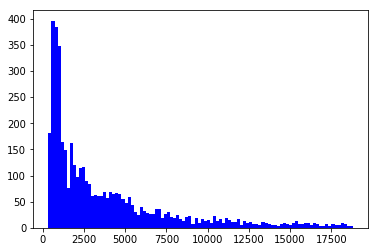

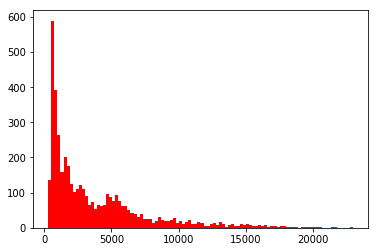

In [32]:
print("MSE: %.3f" % metrics.mean_squared_error(y_val, y_pred))
print("MAE: %.3f" % metrics.mean_absolute_error(y_val, y_pred))
print('R2: %.3f' % metrics.r2_score(y_val, y_pred))

plt.hist(y_val, bins=100, color='blue', linewidth=3)
plt.show()
plt.hist(y_pred, bins=100, color='red', linewidth=3)
plt.show()

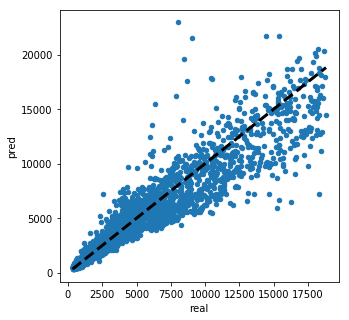

In [33]:
df = pd.DataFrame({'real': y_val, 'pred': y_pred})
ax = df.sort_values('real').plot.scatter('real', 'pred', figsize=(5, 5))
_ = ax.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=3)

In [34]:
def oneHotEncoding(features,columnName):
	currentCol = features.columns.get_loc(columnName)
	uniqueFeatures = features[columnName].unique()
	print(uniqueFeatures)
	for f in range(len(uniqueFeatures)):
		features.insert(loc=currentCol+f,column=columnName+str(f),value=0)
		features[columnName+str(f)][features[columnName]==uniqueFeatures[f]] = 1
		
	features.pop(columnName)

def dummieCoding(features,columnName,orderedFeature):
	c = 0
	for f in range(len(orderedFeature)):
		features[columnName][features[columnName]==orderedFeature[f]] = 2**c
		c = c + 1

In [35]:
def SMSE(parameters,features,target,j):
	npFeatures = features.values
	h = (np.sum(np.multiply(parameters,npFeatures))-target) * npFeatures[j]
	return h


def SGD(alpha, iterations, features, target):
	features.insert(0,"theta0",1)
	shape = features.shape
	nsamples = shape[0]
	print("Number of samples: "+str(nsamples))
	nparams = shape[1]
	print("Number of parameters: "+str(nparams))

	parameters = np.zeros(nparams)
	new_parameters = np.zeros(nparams)

	error = 1
	epsilon = 0.0001
	it = 0
	i = 0

	while ((error > epsilon) and (it < iterations) and (i < nsamples)):
		for j in range(nparams):
			new_parameters[j] = parameters[j] - alpha *             SMSE(parameters,features.ix[i],target.ix[i],j)		
		it += 1
		i += 1
		error = math.sqrt(np.sum(np.power(np.subtract(new_parameters,parameters),2)))
		print(parameters)
		print(new_parameters)
		np.copyto(parameters,new_parameters)
		print("Epoch: "+str(it))
		print("Sample: "+str(i))
		print("Error: "+str(error))
		print("\n\n")

	features.pop("theta0")

	return parameters

In [36]:
theta = np.array([1, 0, 1], dtype=np.double)
theta_temp = np.array([0, 0, 0], dtype=np.double)
y = np.array([5.,10.], dtype=np.double)
X = np.array([[0.,1., 2.],[0.,2., 3.]], dtype=np.double)
print (X)
alpha = .01
max_iter = 50

[[0. 1. 2.]
 [0. 2. 3.]]


In [37]:
def hyphotesis(theta, X):
    return np.sum(theta.T * X, axis=1)
    
def MSE_theta(theta, X, y, alpha,j, h0, error):                
        S = np.sum(np.matmul(error, X[:,j]))                
        result = theta[j] - (alpha * (1. / len(y)) * S)        
        return result

for i in range(max_iter):
    h0 = hyphotesis(theta, X)
    error = (h0 - y)
    for j in range(X.shape[1]):
        theta_temp[j] = MSE_theta(theta, X, y, alpha, j, h0, error)    
        
    theta = theta_temp.copy()
    print (theta)    

hyphotesis(theta, X)

[1.    0.085 1.135]
[1.       0.162475 1.257825]
[1.         0.23310013 1.36956737]
[1.         0.29748993 1.47122149]
[1.         0.35620382 1.5636925 ]
[1.         0.40975102 1.64780433]
[1.         0.45859507 1.72430701]
[1.         0.50315792 1.79388325]
[1.         0.54382364 1.85715452]
[1.         0.58094187 1.91468653]
[1.         0.61483086 1.96699423]
[1.         0.64578032 2.01454637]
[1.         0.67405396 2.05776965]
[1.         0.69989182 2.09705246]
[1.         0.72351243 2.13274838]
[1.         0.74511468 2.16517924]
[1.         0.76487964 2.194638  ]
[1.         0.78297213 2.22139134]
[1.         0.79954218 2.24568202]
[1.         0.81472634 2.267731  ]
[1.         0.82864894 2.28773943]
[1.         0.84142314 2.30589041]
[1.         0.85315195 2.32235061]
[1.         0.86392912 2.33727174]
[1.         0.87384003 2.35079191]
[1.         0.88296235 2.36303684]
[1.         0.89136682 2.37412095]
[1.         0.89911781 2.38414842]
[1.         0.90627393 2.39321406]
[1.   

array([5.91038925, 9.35683622])

In [38]:
import math

import math


def SGD_(alpha, max_iter, X, y):
    
    # Creating theta0 
    X = np.insert(X, values=1, obj=0, axis=1)
    
    shape = X.shape
    nsamples = shape[0]
    print("Number of samples: "+str(nsamples))
    theta0 = np.zeros(nsamples)
    nparams = shape[1]
    print("Number of parameters: "+str(nparams))


    theta = np.random.uniform(size=nparams)
    theta_temp = np.ones(nparams)

    error = 1
    epsilon = 0.001
    it = 0
    i = 0   
    power_t = 0.25
    t=1.0
    
    while ((error > epsilon) and (it < max_iter)):
        h0 = hyphotesis(theta, X)
        eta = alpha / pow(t, power_t)
        error = (h0 - y)
        for j in range(nparams):
            theta_temp[j] = MSE_theta(theta, X, y, eta, j, h0, error)                
        it += 1
        i += 1
        y_pred = hyphotesis(theta_temp, X)
#         print (y,hyphotesis(theta_temp, X))
        error =  ((y - y_pred) ** 2).mean() / 2 
#         print(theta)
#         print(theta_temp)

        theta = theta_temp.copy()
        
        if (i % 100) == 0 or i == 1:
            print("Epoch: %s Batch: %s Error: %.8f lr: %.8f "%(it, i, error, eta))
        t += 1            
   
    return theta
def predict(theta, X):
    X = np.insert(X, values=1, obj=0, axis=1)
    return hyphotesis(theta_h, X)

max_iter = 10000
theta_h = SGD_(alpha, max_iter, X, y)
print (y,predict(theta_h, X))


Number of samples: 2
Number of parameters: 4
Epoch: 1 Batch: 1 Error: 7.07813183 lr: 0.01000000 
Epoch: 100 Batch: 100 Error: 0.39499952 lr: 0.00316228 
Epoch: 200 Batch: 200 Error: 0.37650484 lr: 0.00265915 
Epoch: 300 Batch: 300 Error: 0.36243366 lr: 0.00240281 
Epoch: 400 Batch: 400 Error: 0.34997782 lr: 0.00223607 
Epoch: 500 Batch: 500 Error: 0.33867444 lr: 0.00211474 
Epoch: 600 Batch: 600 Error: 0.32826473 lr: 0.00202052 
Epoch: 700 Batch: 700 Error: 0.31858241 lr: 0.00194413 
Epoch: 800 Batch: 800 Error: 0.30951163 lr: 0.00188030 
Epoch: 900 Batch: 900 Error: 0.30096711 lr: 0.00182574 
Epoch: 1000 Batch: 1000 Error: 0.29288341 lr: 0.00177828 
Epoch: 1100 Batch: 1100 Error: 0.28520876 lr: 0.00173641 
Epoch: 1200 Batch: 1200 Error: 0.27790118 lr: 0.00169904 
Epoch: 1300 Batch: 1300 Error: 0.27092591 lr: 0.00166538 
Epoch: 1400 Batch: 1400 Error: 0.26425374 lr: 0.00163481 
Epoch: 1500 Batch: 1500 Error: 0.25785973 lr: 0.00160686 
Epoch: 1600 Batch: 1600 Error: 0.25172239 lr: 0.001

In [39]:
max_iter = 10000
theta_h = SGD_(1., max_iter=max_iter, X=X_train, y=np.log(y_train.values))


Number of samples: 38822
Number of parameters: 12
Epoch: 1 Batch: 1 Error: 4.50387025 lr: 1.00000000 
Epoch: 100 Batch: 100 Error: 0.03572750 lr: 0.31622777 
Epoch: 200 Batch: 200 Error: 0.02837125 lr: 0.26591479 
Epoch: 300 Batch: 300 Error: 0.02638510 lr: 0.24028114 
Epoch: 400 Batch: 400 Error: 0.02573161 lr: 0.22360680 
Epoch: 500 Batch: 500 Error: 0.02548952 lr: 0.21147425 
Epoch: 600 Batch: 600 Error: 0.02539125 lr: 0.20205155 
Epoch: 700 Batch: 700 Error: 0.02534768 lr: 0.19441308 
Epoch: 800 Batch: 800 Error: 0.02532627 lr: 0.18803015 
Epoch: 900 Batch: 900 Error: 0.02531432 lr: 0.18257419 
Epoch: 1000 Batch: 1000 Error: 0.02530661 lr: 0.17782794 
Epoch: 1100 Batch: 1100 Error: 0.02530089 lr: 0.17364082 
Epoch: 1200 Batch: 1200 Error: 0.02529617 lr: 0.16990442 
Epoch: 1300 Batch: 1300 Error: 0.02529198 lr: 0.16653831 
Epoch: 1400 Batch: 1400 Error: 0.02528811 lr: 0.16348127 
Epoch: 1500 Batch: 1500 Error: 0.02528445 lr: 0.16068568 
Epoch: 1600 Batch: 1600 Error: 0.02528093 lr: 

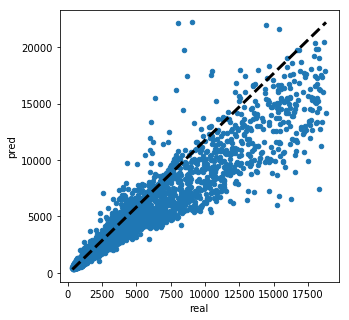

In [40]:
y_pred = np.exp(predict(theta_h, X_val))

df = pd.DataFrame({'real': y_val, 'pred': y_pred})
ax = df.sort_values('real').plot.scatter('real', 'pred', figsize=(5, 5))
_ = ax.plot([y_val.min(), y_val.max()], [y_pred.min(), y_pred.max()], 'k--', lw=3)



In [41]:
np.mean((np.log(y_pred) - np.log(y_val.values))**2)

0.05005902791998263

In [42]:
np.mean((y_pred - y_val.values)**2)

1747572.3396559386

MSE: 1747572.340
MAE: 715.588
R2: 0.891


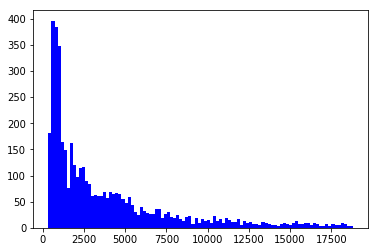

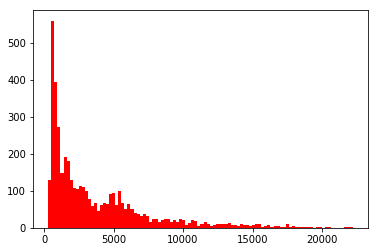

In [43]:
print("MSE: %.3f" % metrics.mean_squared_error(y_val, y_pred))
print("MAE: %.3f" % metrics.mean_absolute_error(y_val, y_pred))
print('R2: %.3f' % metrics.r2_score(y_val, y_pred))

plt.hist(y_val, bins=100, color='blue', linewidth=3)
plt.show()
plt.hist(y_pred, bins=100, color='red', linewidth=3)
plt.show()